In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime as dt
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
import requests
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Coinbase Utility Functions

In [5]:
def get_coinbase_historical_price_data(
    client,
    ticker,
    start_timestamp,
    end_timestamp,
    granularity="ONE_DAY",
    retries=3,
    delay=5,
):
    """
    Generic candle puller for Coinbase Advanced Trade RESTClient.get_candles().

    granularity examples:
      ONE_MINUTE, FIVE_MINUTE, FIFTEEN_MINUTE, THIRTY_MINUTE,
      ONE_HOUR, TWO_HOUR, FOUR_HOUR, SIX_HOUR, ONE_DAY
    """
    attempts = 0
    while attempts < retries:
        try:
            candle_list = client.get_candles(
                product_id=ticker,
                start=int(start_timestamp),
                end=int(end_timestamp),
                granularity=granularity,
            ).candles

            if not candle_list:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            candle_data = []
            for c in candle_list:
                candle_data.append(
                    {
                        "date": c["start"],  # epoch seconds
                        "low": float(c["low"]),
                        "high": float(c["high"]),
                        "open": float(c["open"]),
                        "close": float(c["close"]),
                        "volume": float(c["volume"]),
                    }
                )

            df = pd.DataFrame(candle_data)
            if df.empty or "date" not in df.columns:
                cols = ["open", "high", "low", "close", "volume"]
                return pd.DataFrame(columns=cols).rename_axis("date")

            # epoch seconds -> tz-aware UTC -> drop tz (tz-naive UTC)
            s = pd.to_datetime(pd.to_numeric(df["date"], errors="coerce"), unit="s", utc=True).dt.tz_localize(None)

            # Only normalize for daily bars; keep intraday timestamps intact
            if granularity == "ONE_DAY":
                s = s.dt.normalize()

            df["date"] = s
            df = df.set_index("date").sort_index().rename_axis("date")

            return df

        except requests.exceptions.ConnectionError as e:
            print(f"Connection error: {e}. Retrying in {delay} seconds...")
            attempts += 1
            time.sleep(delay)

    raise Exception("Max retries exceeded. Could not connect to Coinbase API.")


In [6]:
def save_historical_crypto_prices_from_coinbase(
    ticker,
    user_start_date=False,
    start_date=None,
    end_date=None,
    save_to_file=False,
    portfolio_name="Default",
    granularity="ONE_DAY",
):
    """
    Pull historical candles for a single ticker at the requested granularity.

    Note: Coinbase candle endpoints have request caps (commonly 300 candles per call),
    so we chunk requests.
    """
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

    if user_start_date:
        start_date = pd.Timestamp(start_date)
    else:
        start_date = cn.coinbase_start_date_by_ticker_dict.get(ticker)
        start_date = pd.Timestamp(start_date)
        if start_date is None:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None

    end_date = pd.Timestamp(end_date)

    # seconds per bar (used to step chunks without gaps)
    granularity_to_seconds = {
        "ONE_MINUTE": 60,
        "FIVE_MINUTE": 300,
        "FIFTEEN_MINUTE": 900,
        "THIRTY_MINUTE": 1800,
        "ONE_HOUR": 3600,
        "TWO_HOUR": 7200,
        "FOUR_HOUR": 14400,
        "SIX_HOUR": 21600,
        "ONE_DAY": 86400,
    }
    bar_sec = granularity_to_seconds.get(granularity)
    if bar_sec is None:
        raise ValueError(f"Unsupported granularity: {granularity}")

    # Keep your old 6-week chunking (works great for ONE_DAY and FOUR_HOUR),
    # but ensure we never step by +1 day when doing intraday.
    temp_start = start_date
    current_end = temp_start

    dfs = []
    while current_end < end_date:
        # 6 weeks is safe for FOUR_HOUR (≈252 candles) under the typical 300 limit :contentReference[oaicite:1]{index=1}
        current_end = pd.to_datetime(temp_start) + dt.timedelta(weeks=6)
        if current_end > end_date:
            current_end = end_date

        start_ts = int(pd.Timestamp(temp_start).timestamp())
        end_ts = int(pd.Timestamp(current_end).timestamp())

        df_chunk = get_coinbase_historical_price_data(
            client=client,
            ticker=ticker,
            start_timestamp=start_ts,
            end_timestamp=end_ts,
            granularity=granularity,
        )
        dfs.append(df_chunk)

        # advance by exactly one bar to avoid duplicates and avoid gaps
        temp_start = pd.to_datetime(current_end) + pd.Timedelta(seconds=bar_sec)

    if not dfs:
        cols = ["open", "high", "low", "close", "volume"]
        return pd.DataFrame(columns=cols).rename_axis("date")

    df = pd.concat(dfs, axis=0)
    df = df[~df.index.duplicated(keep="last")].sort_index()

    # optional: save_to_file logic can stay as you had it (not shown in your snippet)

    return df


In [9]:
cn_ticker_list = cn.coinbase_start_date_by_ticker_dict

In [14]:
cn_ticker_list

{'BTC-USD': '2016-01-01',
 'ETH-USD': '2016-06-01',
 'SOL-USD': '2021-06-01',
 'ADA-USD': '2021-03-01',
 'AVAX-USD': '2021-09-01',
 'DOT-USD': '2021-06-01',
 'ATOM-USD': '2020-01-01',
 'LTC-USD': '2016-09-01',
 'XRP-USD': '2023-06-01',
 'ALGO-USD': '2019-08-01',
 'XLM-USD': '2019-02-01',
 'TON-USD': '2025-11-18',
 'NEAR-USD': '2022-09-01',
 'ICP-USD': '2021-05-10',
 'HBAR-USD': '2022-10-13',
 'SUI-USD': '2023-05-18',
 'CRO-USD': '2021-11-01',
 'APT-USD': '2022-10-19',
 'XTZ-USD': '2019-08-06',
 'EGLD-USD': '2022-12-07',
 'FIL-USD': '2020-12-09',
 'SEI-USD': '2023-08-15',
 'TIA-USD': '2023-11-01',
 'KAVA-USD': '2023-01-19',
 'ROSE-USD': '2022-04-26',
 'MATIC-USD': '2021-02-01',
 'SKL-USD': '2021-02-01',
 'OP-USD': '2022-06-01',
 'ARB-USD': '2023-03-23',
 'POL-USD': '2024-09-04',
 'IMX-USD': '2021-12-09',
 'STRK-USD': '2024-02-21',
 'BLAST-USD': '2024-06-26',
 'ZK-USD': '2024-09-25',
 'LRC-USD': '2020-09-15',
 'ZORA-USD': '2025-04-24',
 'METIS-USD': '2022-06-28',
 'STX-USD': '2022-01-20'

In [16]:
ticker_list = []
exclude_list = ['USDT-USD','DAI-USD','USD1-USD','PAX-USD','MATIC-USD']
for ticker, date in cn_ticker_list.items():
    if (pd.Timestamp(cn_ticker_list[ticker]).date() <= pd.Timestamp('2022-04-01').date()) & (ticker not in exclude_list):
        ticker_list.append(ticker)

In [18]:
print(len(ticker_list))
ticker_list

40


['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'DOT-USD',
 'ATOM-USD',
 'LTC-USD',
 'ALGO-USD',
 'XLM-USD',
 'ICP-USD',
 'CRO-USD',
 'XTZ-USD',
 'FIL-USD',
 'SKL-USD',
 'IMX-USD',
 'LRC-USD',
 'STX-USD',
 'DOGE-USD',
 'SHIB-USD',
 'LINK-USD',
 'FET-USD',
 'GRT-USD',
 'RNDR-USD',
 'OXT-USD',
 'AIOZ-USD',
 'DIA-USD',
 'KRL-USD',
 'UNI-USD',
 'AAVE-USD',
 'AMP-USD',
 'COMP-USD',
 'MKR-USD',
 'SNX-USD',
 'SUSHI-USD',
 'CRV-USD',
 'BAL-USD',
 '1INCH-USD',
 'MANA-USD',
 'REQ-USD']

In [20]:
def get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list, fill_missing=True):

    df_dict_by_ticker = {}
    ticker_list_len = len(ticker_list)
    loop_start = 0
    loop_end = 0
    counter = 0
    while counter < ticker_list_len:
        loop_start = counter
        if counter == 40:
            loop_end = ticker_list_len
        else:
            loop_end = counter + 10
        print(counter, loop_start, loop_end, ticker_list[loop_start: loop_end])
        for t in ticker_list[loop_start: loop_end]:
            df_dict_by_ticker[t] = save_historical_crypto_prices_from_coinbase(
                ticker=t,
                user_start_date=True,
                start_date=start_date,
                end_date=end_date,
                portfolio_name="Default",
                granularity="FOUR_HOUR",
            )
        counter += 10
    
    # Optional: one combined frame (MultiIndex: ticker, date)
    df_all = pd.concat(df_dict_by_ticker, names=["ticker", "date"]).sort_index()

    # --- build expected 4H grid ---
    start = pd.Timestamp(start_date).floor("4H")
    end = pd.Timestamp(end_date).ceil("4H")
    expected_dates = pd.date_range(start=start, end=end, freq="4H")#, inclusive="left")

    full_index = pd.MultiIndex.from_product(
        [ticker_list, expected_dates],
        names=["ticker", "date"]
    )

    # --- align everything to full grid ---
    df_all = df_all.reindex(full_index)

    # --- flag missing bars ---
    df_all["imputed"] = df_all["close"].isna()

    if fill_missing:
        # Forward-fill ONLY close per ticker (for alignment / valuation)
        df_all["close"] = df_all.groupby(level=0)["close"].ffill()

        # For imputed rows: set OHLC = close, volume=0
        m = df_all["imputed"]
        for col in ["open", "high", "low"]:
            df_all.loc[m, col] = df_all.loc[m, "close"]
        df_all.loc[m, "volume"] = 0.0

    # if you want a flat frame:
    df_all = df_all.reset_index()

    return df_all

In [22]:
%%time
start_date = "2022-04-01"
end_date   = "2024-12-31"
# df_ticker_price_impute = get_coinbase_price_data_for_ticker_list(start_date, end_date, ticker_list, fill_missing=True)

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 8.82 μs


In [ ]:
## Save Files to Parquet for later use
df_ticker_price_impute.to_parquet(
    f"/Users/adheerchauhan/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet",
    index=False,
    compression="zstd",  # great balance of size + speed
)

In [24]:
## Read Parquet Files
df_ticker_price_impute = pd.read_parquet(f"/Users/adheerchauhan/git/trend_following/data_folder/coinbase_4_min_bar_data/coinbase_ohlcv_4min_{start_date}-{end_date}.parquet")

In [26]:
df_ticker_price_impute.head()

ticker                date       low      high      open     close  \
0  BTC-USD 2022-04-01 00:00:00  44232.86  45655.42  45525.25  44614.99   
1  BTC-USD 2022-04-01 04:00:00  44554.06  45115.70  44612.73  45030.70   
2  BTC-USD 2022-04-01 08:00:00  45009.73  45338.35  45030.71  45082.74   
3  BTC-USD 2022-04-01 12:00:00  44722.00  46739.24  45081.52  46545.39   
4  BTC-USD 2022-04-01 16:00:00  45906.00  46607.89  46545.31  46390.69   

        volume  imputed  
0  4498.191859    False  
1  1866.920775    False  
2  1735.690901    False  
3  5000.839037    False  
4  3498.550271    False

In [28]:
df_ticker_price_impute.shape

(241240, 8)

In [30]:
df_ticker_price_impute.groupby(['ticker']).size()

ticker
1INCH-USD    6031
AAVE-USD     6031
ADA-USD      6031
AIOZ-USD     6031
ALGO-USD     6031
AMP-USD      6031
ATOM-USD     6031
AVAX-USD     6031
BAL-USD      6031
BTC-USD      6031
COMP-USD     6031
CRO-USD      6031
CRV-USD      6031
DIA-USD      6031
DOGE-USD     6031
DOT-USD      6031
ETH-USD      6031
FET-USD      6031
FIL-USD      6031
GRT-USD      6031
ICP-USD      6031
IMX-USD      6031
KRL-USD      6031
LINK-USD     6031
LRC-USD      6031
LTC-USD      6031
MANA-USD     6031
MKR-USD      6031
OXT-USD      6031
REQ-USD      6031
RNDR-USD     6031
SHIB-USD     6031
SKL-USD      6031
SNX-USD      6031
SOL-USD      6031
STX-USD      6031
SUSHI-USD    6031
UNI-USD      6031
XLM-USD      6031
XTZ-USD      6031
dtype: int64

## Backtesting Engine

In [33]:
def estimate_fee_per_trade_w_enable_switch(passive_trade_rate=0.5, maker_fee=0.006, taker_fee=0.012, enable_fees=True):
    if not enable_fees:
        return 0.0
    proportion_maker = passive_trade_rate
    proportion_taker = (1 - passive_trade_rate)
    return (maker_fee * proportion_maker) + (taker_fee * proportion_taker)

In [35]:
# -----------------------------
# NEW: Turnover helpers
# -----------------------------
TURNOVER_COLS = [
    "buy_notional_gross",
    "sell_notional_gross",
    "gross_traded_notional",
    "turnover_pct",
    "turnover_pct_half",
    "buy_turnover_pct",
    "sell_turnover_pct",
]

def ensure_turnover_cols_in_df(df_portfolio: pd.DataFrame) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        if c not in df_portfolio.columns:
            df_portfolio[c] = 0.0
            
    return df_portfolio

def reset_turnover_for_period(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    for c in TURNOVER_COLS:
        df_portfolio.loc[period, c] = 0.0

    return df_portfolio

def finalize_turnover_metrics(df_portfolio: pd.DataFrame, period) -> pd.DataFrame:
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])
    gross = float(df_portfolio.loc[period, "gross_traded_notional"])
    buys = float(df_portfolio.loc[period, "buy_notional_gross"])
    sells = float(df_portfolio.loc[period, "sell_notional_gross"])

    if pv > 0:
        df_portfolio.loc[period, "turnover_pct"] = gross / pv
        df_portfolio.loc[period, "turnover_pct_half"] = gross / (2.0 * pv)
        df_portfolio.loc[period, "buy_turnover_pct"] = buys / pv
        df_portfolio.loc[period, "sell_turnover_pct"] = sells / pv
    else:
        df_portfolio.loc[period, "turnover_pct"] = 0.0
        df_portfolio.loc[period, "turnover_pct_half"] = 0.0
        df_portfolio.loc[period, "buy_turnover_pct"] = 0.0
        df_portfolio.loc[period, "sell_turnover_pct"] = 0.0

    return df_portfolio

In [37]:
def roll_portfolio_positions(df_portfolio: pd.DataFrame, current_period) -> pd.DataFrame:
    current_period = pd.Timestamp(current_period)

    cols = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
    ]

    last_vals = df_portfolio.iloc[-1][cols]

    # Ensure the row exists, then assign all columns at once
    if current_period not in df_portfolio.index:
        df_portfolio.loc[current_period, cols] = pd.NA

    df_portfolio.loc[current_period, cols] = last_vals.values

    ## Reset Turnover for New Period
    reset_turnover_for_period(df_portfolio, period=current_period)
    
    return df_portfolio

In [39]:
def compute_deployable_cash(df_portfolio, period, cash_buffer_percentage):

    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage

    ## Available Cash to be deployed for new positions
    avail_cash = float(df_portfolio.loc[period, "available_cash"])
    deployable_cash = max(0.0, avail_cash - desired_cash)
    
    return deployable_cash


def compute_gross_to_deploy_target_per_vintage(df_portfolio, period, cash_buffer_percentage, fwd_return_period):
    """
    NEW: deploy ~1/fwd_return_period of the *target invested* notional each bar (subject to buffer + available cash).

    target_total_invested = PV * (1 - buffer)
    target_per_vintage    = target_total_invested / fwd_return_period

    max_deploy_now        = max(0, available_cash - PV*buffer)
    gross_to_deploy       = min(target_per_vintage, max_deploy_now)
    """
    ## Total Portfolio Value
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])

    ## Available Cash
    avail_cash = float(df_portfolio.loc[period, "available_cash"])

    ## Cash Buffer to keep prior to taking positions
    desired_cash = pv * cash_buffer_percentage
    deployable_cash = max(0.0, avail_cash - desired_cash)

    ## Target Invested per Vintage
    target_total_invested = pv * (1.0 - cash_buffer_percentage)
    target_per_vintage = target_total_invested / float(fwd_return_period)
    gross_to_deploy = min(target_per_vintage, deployable_cash)
    
    return float(gross_to_deploy)


def open_new_vintage_positions(
    df_position, df_portfolio, df_signal, period,
    fwd_return_period, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    vintage_name, signal_col='trade_signal_exec'
):
    
    df_signal_working = df_signal.copy()
    signal_current_period_cond = (df_signal_working["date"] == period)

    ## Get Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    ## Calculate cash budget available to be deployed for new positions
    deployable_cash = compute_deployable_cash(df_portfolio, period, cash_buffer_percentage)
    gross_to_deploy = compute_gross_to_deploy_target_per_vintage(
        df_portfolio=df_portfolio,
        period=period,
        cash_buffer_percentage=cash_buffer_percentage,
        fwd_return_period=fwd_return_period,
    )

    ## Get the updated signal for current period
    non_zero_position_cond = (df_signal_working[signal_col].fillna(0).astype(float) != 0.0)
    picks = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].copy()
    n = len(picks)
    if n == 0 or gross_to_deploy <= 0:
        return df_position, df_portfolio

    ## Update Trade Weights for current period
    # NOTE: it's now informational only; sizing uses gross_to_deploy / n below.
    picks["position_weight"] = 1.0 / (fwd_return_period * n)

    # -----------------------------
    # CHANGE #3: allocate target-per-vintage gross equally across selected names
    # -----------------------------
    picks["trade_notional_gross"] = gross_to_deploy / float(n)

    picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    picks["position_size"] = picks["position_notional"] / picks["open"]
    picks["vintage_id"] = vintage_name
    picks["holding_period_counter"] = 1.0

    ## Append the Current Period Signal Dataframe for the Vintage to the Daily Positions Dataframe
    df_position = pd.concat([df_position, picks], ignore_index=True)

    ## Update Portfolio Cash based on new positions
    cash_usage = float(picks["trade_notional_gross"].sum())
    df_portfolio.loc[period, "available_cash"] = float(df_portfolio.loc[period, "available_cash"]) - cash_usage

    # NEW: turnover accounting (buys)
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[period, "buy_notional_gross"] = float(df_portfolio.loc[period, "buy_notional_gross"]) + cash_usage
    df_portfolio.loc[period, "gross_traded_notional"] = float(df_portfolio.loc[period, "gross_traded_notional"]) + cash_usage

    ## Update Portfolio Positions by Net Notional
    df_portfolio.loc[period, "total_position_notional"] = float(df_portfolio.loc[period, "total_position_notional"]) + float(picks["position_notional"].sum())
    df_portfolio.loc[period, "total_portfolio_value"] = float(df_portfolio.loc[period, "available_cash"]) + float(df_portfolio.loc[period, "total_position_notional"])
    df_portfolio.loc[period, "total_portfolio_value_upper_limit"] = float(df_portfolio.loc[period, "total_portfolio_value"]) * (1 - cash_buffer_percentage)

    return df_position, df_portfolio

def open_new_vintage_positions_with_turnover_cap(
    df_position, df_portfolio, df_signal, period,
    fwd_return_period, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    vintage_name, signal_col='trade_signal_exec',
    # ---------------- NEW controls ----------------
    held_tickers=None,                 # set[str]: tickers already held (across ALL vintages)
    cooldown_tickers=None,             # set[str]: tickers blocked from re-entry
    max_names=None,                    # int: cap number of names to open this bar
    max_name_weight=0.05,              # float: max gross per name as % of PV
    min_trade_notional_gross=0.0,      # float: skip tiny trades
    regime_filter_cols=None,           # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
    sort_col=None,                     # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
    sort_ascending=True,               # True => most negative first (mean reversion long)
):
    df_signal_working = df_signal.copy()
    signal_current_period_cond = (df_signal_working["date"] == period)

    est_fees = (
        transaction_cost_est
        + estimate_fee_per_trade_w_enable_switch(
            passive_trade_rate=passive_trade_rate,
            enable_fees=enable_fees
        )
    )

    gross_to_deploy = compute_gross_to_deploy_target_per_vintage(
        df_portfolio=df_portfolio,
        period=period,
        cash_buffer_percentage=cash_buffer_percentage,
        fwd_return_period=fwd_return_period,
    )
    if gross_to_deploy <= 0:
        return df_position, df_portfolio

    non_zero_position_cond = (df_signal_working[signal_col].fillna(0).astype(float) != 0.0)
    picks = df_signal_working.loc[signal_current_period_cond & non_zero_position_cond].copy()
    if picks.empty:
        return df_position, df_portfolio

    # (1) Anti-stacking: do NOT buy tickers already held anywhere
    if held_tickers:
        picks = picks[~picks["ticker"].isin(held_tickers)]

    # (2) Cooldown: do NOT re-enter just-exited tickers
    if cooldown_tickers:
        picks = picks[~picks["ticker"].isin(cooldown_tickers)]

    # (3) Falling-knife / regime filters (columns must be precomputed upstream)
    if regime_filter_cols:
        for c in regime_filter_cols:
            if c in picks.columns:
                picks = picks[picks[c].astype(int) == 1]

    if picks.empty:
        return df_position, df_portfolio

    # Optional: choose the “best” subset to reduce churn
    if sort_col and sort_col in picks.columns:
        picks = picks.sort_values(sort_col, ascending=sort_ascending)

    if max_names is not None:
        picks = picks.head(int(max_names))

    n = len(picks)
    if n == 0:
        return df_position, df_portfolio

    # (4) Concentration cap: cap gross per name as % of PV
    pv = float(df_portfolio.loc[period, "total_portfolio_value"])
    cap_per_name_gross = max(0.0, float(max_name_weight) * pv)

    equal_gross_per_name = gross_to_deploy / float(n)
    gross_per_name = min(equal_gross_per_name, cap_per_name_gross)

    # (5) Skip tiny trades to avoid fee-churn
    if gross_per_name < float(min_trade_notional_gross):
        return df_position, df_portfolio

    picks["position_weight"] = 1.0 / (fwd_return_period * n)  # informational only
    picks["trade_notional_gross"] = gross_per_name

    picks["position_notional"] = picks["trade_notional_gross"] * (1 - est_fees)
    picks["position_size"] = picks["position_notional"] / picks["open"]
    picks["vintage_id"] = vintage_name
    picks["holding_period_counter"] = 1.0

    df_position = pd.concat([df_position, picks], ignore_index=True)

    cash_usage = float(picks["trade_notional_gross"].sum())
    df_portfolio.loc[period, "available_cash"] = float(df_portfolio.loc[period, "available_cash"]) - cash_usage

    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[period, "buy_notional_gross"] = float(df_portfolio.loc[period, "buy_notional_gross"]) + cash_usage
    df_portfolio.loc[period, "gross_traded_notional"] = float(df_portfolio.loc[period, "gross_traded_notional"]) + cash_usage

    df_portfolio.loc[period, "total_position_notional"] = float(df_portfolio.loc[period, "total_position_notional"]) + float(picks["position_notional"].sum())
    df_portfolio.loc[period, "total_portfolio_value"] = float(df_portfolio.loc[period, "available_cash"]) + float(df_portfolio.loc[period, "total_position_notional"])
    df_portfolio.loc[period, "total_portfolio_value_upper_limit"] = float(df_portfolio.loc[period, "total_portfolio_value"]) * (1 - cash_buffer_percentage)

    return df_position, df_portfolio


In [41]:
def update_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, cash_buffer_percentage, vintage_name):
    """
    Roll/mark-to-market positions that were open in `vintage_name` from prior_period to current_period.

    Fixes vs your original:
    - Maps prior positions by (date, vintage_id, ticker) so you never accidentally pull from another vintage.
    - Avoids per-ticker loops; uses merge/map which is faster + safer.
    - Updates holding counter robustly (max across vintage rows) instead of values[0] from an arbitrary row.
    - Updates portfolio total_position_notional by the *delta* in this vintage's mark-to-market.
    - Leaves cash unchanged (correct for MTM-only step).
    """

    current_period = pd.Timestamp(current_period)
    prior_period = pd.Timestamp(prior_period)

    ## Get Vintage Position Data for Prior Period
    notional_cond = (df_position['position_notional'] > 0)
    prior_vintage = df_position.loc[
        (df_position["date"] == prior_period) & (df_position["vintage_id"] == vintage_name) & (notional_cond)
    ].copy()

    ## If there is no Vintage data from the prior period, exit as there is nothing to update.
    if prior_vintage.empty:
        return df_position, df_portfolio

    ## Keep only one row per ticker (should already be one; this guards against accidental duplicates)
    prior_vintage = (
        prior_vintage.sort_values(["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    prior_tickers = prior_vintage["ticker"].tolist()

    ## Get current period rows from signal dataframe for Vintage tickers
    cur_rows = df_signal.loc[
        (df_signal["date"] == current_period) & (df_signal["ticker"].isin(prior_tickers))
    ].copy()

    ## If for some reason df_signal is missing current_period rows for some tickers, drop them.
    if cur_rows.empty:
        return df_position, df_portfolio

    ## Create a map of the Position Size and Weight by ticker from the prior period
    prior_map = prior_vintage.set_index("ticker")[["position_size", "position_weight"]]

    ## Map the Weight and Position Size from the Prior Period to the Current Period
    cur_rows["position_size"] = cur_rows["ticker"].map(prior_map["position_size"])
    cur_rows["position_weight"] = cur_rows["ticker"].map(prior_map["position_weight"])

    ## Drop any tickers we failed to map (should not happen unless data is inconsistent)
    cur_rows = cur_rows.dropna(subset=["position_size", "position_weight"])

    ## Mark all positions to the current open
    cur_rows["position_notional"] = cur_rows["position_size"] * cur_rows["open"]
    cur_rows["vintage_id"] = vintage_name

    ## Update the Holding Counter
    prior_counter = prior_vintage["holding_period_counter"].max()
    cur_rows["holding_period_counter"] = prior_counter + 1

    ## Append to positions table
    df_position = pd.concat([df_position, cur_rows], axis=0, ignore_index=True)

    ## Update portfolio MTM for this vintage (cash unchanged)
    prior_vintage_notional = prior_vintage["position_notional"].sum()
    cur_vintage_notional = cur_rows["position_notional"].sum()
    delta_notional = cur_vintage_notional - prior_vintage_notional

    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + delta_notional
    )
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"]
        + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    return df_position, df_portfolio

In [43]:
def exit_open_vintage_positions(df_position, df_portfolio, df_signal, current_period, prior_period, transaction_cost_est, passive_trade_rate, enable_fees, 
                                cash_buffer_percentage, vintage_name):
    """
    Exits (closes) all open positions for a given vintage at the CURRENT_PERIOD open,
    using position sizes from the PRIOR_PERIOD for that same vintage.

    Key fixes vs your version:
      - Avoids modifying a filtered slice (SettingWithCopy) by building a .copy() frame for exits.
      - Uses a ticker->position_size mapping from df_position (scalar per ticker) and merges via .map().
      - Handles duplicates safely (keeps last by date ordering) and empty cases gracefully.
    """

    # Work on copies to avoid side effects
    df_signal_working = df_signal.copy()

    # --- Conditions ---
    position_current_period_cond = (df_position["date"] == current_period)
    position_prior_period_cond = (df_position["date"] == prior_period)
    signal_current_period_cond = (df_signal_working["date"] == current_period)
    vintage_cond = (df_position["vintage_id"] == vintage_name)

    # --- Estimated total fees/slippage model ---
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))

    # --- Identify tickers that were open in the prior period for this vintage ---
    prior_vintage_positions = df_position.loc[position_prior_period_cond & vintage_cond, ["ticker", "position_size", "position_notional"]].copy()

    if prior_vintage_positions.empty:
        # Nothing to exit; return unchanged
        return df_position, df_portfolio

    # If df_position can contain multiple rows per ticker for the same date/vintage,
    # keep the last one deterministically.
    prior_vintage_positions = (
        prior_vintage_positions
        .dropna(subset=["ticker"])
        .drop_duplicates(subset=["ticker"], keep="last")
    )

    non_zero_tickers_prior_period = prior_vintage_positions["ticker"].tolist()

    # --- Build exit frame for current period (copy, so we can mutate safely) ---
    mask_exit = signal_current_period_cond & df_signal_working["ticker"].isin(non_zero_tickers_prior_period)
    df_signal_current_period = df_signal_working.loc[mask_exit].copy()

    if df_signal_current_period.empty:
        # No signal rows for these tickers at current_period; cannot mark/exit
        return df_position, df_portfolio

    # --- Map prior position sizes into current period rows ---
    ticker_to_size = prior_vintage_positions.set_index("ticker")["position_size"]
    df_signal_current_period["position_size"] = df_signal_current_period["ticker"].map(ticker_to_size)

    # If any tickers didn't map (shouldn't happen), set them to 0 and ignore in exit
    df_signal_current_period["position_size"] = df_signal_current_period["position_size"].fillna(0.0)

    # --- Compute exit notional net of fees (sell at open) ---
    df_signal_current_period["position_notional"] = (
        df_signal_current_period["position_size"] * df_signal_current_period["open"]
    )

    prior_period_position_notional = float(prior_vintage_positions['position_notional'].sum())
    current_mtm_position_notional = float(df_signal_current_period["position_notional"].sum())
    exit_net_position_notional = float(df_signal_current_period["position_notional"].sum()) * (1 - est_fees)

    # --- Update portfolio accounting ---
    # Ensure portfolio rows exist
    if current_period not in df_portfolio.index:
        raise KeyError(f"current_period {current_period} not found in df_portfolio.index")
    if "total_position_notional" not in df_portfolio.columns or "available_cash" not in df_portfolio.columns:
        raise KeyError("df_portfolio missing required columns: total_position_notional, available_cash")

    ## Capture the Mark to Market from Previous Open to Current Open prior to exiting the position
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] + (current_mtm_position_notional - prior_period_position_notional)
    )

    ## Capture the Bookeeping related to Exiting the Vintage
    # Hear we sell the current position notional but in the available cash, we capture the notional net of transaction costs
    df_portfolio.loc[current_period, "total_position_notional"] = (
        df_portfolio.loc[current_period, "total_position_notional"] - current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "available_cash"] = (
        df_portfolio.loc[current_period, "available_cash"] + exit_net_position_notional
    )

    ## Capture the Turnover Accounting
    df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
    df_portfolio.loc[current_period, "sell_notional_gross"] = (
        float(df_portfolio.loc[current_period, "sell_notional_gross"]) + current_mtm_position_notional
    )
    df_portfolio.loc[current_period, "gross_traded_notional"] = (
        float(df_portfolio.loc[current_period, "gross_traded_notional"]) + current_mtm_position_notional
    )

    ## Re-calculate the Total Portfolio Value and Upper Limit based on the Updated Portfolio
    df_portfolio.loc[current_period, "total_portfolio_value"] = (
        df_portfolio.loc[current_period, "available_cash"] + df_portfolio.loc[current_period, "total_position_notional"]
    )
    df_portfolio.loc[current_period, "total_portfolio_value_upper_limit"] = (
        df_portfolio.loc[current_period, "total_portfolio_value"] * (1 - cash_buffer_percentage)
    )

    # --- Append "closed" rows to df_position for audit trail ---
    # Set post-exit state fields
    df_signal_current_period["position_notional"] = 0.0
    df_signal_current_period["position_size"] = 0.0
    df_signal_current_period["position_weight"] = 0.0
    df_signal_current_period["vintage_id"] = vintage_name
    df_signal_current_period["holding_period_counter"] = 0

    # If df_position expects certain columns, align them
    for col in df_position.columns:
        if col not in df_signal_current_period.columns:
            df_signal_current_period[col] = np.nan

    df_signal_current_period = df_signal_current_period[df_position.columns]

    df_position_out = pd.concat([df_position, df_signal_current_period], axis=0, ignore_index=True)

    return df_position_out, df_portfolio

In [45]:
def run_mean_reversion_backtest(df_signal, fwd_return_period, initial_capital, cash_buffer_percentage, transaction_cost_est, passive_trade_rate, enable_fees, 
                                signal_col='trade_signal_exec',
                               # ---------------- NEW controls ----------------
                                held_tickers=None,                 # set[str]: tickers already held (across ALL vintages)
                                cooldown_tickers=None,             # set[str]: tickers blocked from re-entry
                                max_names=None,                    # int: cap number of names to open this bar
                                max_name_weight=0.05,              # float: max gross per name as % of PV
                                min_trade_notional_gross=0.0,      # float: skip tiny trades
                                regime_filter_cols=None,           # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                                sort_col=None,                     # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                                sort_ascending=True,               # True => most negative first (mean reversion long)
                               ):

    ## Get a list of all the periods in the signal dataframe
    period_list = sorted(df_signal.date.unique())

    if len(period_list) < 4:
        raise ValueError("Need at least 4 periods in df_signal to run this backtest.")

    ## Define the position weight per signal
    daily_weight_allocation = 1 / fwd_return_period # (kept for now; not used directly below)

    ## Initialize first positions in the signal dataframe
    df_signal = df_signal.copy()
    df_signal['position_weight'] = 0.0
    df_signal['position_notional'] = 0.0
    df_signal['position_size'] = 0.0
    df_signal['holding_period_counter'] = 0.0
    df_signal['vintage_id'] = np.nan
    
    ## Estimated T-Cost
    # est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    est_fees = (transaction_cost_est + estimate_fee_per_trade_w_enable_switch(passive_trade_rate=passive_trade_rate, enable_fees=enable_fees))
    
    ## Initialized Position and Portfolio Dataframes
    portfolio_columns = [
        'total_position_notional',
        'available_cash',
        'total_portfolio_value',
        'total_portfolio_value_upper_limit',
        'buy_notional_gross',
        'sell_notional_gross',
        'gross_traded_notional',
        'turnover_pct',
        'turnover_pct_half',
        'buy_turnover_pct',
        'sell_turnover_pct'
    ]
    df_portfolio = pd.DataFrame(columns=portfolio_columns)
    df_portfolio.index.name = 'date'
    df_position = pd.DataFrame(columns=df_signal.columns.tolist())

    ## Initialize the Cash and Portfolio Value prior to processing positions
    first_period = period_list[1]
    second_period = period_list[2]
    third_period = period_list[3]
    
    ## Initialize Daily Portfolio Positions prior to processing positions
    df_portfolio.loc[first_period, 'total_position_notional'] = 0.0
    df_portfolio.loc[first_period, 'available_cash'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value'] = float(initial_capital)
    df_portfolio.loc[first_period, 'total_portfolio_value_upper_limit'] = float(initial_capital) * (1 - cash_buffer_percentage)

    ## Initialize Turnover Columns
    df_portfolio = reset_turnover_for_period(df_portfolio, period=first_period)

    run_counter = 0
    run_counter_check = np.arange(0, len(period_list), 100).tolist()
    for i, current_period in enumerate(period_list[1:1000], start=1):
        if run_counter in run_counter_check:
            print(run_counter)
        prior_period = period_list[i - 1]
    
        ## Filtering Conditions
        signal_current_period_cond = (df_signal.date == current_period)
        df_signal_current_period = df_signal.loc[signal_current_period_cond].copy()
    
        if current_period > first_period:
            df_portfolio = roll_portfolio_positions(df_portfolio, current_period=current_period)
    
        if current_period == first_period:
            ## Open New Positions for Vintage 1
            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_1', signal_col=signal_col,
                held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                max_names=max_names,                    # int: cap number of names to open this bar
                max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                sort_ascending=sort_ascending)
    
        elif current_period == second_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Open New Positions for Vintage 2
            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_2', signal_col=signal_col,
                held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                max_names=max_names,                    # int: cap number of names to open this bar
                max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                sort_ascending=sort_ascending)
    
        elif current_period == third_period:
            ## Update Positions from Vintage 1
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_1')
    
            ## Update Positions from Vintage 2
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name='Vintage_2')
    
            ## Open New Positions for Vintage 3
            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name='Vintage_3', signal_col=signal_col,
                held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                max_names=max_names,                    # int: cap number of names to open this bar
                max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                sort_ascending=sort_ascending)
    
        else:
            vintage_list = df_position['vintage_id'].unique().tolist()
            for vintage in vintage_list:
                if pd.isna(vintage):
                    continue
                    
                vintage_cond = (df_position['vintage_id'] == vintage)
                ## Get the Holding Period Counter for the Vintage
                prior_vals = df_position.loc[(df_position.date == prior_period) & vintage_cond, 'holding_period_counter']
                if prior_vals.empty:
                    previous_period_holding_counter = 0
                else:
                    previous_period_holding_counter = prior_vals.max()
                    if pd.isna(previous_period_holding_counter):
                        previous_period_holding_counter = 0
                    previous_period_holding_counter = int(previous_period_holding_counter)
                
                if previous_period_holding_counter >= fwd_return_period:
                    ## Exit all open positions in current period
                    df_position, df_portfolio = exit_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)
                    ## Open New Positions for Vintage that just exited
                    df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col,
                        held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                        cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                        max_names=max_names,                    # int: cap number of names to open this bar
                        max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                        min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                        regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                        sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                        sort_ascending=sort_ascending)
                    
                elif 1 <= previous_period_holding_counter <= (fwd_return_period - 1):
                    ## Update Positions from Vintage
                    df_position, df_portfolio = update_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period, cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage)

                else:# previous_period_holding_counter == 0:
                    ## Open New Positions for Vintage
                    df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        period=current_period, fwd_return_period=fwd_return_period, cash_buffer_percentage=cash_buffer_percentage,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, vintage_name=vintage, signal_col=signal_col,
                        held_tickers=held_tickers,                 # set[str]: tickers already held (across ALL vintages)
                        cooldown_tickers=cooldown_tickers,             # set[str]: tickers blocked from re-entry
                        max_names=max_names,                    # int: cap number of names to open this bar
                        max_name_weight=max_name_weight,              # float: max gross per name as % of PV
                        min_trade_notional_gross=min_trade_notional_gross,      # float: skip tiny trades
                        regime_filter_cols=regime_filter_cols,                 # list[str]: boolean columns that must be True/1 (e.g., ["btc_regime_ok","coin_trend_ok"])
                        sort_col=sort_col,                    # str: sort key for picks (e.g., "resid_btc_zscore_prev_4h")
                        sort_ascending=sort_ascending)
                    
        ## Compute Turnover Ratios once per bar for the updated portfolio
        df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
        df_portfolio = finalize_turnover_metrics(df_portfolio, current_period)
        run_counter += 1

    return df_position, df_portfolio

In [47]:
# -----------------------------
# Helpers for held/cooldown
# -----------------------------
def _active_cooldown_set(cooldown_until: dict, bar_idx: int) -> set:
    # cooldown_until: ticker -> expiry_idx (inclusive)
    return {t for t, exp in cooldown_until.items() if bar_idx <= exp}

def _compute_held_tickers_excl_self(
    df_position: pd.DataFrame,
    current_period,
    prior_period,
    vintage_list: list,
    processed_vintages: set,
    exclude_vintage: str,
) -> set:
    """
    Held tickers = union of:
      - For vintages already processed this bar: use current_period state (position_notional > 0)
      - For vintages not yet processed this bar: use prior_period state (position_notional > 0)
    Excludes the vintage currently being opened (exclude_vintage) so it doesn't block itself.
    """
    held = set()
    if df_position.empty:
        return held

    for v in vintage_list:
        if pd.isna(v) or v == exclude_vintage:
            continue

        vmask = (df_position["vintage_id"] == v)

        if v in processed_vintages:
            rows = df_position.loc[
                vmask
                & (df_position["date"] == current_period)
                & (df_position["position_notional"] > 0),
                "ticker",
            ]
        else:
            rows = df_position.loc[
                vmask
                & (df_position["date"] == prior_period)
                & (df_position["position_notional"] > 0),
                "ticker",
            ]

        if not rows.empty:
            held.update(rows.dropna().unique().tolist())

    return held

In [49]:
def run_mean_reversion_backtest_w_cooldown(
    df_signal, fwd_return_period, initial_capital, cash_buffer_percentage,
    transaction_cost_est, passive_trade_rate, enable_fees,
    signal_col='trade_signal_exec',
    # ---------------- NEW toggles ----------------
    enable_held_filter: bool = False,          # block buying tickers already held elsewhere
    enable_cooldown_filter: bool = False,      # block re-entry after exit
    cooldown_bars: int = 1,                    # number of bars to block after exit (incl. same bar)
    # ---------------- other controls forwarded to open ----------------
    max_names=None,
    max_name_weight=0.05,
    min_trade_notional_gross=0.0,
    regime_filter_cols=None,
    sort_col=None,
    sort_ascending=True,
):
    # -----------------------------
    # Periods
    # -----------------------------
    period_list = sorted(df_signal.date.unique())
    if len(period_list) < 4:
        raise ValueError("Need at least 4 periods in df_signal to run this backtest.")

    df_signal = df_signal.copy()
    df_signal["position_weight"] = 0.0
    df_signal["position_notional"] = 0.0
    df_signal["position_size"] = 0.0
    df_signal["holding_period_counter"] = 0.0
    df_signal["vintage_id"] = np.nan

    # (not used directly here, but keep as you had it)
    est_fees = (
        transaction_cost_est
        + estimate_fee_per_trade_w_enable_switch(
            passive_trade_rate=passive_trade_rate,
            enable_fees=enable_fees
        )
    )

    portfolio_columns = [
        "total_position_notional",
        "available_cash",
        "total_portfolio_value",
        "total_portfolio_value_upper_limit",
        "buy_notional_gross",
        "sell_notional_gross",
        "gross_traded_notional",
        "turnover_pct",
        "turnover_pct_half",
        "buy_turnover_pct",
        "sell_turnover_pct",
    ]
    df_portfolio = pd.DataFrame(columns=portfolio_columns)
    df_portfolio.index.name = "date"
    df_position = pd.DataFrame(columns=df_signal.columns.tolist())

    first_period = period_list[1]
    second_period = period_list[2]
    third_period = period_list[3]

    df_portfolio.loc[first_period, "total_position_notional"] = 0.0
    df_portfolio.loc[first_period, "available_cash"] = float(initial_capital)
    df_portfolio.loc[first_period, "total_portfolio_value"] = float(initial_capital)
    df_portfolio.loc[first_period, "total_portfolio_value_upper_limit"] = float(initial_capital) * (1 - cash_buffer_percentage)
    df_portfolio = reset_turnover_for_period(df_portfolio, period=first_period)

    # cooldown state lives here (ticker -> expiry bar index)
    cooldown_until = {} if enable_cooldown_filter else None

    run_counter = 0
    run_counter_check = np.arange(0, len(period_list), 100).tolist()

    for i, current_period in enumerate(period_list[1:1000], start=1):
        if run_counter in run_counter_check:
            print(run_counter)

        prior_period = period_list[i - 1]

        # Active cooldown tickers for this bar (if enabled)
        active_cooldown = _active_cooldown_set(cooldown_until, i) if enable_cooldown_filter else None

        # Current bar signal slice
        df_signal_current_period = df_signal.loc[df_signal.date == current_period].copy()

        if current_period > first_period:
            df_portfolio = roll_portfolio_positions(df_portfolio, current_period=current_period)

        # We maintain "processed vintages" within this bar so held-filter is correct even mid-bar
        processed_vintages = set()

        # Helper to call open with computed held/cooldown sets
        def _open(vintage_to_open: str):
            nonlocal df_position, df_portfolio, processed_vintages, active_cooldown

            vintage_list = df_position["vintage_id"].dropna().unique().tolist()

            held_set = None
            if enable_held_filter:
                held_set = _compute_held_tickers_excl_self(
                    df_position=df_position,
                    current_period=current_period,
                    prior_period=prior_period,
                    vintage_list=vintage_list,
                    processed_vintages=processed_vintages,
                    exclude_vintage=vintage_to_open,
                )

            cooldown_set = active_cooldown if enable_cooldown_filter else None

            df_position, df_portfolio = open_new_vintage_positions_with_turnover_cap(
                df_position=df_position,
                df_portfolio=df_portfolio,
                df_signal=df_signal_current_period,
                period=current_period,
                fwd_return_period=fwd_return_period,
                cash_buffer_percentage=cash_buffer_percentage,
                transaction_cost_est=transaction_cost_est,
                passive_trade_rate=passive_trade_rate,
                enable_fees=enable_fees,
                vintage_name=vintage_to_open,
                signal_col=signal_col,
                held_tickers=held_set,
                cooldown_tickers=cooldown_set,
                max_names=max_names,
                max_name_weight=max_name_weight,
                min_trade_notional_gross=min_trade_notional_gross,
                regime_filter_cols=regime_filter_cols,
                sort_col=sort_col,
                sort_ascending=sort_ascending,
            )

            processed_vintages.add(vintage_to_open)

        # -----------------------------
        # Warm start (first 3 bars)
        # -----------------------------
        if current_period == first_period:
            _open("Vintage_1")

        elif current_period == second_period:
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period,
                cash_buffer_percentage=cash_buffer_percentage, vintage_name="Vintage_1"
            )
            processed_vintages.add("Vintage_1")
            _open("Vintage_2")

        elif current_period == third_period:
            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period,
                cash_buffer_percentage=cash_buffer_percentage, vintage_name="Vintage_1"
            )
            processed_vintages.add("Vintage_1")

            df_position, df_portfolio = update_open_vintage_positions(
                df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                current_period=current_period, prior_period=prior_period,
                cash_buffer_percentage=cash_buffer_percentage, vintage_name="Vintage_2"
            )
            processed_vintages.add("Vintage_2")

            _open("Vintage_3")

        # -----------------------------
        # Main loop
        # -----------------------------
        else:
            vintage_list = df_position["vintage_id"].dropna().unique().tolist()

            for vintage in vintage_list:
                if pd.isna(vintage):
                    continue

                vintage_cond = (df_position["vintage_id"] == vintage)

                prior_vals = df_position.loc[
                    (df_position.date == prior_period) & vintage_cond,
                    "holding_period_counter"
                ]
                if prior_vals.empty:
                    previous_period_holding_counter = 0
                else:
                    previous_period_holding_counter = prior_vals.max()
                    if pd.isna(previous_period_holding_counter):
                        previous_period_holding_counter = 0
                    previous_period_holding_counter = int(previous_period_holding_counter)

                if previous_period_holding_counter >= fwd_return_period:
                    # Determine which tickers are being exited (for cooldown)
                    tickers_to_exit = []
                    if enable_cooldown_filter:
                        tickers_to_exit = df_position.loc[
                            (df_position["date"] == prior_period)
                            & (df_position["vintage_id"] == vintage)
                            & (df_position["position_notional"] > 0),
                            "ticker"
                        ].dropna().unique().tolist()

                    # Exit
                    df_position, df_portfolio = exit_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period,
                        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
                        enable_fees=enable_fees,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage
                    )
                    processed_vintages.add(vintage)

                    # Start cooldown (blocks same-bar re-entry too)
                    if enable_cooldown_filter and tickers_to_exit:
                        for t in tickers_to_exit:
                            new_exp = i + int(cooldown_bars)
                            cooldown_until[t] = max(cooldown_until.get(t, -1), new_exp)

                        # refresh active set for subsequent opens this same bar
                        active_cooldown = _active_cooldown_set(cooldown_until, i)

                    # Re-open this vintage
                    _open(vintage)

                elif 1 <= previous_period_holding_counter <= (fwd_return_period - 1):
                    df_position, df_portfolio = update_open_vintage_positions(
                        df_position=df_position, df_portfolio=df_portfolio, df_signal=df_signal_current_period,
                        current_period=current_period, prior_period=prior_period,
                        cash_buffer_percentage=cash_buffer_percentage, vintage_name=vintage
                    )
                    processed_vintages.add(vintage)

                else:
                    # Vintage is flat; open if signal present
                    _open(vintage)

        # Turnover metrics
        df_portfolio = ensure_turnover_cols_in_df(df_portfolio)
        df_portfolio = finalize_turnover_metrics(df_portfolio, current_period)
        run_counter += 1

        # Optional: prune expired cooldown entries
        if enable_cooldown_filter and cooldown_until:
            cooldown_until = {t: exp for t, exp in cooldown_until.items() if exp >= i}

    return df_position, df_portfolio


## Signal Construction

In [52]:
def calculate_z_score(df, return_col, date_col, z_score_col_name):

    return_mean = df.groupby([date_col])[return_col].transform('mean')
    return_std = df.groupby([date_col])[return_col].transform('std').replace(0, np.nan)
    df[z_score_col_name] = (df[return_col] - return_mean) / return_std

    return df
    

def build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50):

    df_returns = df.copy()

    ## Get Previous 4 hour returns
    ticker_group_close = df_returns.groupby(['ticker'])['close']
    df_returns['close_log_return_prev_4h'] = np.log(ticker_group_close.shift(1) / ticker_group_close.shift(2))

    ## Require a minimum number of tickers to calculate Z-Score for a given bar
    ticker_count_by_date = df_returns.groupby(['date'])['ticker'].transform('nunique')
    df_returns = df_returns[ticker_count_by_date >= min_z_score_ticker_count]

    ## Calculate cross-sectional Z-Score across all tickers per bar
    df_returns = calculate_z_score(df_returns, return_col='close_log_return_prev_4h', date_col='date', z_score_col_name='close_log_return_z_score_prev_4h')

    ## Get forward return for specified period (Open(T) to Open(T+H))
    df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = np.log(df_returns.groupby(['ticker'])['open'].shift(-fwd_return_period) / df_returns['open'])

    ## Winsorize Forward Return to reduce data glitches
    if winsorize_fwd_return:
        df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'] = df_returns[f'fwd_open_log_return_{fwd_return_period * 4}h'].clip(-fwd_return_cap, fwd_return_cap)

    return df_returns

In [54]:
## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

def get_mean_reversion_signal(df_ohlc, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50, bottom_q=0.2):

    df = df_ohlc.copy()
    df_signal = build_return_features(df, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50)
    return_cols = ['close_log_return_prev_4h','fwd_open_log_return_12h']
    df_signal = df_signal.dropna(subset=return_cols).copy()

    df_signal["quantile_bucket"] = df_signal.groupby("date", group_keys=False).apply(
        lambda g: cs_bucket(g, "close_log_return_z_score_prev_4h", q=10)
    )
    
    ## Identify bottom performing tickers per period
    q = bottom_q  # bottom 20%
    df_signal["bottom_quintile_signal"] = df_signal.groupby("date")["close_log_return_z_score_prev_4h"].transform(
        lambda s: s <= s.quantile(q)
    )
    
    # compute signal on bar close, execute next bar open
    df_signal = df_signal.sort_values(["ticker", "date"])
    df_signal["trade_signal"] = df_signal["bottom_quintile_signal"].astype(float)
    df_signal["trade_signal_exec"] = df_signal.groupby("ticker")["trade_signal"].fillna(0.0)

    return df_signal

In [56]:
def add_btc_residual_returns(
    df: pd.DataFrame,
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    ret_col: str = "close_log_return_prev_4h",
    lookback_days: int = 30,
    min_obs_days: int = 10,
    bars_per_day: int = 6,
    lag_params: bool = True,
    var_floor: float = 1e-12,
) -> pd.DataFrame:
    """
    Adds rolling BTC-factor residual returns for each ticker:
        resid = r_i - (alpha + beta * r_btc)

    Uses rolling OLS with intercept over lookback window (in bars).
    If lag_params=True, alpha/beta are shifted by 1 bar to avoid lookahead.
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.sort_values([ticker_col, date_col])

    lookback_bars = int(lookback_days * bars_per_day)
    min_periods = int(min_obs_days * bars_per_day)

    # --- Pull BTC returns by timestamp and merge onto all rows ---
    btc = (
        out.loc[out[ticker_col] == btc_ticker, [date_col, ret_col]]
        .drop_duplicates(subset=[date_col])
        .rename(columns={ret_col: "btc_ret"})
        .sort_values(date_col)
    )

    out = out.merge(btc, on=date_col, how="left")

    # Initialize columns
    out["beta_btc"] = np.nan
    out["alpha_btc"] = np.nan
    out["resid_btc_prev_4h"] = np.nan

    # --- Compute rolling alpha/beta/resid per non-BTC ticker ---
    non_btc_mask = out[ticker_col] != btc_ticker

    def _per_ticker(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values(date_col).copy()
        y = g[ret_col].astype(float)
        x = g["btc_ret"].astype(float)

        # rolling moments
        mx  = x.rolling(lookback_bars, min_periods=min_periods).mean()
        my  = y.rolling(lookback_bars, min_periods=min_periods).mean()
        mxy = (x * y).rolling(lookback_bars, min_periods=min_periods).mean()
        mx2 = (x * x).rolling(lookback_bars, min_periods=min_periods).mean()

        cov_xy = mxy - mx * my
        var_x  = mx2 - mx * mx

        ## OLS Definitions for beta and alpha
        beta = cov_xy / var_x
        beta = beta.where(var_x > var_floor)  # avoid divide-by-zero issues
        alpha = my - beta * mx

        if lag_params:
            beta = beta.shift(1)
            alpha = alpha.shift(1)

        resid = y - (alpha + beta * x)

        g["beta_btc"] = beta
        g["alpha_btc"] = alpha
        g["resid_btc_prev_4h"] = resid
        return g

    out.loc[non_btc_mask] = (
        out.loc[non_btc_mask]
        .groupby(ticker_col, group_keys=False)
        .apply(_per_ticker)
    )

    # BTC itself: not tradable in this sleeve, keep residual NaN
    # (If you prefer explicitly 0, uncomment below.)
    # out.loc[out[ticker_col] == btc_ticker, "resid_btc_prev_4h"] = 0.0

    return out


In [58]:
df_signal = get_mean_reversion_signal(df_ticker_price_impute, min_z_score_ticker_count=20, fwd_return_period=3, winsorize_fwd_return=True, fwd_return_cap=0.50, bottom_q=0.2)

In [59]:
df_signal[df_signal['date'] == pd.Timestamp('2022-04-01 12:00:00')].sort_values('quantile_bucket')

ticker                date           low          high  \
174902   AAVE-USD 2022-04-01 12:00:00    214.000000    248.950000   
84437     SKL-USD 2022-04-01 12:00:00      0.249300      0.292200   
186964   COMP-USD 2022-04-01 12:00:00    143.040000    159.840000   
90468     IMX-USD 2022-04-01 12:00:00      2.266000      2.559000   
18096     ADA-USD 2022-04-01 12:00:00      1.117800      1.174900   
12065     SOL-USD 2022-04-01 12:00:00    122.140000    133.770000   
96499     LRC-USD 2022-04-01 12:00:00      1.131000      1.204500   
30158     DOT-USD 2022-04-01 12:00:00     20.630000     22.070000   
72375     XTZ-USD 2022-04-01 12:00:00      3.610000      3.830000   
48251    ALGO-USD 2022-04-01 12:00:00      0.909000      0.950300   
24127    AVAX-USD 2022-04-01 12:00:00     91.940000     97.900000   
217119    BAL-USD 2022-04-01 12:00:00     15.400000     16.440000   
205057  SUSHI-USD 2022-04-01 12:00:00      4.260000      4.640000   
60313     ICP-USD 2022-04-01 12:00:00     20.260000     21.550000   
132685    GRT-USD 2022-04-01 12:00:00      0.447800      0.483800   
36189    ATOM-USD 2022-04-01 12:00:00     28.010000     29.500000   
156809    DIA-USD 2022-04-01 12:00:00      1.050000      1.070000   
102530    STX-USD 2022-04-01 12:00:00      1.400000      1.460000   
211088    CRV-USD 2022-04-01 12:00:00      2.616000      2.822000   
229181   MANA-USD 2022-04-01 12:00:00      2.528000      2.655000   
168871    UNI-USD 2022-04-01 12:00:00     11.000000     11.860000   
126654    FET-USD 2022-04-01 12:00:00      0.450100      0.479900   
78406     FIL-USD 2022-04-01 12:00:00     23.170000     24.970000   
120623   LINK-USD 2022-04-01 12:00:00     16.490000     17.370000   
114592   SHIB-USD 2022-04-01 12:00:00      0.000025      0.000026   
223150  1INCH-USD 2022-04-01 12:00:00      1.710000      1.831000   
54282     XLM-USD 2022-04-01 12:00:00      0.223154      0.232791   
42220     LTC-USD 2022-04-01 12:00:00    121.010000    125.840000   
3         BTC-USD 2022-04-01 12:00:00  44722.000000  46739.240000   
108561   DOGE-USD 2022-04-01 12:00:00      0.135000      0.140600   
180933    AMP-USD 2022-04-01 12:00:00      0.026700      0.027790   
6034      ETH-USD 2022-04-01 12:00:00   3262.820000   3451.000000   
162840    KRL-USD 2022-04-01 12:00:00      0.913900      0.940700   
66344     CRO-USD 2022-04-01 12:00:00      0.459600      0.481900   
199026    SNX-USD 2022-04-01 12:00:00      6.929000      7.450000   
192995    MKR-USD 2022-04-01 12:00:00   2054.140000   2280.190000   
144747    OXT-USD 2022-04-01 12:00:00      0.278900      0.286500   
235212    REQ-USD 2022-04-01 12:00:00      0.249400      0.257900   
138716   RNDR-USD 2022-04-01 12:00:00      2.930000      3.100000   
150778   AIOZ-USD 2022-04-01 12:00:00      0.236100      0.246200   

                open         close        volume  imputed  \
174902    220.440000    245.020000  6.893982e+04    False   
84437       0.260100      0.286800  3.022888e+07    False   
186964    146.110000    155.270000  1.877184e+04    False   
90468       2.305000      2.518000  1.002283e+06    False   
18096       1.131400      1.164200  2.231123e+07    False   
12065     124.410000    132.710000  6.450235e+05    False   
96499       1.152800      1.186300  7.242642e+06    False   
30158      21.080000     21.990000  2.527916e+05    False   
72375       3.650000      3.800000  8.304698e+05    False   
48251       0.922500      0.947500  4.310758e+06    False   
24127      93.000000     96.770000  5.176634e+05    False   
217119     15.610000     16.380000  2.544602e+04    False   
205057      4.370000      4.590000  1.021685e+06    False   
60313      20.580000     21.460000  2.242052e+05    False   
132685      0.456500      0.479100  9.485497e+06    False   
36189      28.330000     29.360000  2.259904e+05    False   
156809      1.060000      1.070000  1.954744e+05    False   
102530      1.410000      1.450000  3.302144e+04    False   
211088      2.662000  

In [60]:
## Signal with orthogonalized to BTC returns
df_signal_btc_residual = build_return_features(
    df_ticker_price_impute,
    min_z_score_ticker_count=20,
    fwd_return_period=3,
    winsorize_fwd_return=True,
    fwd_return_cap=0.50,
)

df_signal_btc_residual = add_btc_residual_returns(
    df_signal_btc_residual,
    btc_ticker="BTC-USD",
    ret_col="close_log_return_prev_4h",
    lookback_days=30,   # 180 bars
    min_obs_days=10,    # 60 bars
    lag_params=True,    # strict no-lookahead
)

# Now build your cross-sectional z-score on resid instead of raw return
df_signal_btc_residual = calculate_z_score(
    df_signal_btc_residual,
    return_col="resid_btc_prev_4h",
    date_col="date",
    z_score_col_name="resid_btc_zscore_prev_4h",
)

## Break the Z-Scores per period into Deciles
def cs_bucket(group, col, q=10):
    # cross-sectional bucketing within each timestamp
    return pd.qcut(group[col], q=q, labels=False, duplicates="drop")

df_signal_btc_residual["quantile_bucket"] = df_signal_btc_residual.groupby("date", group_keys=False).apply(
    lambda g: cs_bucket(g, "resid_btc_zscore_prev_4h", q=10)
)

## Identify bottom performing tickers per period
q = 0.2  # bottom 20%
df_signal_btc_residual["bottom_quintile_signal"] = df_signal_btc_residual.groupby("date")["resid_btc_zscore_prev_4h"].transform(
    lambda s: s <= s.quantile(q)
)

# compute signal on bar close, execute next bar open
df_signal_btc_residual = df_signal_btc_residual.sort_values(["ticker", "date"])
df_signal_btc_residual["trade_signal"] = df_signal_btc_residual["bottom_quintile_signal"].astype(float)
df_signal_btc_residual["trade_signal_exec"] = df_signal_btc_residual.groupby("ticker")["trade_signal"].fillna(0.0)

# then use trade_signal_exec (not trade_signal) in open_new_vintage_positions
df_signal_btc_residual_filt = df_signal_btc_residual[df_signal_btc_residual['resid_btc_zscore_prev_4h'].notnull()].reset_index(drop=True)

In [61]:
## Strategy Params
initial_capital = 1000
cash_buffer_percentage = 0.10
fwd_return_period = 3
transaction_cost_est = 0.001
passive_trade_rate = 0.05
enable_fees = True
# daily_weight_allocation = 1 / fwd_return_period
# period_list = df_signal.date.unique().tolist()
# first_period = period_list[0]

In [62]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost, df_daily_portfolio_with_t_cost = run_mean_reversion_backtest(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                            cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                            passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost['daily_pct_returns'] = df_daily_portfolio_with_t_cost['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.948469824807856,
 'annualized_sharpe_ratio': -8.364784629073064,
 'calmar_ratio': -0.9487457096985279,
 'annualized_std_dev': 0.3516775387197782,
 'max_drawdown': -0.9997092109214812,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2832832832832833,
 't_statistic': -13.601052630709516,
 'p_value': 8.947597001091062e-39,
 'trade_count': 999.0}

In [63]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_btc_resid, df_daily_portfolio_with_t_cost_btc_resid = run_mean_reversion_backtest(df_signal_btc_residual_filt, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec')

df_daily_portfolio_with_t_cost_btc_resid['daily_pct_returns'] = df_daily_portfolio_with_t_cost_btc_resid['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_btc_resid['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_btc_resid, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05,)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.9478578547990066,
 'annualized_sharpe_ratio': -8.305594822634953,
 'calmar_ratio': -0.9481520442671846,
 'annualized_std_dev': 0.3527275099203719,
 'max_drawdown': -0.9996917070613222,
 'max_drawdown_duration': Timedelta('166 days 08:00:00'),
 'hit_rate': 0.28428428428428426,
 't_statistic': -13.503888770059437,
 'p_value': 2.7371385730052825e-38,
 'trade_count': 999.0}

In [66]:
df_signal_btc_residual_filt[['close_log_return_z_score_prev_4h','resid_btc_zscore_prev_4h']].corr()

close_log_return_z_score_prev_4h  \
close_log_return_z_score_prev_4h                           1.00000   
resid_btc_zscore_prev_4h                                   0.97181   

                                  resid_btc_zscore_prev_4h  
close_log_return_z_score_prev_4h                   0.97181  
resid_btc_zscore_prev_4h                           1.00000

In [68]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers, df_daily_portfolio_with_t_cost_held_tickers = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                 cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                 passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                 # ---------------- NEW toggles ----------------
                                                                                                                                 enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                 enable_cooldown_filter = False,      # block re-entry after exit
                                                                                                                                 cooldown_bars = 1,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                 # ---------------- other controls forwarded to open ----------------
                                                                                                                                 max_names=None,
                                                                                                                                 max_name_weight=0.05,
                                                                                                                                 min_trade_notional_gross=0.0,
                                                                                                                                 regime_filter_cols=None,
                                                                                                                                 sort_col=None,
                                                                                                                                 sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.9297951675496547,
 'annualized_sharpe_ratio': -8.62112527285733,
 'calmar_ratio': -0.9304259097586728,
 'annualized_std_dev': 0.3073224456069981,
 'max_drawdown': -0.9993220930302966,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2822822822822823,
 't_statistic': -13.991714500663715,
 'p_value': 9.456893194125224e-41,
 'trade_count': 999.0}

In [69]:
df_daily_position_with_t_cost.groupby(['date','ticker']).agg({'vintage_id':'nunique'}).head(200)

vintage_id
date                ticker               
2022-04-01 12:00:00 AAVE-USD            1
                    ADA-USD             1
                    COMP-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    LRC-USD             1
                    SKL-USD             1
                    SOL-USD             1
2022-04-01 16:00:00 AAVE-USD            1
                    ADA-USD             1
                    AMP-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
2022-04-01 20:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             2
                    KRL-USD             1
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             2
                    SNX-USD             1
                    SOL-USD             1
2022-04-02 00:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             2
                    KRL-USD             2
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            2
                    SKL-USD             2
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1
                    UNI-USD             1
2022-04-02 04:00:00 AAVE-USD            1
                    AIOZ-USD            2
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             2
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    IMX-USD             1
                    KRL-USD             2
                    LINK-USD            2
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            2
                    SKL-USD             2
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1

In [70]:
df_daily_position_with_t_cost_held_tickers.groupby(['date','ticker']).agg({'vintage_id':'nunique'}).head(200)

vintage_id
date                ticker               
2022-04-01 12:00:00 AAVE-USD            1
                    ADA-USD             1
                    COMP-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    LRC-USD             1
                    SKL-USD             1
                    SOL-USD             1
2022-04-01 16:00:00 AAVE-USD            1
                    ADA-USD             1
                    AMP-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
2022-04-01 20:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
2022-04-02 00:00:00 AAVE-USD            1
                    ADA-USD             1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    DOT-USD             1
                    IMX-USD             1
                    KRL-USD             1
                    LINK-USD            1
                    LRC-USD             1
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1
                    UNI-USD             1
2022-04-02 04:00:00 AAVE-USD            1
                    AIOZ-USD            1
                    ALGO-USD            1
                    AMP-USD             1
                    AVAX-USD            1
                    BAL-USD             1
                    BTC-USD             1
                    COMP-USD            1
                    DIA-USD             1
                    DOGE-USD            1
                    KRL-USD             1
                    LINK-USD            1
                    LTC-USD             1
                    MKR-USD             1
                    OXT-USD             1
                    REQ-USD             1
                    RNDR-USD            1
                    SKL-USD             1
                    SNX-USD             1
                    SOL-USD             1
                    SUSHI-USD           1
                    UNI-USD             1

In [71]:
df_daily_position_with_t_cost_held_tickers.groupby(['date','vintage_id']).agg({'ticker':'nunique'}).head(20)

ticker
date                vintage_id        
2022-04-01 12:00:00 Vintage_1        8
2022-04-01 16:00:00 Vintage_1        8
                    Vintage_2        8
2022-04-01 20:00:00 Vintage_1        8
                    Vintage_2        8
                    Vintage_3        6
2022-04-02 00:00:00 Vintage_1       12
                    Vintage_2        8
                    Vintage_3        6
2022-04-02 04:00:00 Vintage_1        6
                    Vintage_2       10
                    Vintage_3        6
2022-04-02 08:00:00 Vintage_1        6
                    Vintage_2        5
                    Vintage_3       10
2022-04-02 12:00:00 Vintage_1       11
                    Vintage_2        5
                    Vintage_3        5
2022-04-02 16:00:00 Vintage_1        5
                    Vintage_2        9

<Axes: xlabel='date'>

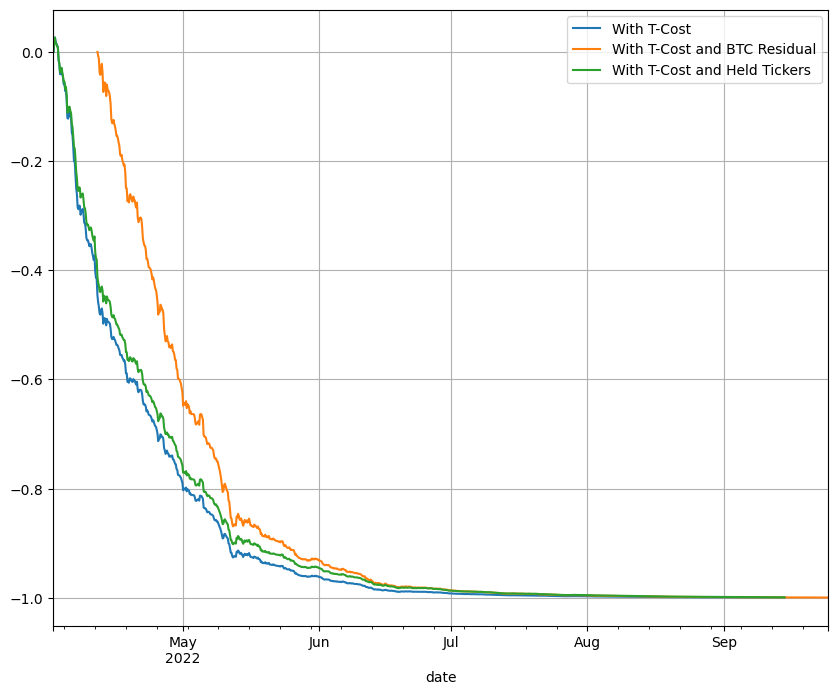

In [72]:
df_daily_portfolio_with_t_cost['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='With T-Cost', legend=True)
df_daily_portfolio_with_t_cost_btc_resid['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='With T-Cost and BTC Residual', legend=True)
df_daily_portfolio_with_t_cost_held_tickers['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='With T-Cost and Held Tickers', legend=True)

In [73]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_1, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 1,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.8740184109753152,
 'annualized_sharpe_ratio': -8.235723634981904,
 'calmar_ratio': -0.8769640695335038,
 'annualized_std_dev': 0.2529927159326858,
 'max_drawdown': -0.9966410726955375,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2862862862862863,
 't_statistic': -13.298272590945372,
 'p_value': 2.8645228902357404e-37,
 'trade_count': 999.0}

In [74]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_3, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 3,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.8151155856900743,
 'annualized_sharpe_ratio': -8.204729002568321,
 'calmar_ratio': -0.8230145743741509,
 'annualized_std_dev': 0.20866274325302617,
 'max_drawdown': -0.9904023708327603,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2902902902902903,
 't_statistic': -13.179328733759478,
 'p_value': 1.1016411578280889e-36,
 'trade_count': 999.0}

In [75]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_5, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 5,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.7555114411609621,
 'annualized_sharpe_ratio': -7.805789096162204,
 'calmar_ratio': -0.7714192466772836,
 'annualized_std_dev': 0.18428065089563347,
 'max_drawdown': -0.9793785213619692,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.2992992992992993,
 't_statistic': -12.468700753093984,
 'p_value': 2.8838971226788835e-33,
 'trade_count': 999.0}

In [76]:
## Backtest with Transaction Costs and Passive Trade Rate of 5%
df_daily_position_with_t_cost_held_tickers_cooldown_10, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=enable_fees, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 10,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.6429821733144083,
 'annualized_sharpe_ratio': -8.052187308329446,
 'calmar_ratio': -0.6826622084068296,
 'annualized_std_dev': 0.13276389879964182,
 'max_drawdown': -0.9418745689980043,
 'max_drawdown_duration': Timedelta('166 days 00:00:00'),
 'hit_rate': 0.28428428428428426,
 't_statistic': -12.706256991727667,
 'p_value': 2.149327361178077e-34,
 'trade_count': 999.0}

In [77]:
## Backtest with No Transaction Costs of Fees
df_daily_position_with_no_t_cost_held_tickers_cooldown_3, df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3 = run_mean_reversion_backtest_w_cooldown(df_signal, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
                                                                                                                                                     cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
                                                                                                                                                     passive_trade_rate=passive_trade_rate, enable_fees=False, signal_col='trade_signal_exec',
                                                                                                                                                     # ---------------- NEW toggles ----------------
                                                                                                                                                     enable_held_filter = True,          # block buying tickers already held elsewhere
                                                                                                                                                     enable_cooldown_filter = True,      # block re-entry after exit
                                                                                                                                                     cooldown_bars = 3,                    # number of bars to block after exit (incl. same bar)
                                                                                                                                                     # ---------------- other controls forwarded to open ----------------
                                                                                                                                                     max_names=None,
                                                                                                                                                     max_name_weight=0.05,
                                                                                                                                                     min_trade_notional_gross=0.0,
                                                                                                                                                     regime_filter_cols=None,
                                                                                                                                                     sort_col=None,
                                                                                                                                                     sort_ascending=True)

df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['daily_pct_returns'] = df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].pct_change()
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.16285560730183857,
 'annualized_sharpe_ratio': -0.9629250498535125,
 'calmar_ratio': -0.323962614320148,
 'annualized_std_dev': 0.21196406065857515,
 'max_drawdown': -0.5026987686329156,
 'max_drawdown_duration': Timedelta('163 days 20:00:00'),
 'hit_rate': 0.4844844844844845,
 't_statistic': -1.211797367735862,
 'p_value': 0.2258767810422575,
 'trade_count': 999.0}

<Axes: title={'center': 'Cumulative Returns'}, xlabel='date'>

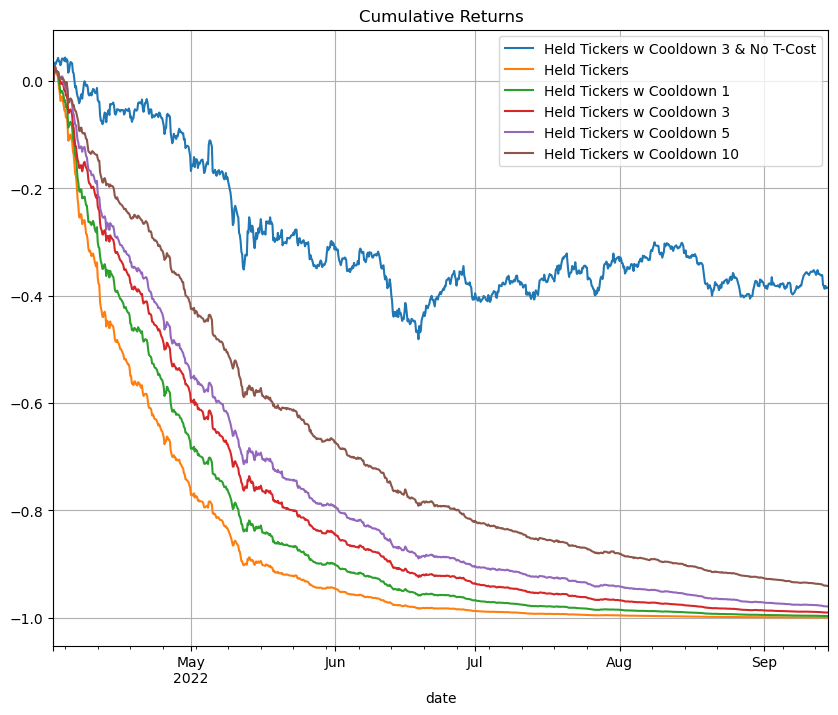

In [78]:
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 & No T-Cost', legend=True)
df_daily_portfolio_with_t_cost_held_tickers['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 1', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 5', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['strategy_cumulative_return'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 10', legend=True, title='Cumulative Returns')

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

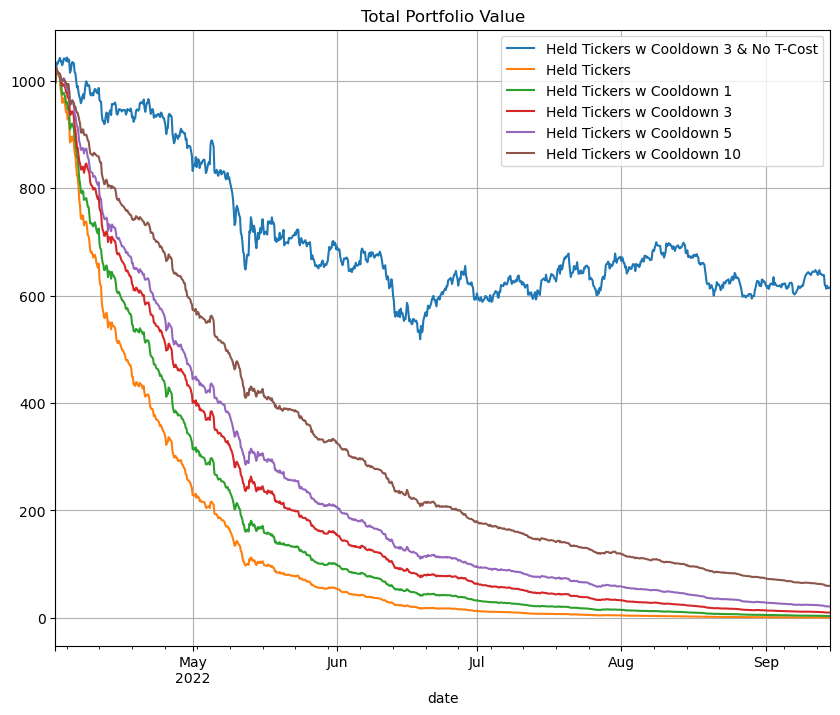

In [81]:
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 & No T-Cost', legend=True)
df_daily_portfolio_with_t_cost_held_tickers['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 1', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 5', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 10', legend=True, title='Total Portfolio Value')

## Average Forward Return by Decile

   signal_decile      mean       std      n     tstat
0              0  0.000571  0.041397  24164  2.143720
1              1  0.000351  0.034979  24145  1.560822
2              2  0.000167  0.033932  24167  0.764824
3              3  0.000113  0.033033  24076  0.531072
4              4 -0.000073  0.033050  24108 -0.343178
5              5 -0.000140  0.032702  24104 -0.666957
6              6 -0.000233  0.033267  24089 -1.084823
7              7 -0.000459  0.034635  24059 -2.056940
8              8 -0.000570  0.036960  24055 -2.391333
9              9 -0.002577  0.048375  24073 -8.266812


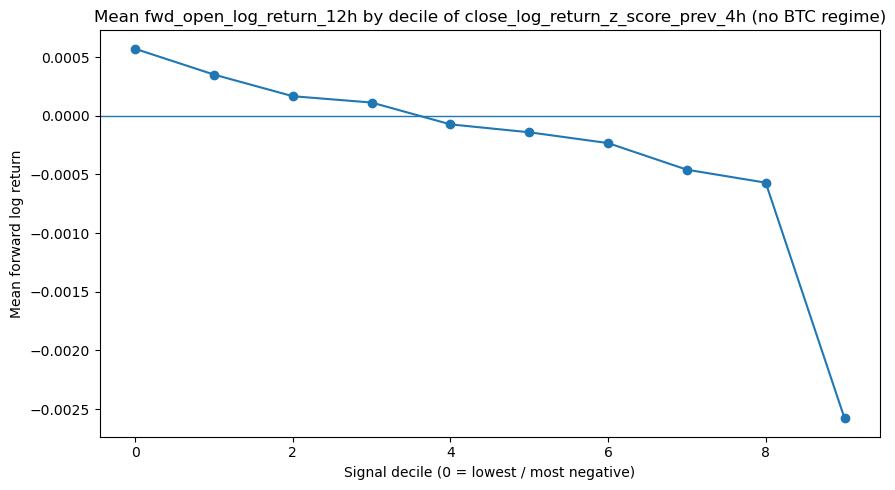

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def add_signal_deciles(
    df: pd.DataFrame,
    signal_col: str,
    date_col: str = "date",
    q: int = 10,
    decile_col: str = "signal_decile",
) -> pd.DataFrame:
    out = df.copy()

    def _qcut_safe(x: pd.Series) -> pd.Series:
        # qcut can fail when there are too many ties; duplicates="drop" helps
        try:
            return pd.qcut(x, q=q, labels=False, duplicates="drop")
        except ValueError:
            return pd.Series([np.nan] * len(x), index=x.index)

    out[decile_col] = out.groupby(date_col, group_keys=False)[signal_col].apply(_qcut_safe)
    return out


def decile_stats_overall(
    df: pd.DataFrame,
    fwd_ret_col: str,
    decile_col: str = "signal_decile",
) -> pd.DataFrame:
    d = df.dropna(subset=[decile_col, fwd_ret_col]).copy()
    d[decile_col] = d[decile_col].astype(int)

    g = d.groupby(decile_col)[fwd_ret_col]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"}).reset_index()
    stats["tstat"] = stats["mean"] / (stats["std"] / np.sqrt(stats["n"].clip(lower=1)))
    return stats.sort_values(decile_col)


def plot_decile_curve(stats_df: pd.DataFrame, title: str, decile_col: str = "signal_decile"):
    plt.figure(figsize=(9, 5))
    plt.plot(stats_df[decile_col], stats_df["mean"], marker="o")
    plt.axhline(0.0, linewidth=1)
    plt.title(title)
    plt.xlabel("Signal decile (0 = lowest / most negative)")
    plt.ylabel("Mean forward log return")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Run it
# -----------------------------
# Pick the columns you want to diagnose:
# signal_col = "resid_btc_zscore_prev_4h"   # or "close_log_return_z_score_prev_4h"
signal_col = "close_log_return_z_score_prev_4h"   # or "close_log_return_z_score_prev_4h"
fwd_ret_col = "fwd_open_log_return_12h"   # make sure this matches your df column name

df_diag = df_signal.copy()
df_diag["date"] = pd.to_datetime(df_diag["date"])

# Add deciles
df_diag = add_signal_deciles(df_diag, signal_col=signal_col, date_col="date", q=10, decile_col="signal_decile")

# Compute stats
stats_overall = decile_stats_overall(df_diag, fwd_ret_col=fwd_ret_col, decile_col="signal_decile")

print(stats_overall)

# Optional plot
plot_decile_curve(stats_overall, title=f"Mean {fwd_ret_col} by decile of {signal_col} (no BTC regime)")


In [84]:
d0 = stats_overall.loc[stats_overall["signal_decile"] == 0, "mean"].values
d9 = stats_overall.loc[stats_overall["signal_decile"] == stats_overall["signal_decile"].max(), "mean"].values

if len(d0) and len(d9):
    print(f"Decile0 - TopDecile mean fwd return spread: {float(d0[0] - d9[0]):.6f}")


Decile0 - TopDecile mean fwd return spread: 0.003148


In [85]:
stats_overall

signal_decile      mean       std      n     tstat
0              0  0.000571  0.041397  24164  2.143720
1              1  0.000351  0.034979  24145  1.560822
2              2  0.000167  0.033932  24167  0.764824
3              3  0.000113  0.033033  24076  0.531072
4              4 -0.000073  0.033050  24108 -0.343178
5              5 -0.000140  0.032702  24104 -0.666957
6              6 -0.000233  0.033267  24089 -1.084823
7              7 -0.000459  0.034635  24059 -2.056940
8              8 -0.000570  0.036960  24055 -2.391333
9              9 -0.002577  0.048375  24073 -8.266812

In [86]:
## Running Coin Level Diagnostics

def decile_stats_by_ticker(
    df: pd.DataFrame,
    fwd_ret_col: str,
    ticker_col: str = "ticker",
    decile_col: str = "signal_decile",
    min_n: int = 200,   # filter low-sample bins
) -> pd.DataFrame:
    """
    Returns stats by (ticker, decile): mean/std/n/tstat.
    Useful to see which coins dominate decile performance.
    """
    d = df.dropna(subset=[ticker_col, decile_col, fwd_ret_col]).copy()
    d[decile_col] = d[decile_col].astype(int)

    g = d.groupby([ticker_col, decile_col])[fwd_ret_col]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"}).reset_index()
    stats["tstat"] = stats["mean"] / (stats["std"] / np.sqrt(stats["n"].clip(lower=1)))

    # optional: drop tiny buckets to avoid noisy conclusions
    stats = stats[stats["n"] >= min_n].copy()
    return stats.sort_values([ticker_col, decile_col])


def summarize_decile_tail_contributors(
    stats_by_ticker: pd.DataFrame,
    decile: int,
    top_k: int = 10,
) -> pd.DataFrame:
    """
    For a given decile (e.g. 0 or 9), show tickers with largest absolute contribution signal
    in terms of mean return and sample size.
    """
    s = stats_by_ticker.loc[stats_by_ticker["signal_decile"] == decile].copy()
    # rank by |mean| first, tstat second (simple heuristic)
    s["abs_mean"] = s["mean"].abs()
    return s.sort_values(["abs_mean", "tstat"], ascending=[False, False]).head(top_k)


def ticker_level_spread(
    stats_by_ticker: pd.DataFrame,
    low_decile: int = 0,
    high_decile: int = 9,
) -> pd.DataFrame:
    """
    Computes per-ticker spread: mean(decile=low) - mean(decile=high).
    This tells you which tickers 'power' the cross-sectional spread.
    """
    a = stats_by_ticker.loc[stats_by_ticker["signal_decile"] == low_decile, ["ticker", "mean", "n"]].rename(
        columns={"mean": f"mean_d{low_decile}", "n": f"n_d{low_decile}"}
    )
    b = stats_by_ticker.loc[stats_by_ticker["signal_decile"] == high_decile, ["ticker", "mean", "n"]].rename(
        columns={"mean": f"mean_d{high_decile}", "n": f"n_d{high_decile}"}
    )
    m = a.merge(b, on="ticker", how="inner")
    m["spread"] = m[f"mean_d{low_decile}"] - m[f"mean_d{high_decile}"]
    return m.sort_values("spread", ascending=False)


In [87]:
# --- Coin-level diagnostics ---
stats_by_ticker = decile_stats_by_ticker(df_diag, fwd_ret_col=fwd_ret_col, ticker_col="ticker", decile_col="signal_decile", min_n=200)

# Who is driving the bottom decile (0) and top decile (9)?
print("\nTop contributors (by |mean|) in decile 0:")
print(summarize_decile_tail_contributors(stats_by_ticker, decile=0, top_k=15))

print("\nTop contributors (by |mean|) in decile 9:")
print(summarize_decile_tail_contributors(stats_by_ticker, decile=9, top_k=15))

# Per-ticker spread between decile 0 and 9
spread_by_ticker = ticker_level_spread(stats_by_ticker, low_decile=0, high_decile=9)
print("\nPer-ticker decile0 - decile9 spread (top 20):")
print(spread_by_ticker.head(20))

print("\nPer-ticker decile0 - decile9 spread (bottom 20):")
print(spread_by_ticker.tail(20))



Top contributors (by |mean|) in decile 0:
       ticker  signal_decile      mean       std     n     tstat  abs_mean
390   XTZ-USD              0 -0.007940  0.035710   276 -3.693723  0.007940
20    ADA-USD              0 -0.005372  0.037767   271 -2.341538  0.005372
100  COMP-USD              0  0.003611  0.035575   579  2.442300  0.003611
340   SOL-USD              0  0.003372  0.043304   558  1.839163  0.003372
290   REQ-USD              0 -0.003114  0.038512   693 -2.128309  0.003114
300  RNDR-USD              0  0.002587  0.048300  1209  1.862032  0.002587
170   FET-USD              0  0.002546  0.049650  1080  1.685259  0.002546
140  DOGE-USD              0  0.002545  0.042252   399  1.203149  0.002545
80    BAL-USD              0 -0.002283  0.030700   484 -1.635743  0.002283
30   AIOZ-USD              0  0.002195  0.053925  1555  1.605296  0.002195
90    BTC-USD              0  0.001877  0.021231   201  1.253335  0.001877
220   KRL-USD              0  0.001861  0.045141  1218  1

In [88]:
spread_by_ticker.head(20)

ticker   mean_d0  n_d0   mean_d9  n_d9    spread
5     AMP-USD  0.001589  1059 -0.009385   813  0.010974
0   1INCH-USD -0.000422   483 -0.010293   496  0.009871
3    AIOZ-USD  0.002195  1555 -0.006115  1334  0.008310
21    KRL-USD  0.001861  1218 -0.005786  1130  0.007648
10   COMP-USD  0.003611   579 -0.003800   600  0.007410
23    LRC-USD -0.001700   405 -0.008892   389  0.007192
25   MANA-USD  0.001247   294 -0.005751   322  0.006998
35  SUSHI-USD  0.001667   580 -0.003140   591  0.004807
27    OXT-USD -0.000616   795 -0.005176   726  0.004560
29   RNDR-USD  0.002587  1209 -0.001294  1119  0.003881
33    SOL-USD  0.003372   558 -0.000493   653  0.003865
16    FET-USD  0.002546  1080 -0.000976  1010  0.003522
28    REQ-USD -0.003114   693 -0.006602   648  0.003488
13    DIA-USD  0.000029   909 -0.003367   879  0.003395
19    ICP-USD  0.001551   605 -0.001627   622  0.003178
4    ALGO-USD  0.000228   410 -0.002918   447  0.003146
12    CRV-USD  0.001257   742 -0.001374   699  0.002630
34    STX-USD  0.001388   859 -0.001219   815  0.002607
24    LTC-USD -0.000410   365 -0.002877   484  0.002466
31    SKL-USD -0.001701   877 -0.003982   745  0.002282

In [89]:
df_diag.head()

ticker                date    low   high   open  close     volume  \
223149  1INCH-USD 2022-04-01 08:00:00  1.738  1.772  1.757  1.747   43729.16   
223150  1INCH-USD 2022-04-01 12:00:00  1.710  1.831  1.744  1.816  149897.91   
223151  1INCH-USD 2022-04-01 16:00:00  1.809  1.885  1.819  1.880  167483.50   
223152  1INCH-USD 2022-04-01 20:00:00  1.856  1.890  1.881  1.882  219778.94   
223153  1INCH-USD 2022-04-02 00:00:00  1.869  1.953  1.879  1.928  228449.80   

        imputed  close_log_return_prev_4h  close_log_return_z_score_prev_4h  \
223149    False                  0.027146                          0.152888   
223150    False                 -0.004569                          0.127891   
223151    False                  0.038736                         -0.044778   
223152    False                  0.034635                          0.904957   
223153    False                  0.001063                          0.306189   

        fwd_open_log_return_12h  quantile_bucket  bottom_quintile_signal  \
223149                 0.068196                7                   False   
223150                 0.074558                6                   False   
223151                 0.058196                5                   False   
223152                 0.019479                8                   False   
223153                 0.070872                6                   False   

        trade_signal  trade_signal_exec  signal_decile  
223149           0.0                0.0              7  
223150           0.0                0.0              6  
223151           0.0                0.0              5  
223152           0.0                0.0              8  
223153           0.0                0.0              6

## Run Large vs Small Liquidity Diagnostic Across Universe

In [93]:
def add_liquidity_proxy_and_bucket(
    df: pd.DataFrame,
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    volume_col: str = "volume",         # optional; if missing we'll fall back
    ret_col_for_vol: str = "close_log_return_prev_4h",
    bars_per_day: int = 6,
    window_days: int = 30,
    top_n: int = 15,
    lag_bars: int = 1,
    bucket_col: str = "cap_bucket",
) -> pd.DataFrame:
    """
    Creates a 'large vs small' bucket.
    - Preferred: rolling $-volume (close*volume) if volume exists.
    - Fallback: rolling realized vol (higher vol => 'small/noisy') if volume not available.

    Bucket assignment is done *per timestamp* using only past info (lagged).
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.sort_values([ticker_col, date_col])

    window_bars = int(window_days * bars_per_day)

    has_volume = volume_col in out.columns and out[volume_col].notna().any()

    if has_volume:
        out["dollar_vol"] = out[close_col].astype(float) * out[volume_col].astype(float)
        out["liq_proxy"] = (
            out.groupby(ticker_col)["dollar_vol"]
               .rolling(window_bars, min_periods=max(10, window_bars // 3))
               .mean()
               .reset_index(level=0, drop=True)
        )
        # no-lookahead
        out["liq_proxy"] = out.groupby(ticker_col)["liq_proxy"].shift(lag_bars)
        # larger liq_proxy => more "large-cap-like"
        proxy_col = "liq_proxy"
        ascending = False  # rank high first
    else:
        # fallback: realized vol; lower vol => more "large-cap-like"
        out["vol_proxy"] = (
            out.groupby(ticker_col)[ret_col_for_vol]
               .rolling(window_bars, min_periods=max(10, window_bars // 3))
               .std()
               .reset_index(level=0, drop=True)
        )
        out["vol_proxy"] = out.groupby(ticker_col)["vol_proxy"].shift(lag_bars)
        proxy_col = "vol_proxy"
        ascending = True   # rank low first

    # assign bucket per timestamp
    def _bucket_one_timestamp(g: pd.DataFrame) -> pd.DataFrame:
        gg = g.copy()
        gg["rank"] = gg[proxy_col].rank(method="first", ascending=ascending)
        gg[bucket_col] = np.where(gg["rank"] <= top_n, "LARGE", "SMALL")
        return gg.drop(columns=["rank"])

    out = out.groupby(date_col, group_keys=False).apply(_bucket_one_timestamp)
    return out


def decile_stats_by_bucket(
    df: pd.DataFrame,
    fwd_ret_col: str,
    bucket_col: str,
    decile_col: str = "signal_decile",
) -> pd.DataFrame:
    d = df.dropna(subset=[bucket_col, decile_col, fwd_ret_col]).copy()
    d[decile_col] = d[decile_col].astype(int)

    g = d.groupby([bucket_col, decile_col])[fwd_ret_col]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"}).reset_index()
    stats["tstat"] = stats["mean"] / (stats["std"] / np.sqrt(stats["n"].clip(lower=1)))
    return stats.sort_values([bucket_col, decile_col])


def plot_decile_curves_by_bucket(stats_df: pd.DataFrame, bucket_col: str, title: str, decile_col: str = "signal_decile"):
    plt.figure(figsize=(10, 6))
    for b, g in stats_df.groupby(bucket_col):
        g = g.sort_values(decile_col)
        plt.plot(g[decile_col], g["mean"], marker="o", label=str(b))
    plt.axhline(0.0, linewidth=1)
    plt.title(title)
    plt.xlabel("Signal decile (0 = lowest / most negative)")
    plt.ylabel("Mean forward log return")
    plt.legend()
    plt.tight_layout()
    plt.show()


   cap_bucket  signal_decile      mean       std      n     tstat
0       LARGE              0  0.000035  0.036459  11937  0.105267
1       LARGE              1  0.000412  0.034195   5972  0.932217
2       LARGE              2 -0.000212  0.031237  11929 -0.742622
3       LARGE              3  0.000253  0.031378   5975  0.623520
4       LARGE              4 -0.000281  0.030887  11928 -0.993676
5       LARGE              5  0.000483  0.031690   5965  1.177141
6       LARGE              6  0.000068  0.031283   5972  0.167041
7       LARGE              7 -0.000238  0.032473  11923 -0.801083
8       LARGE              8 -0.000586  0.033074   5969 -1.367937
9       LARGE              9 -0.000714  0.040438  11920 -1.927104
10      SMALL              0  0.000853  0.042104  18190  2.731494
11      SMALL              1  0.000401  0.036054  12248  1.229876
12      SMALL              2  0.000209  0.034799  18182  0.807948
13      SMALL              3  0.000059  0.034270  12175  0.190783
14      SM

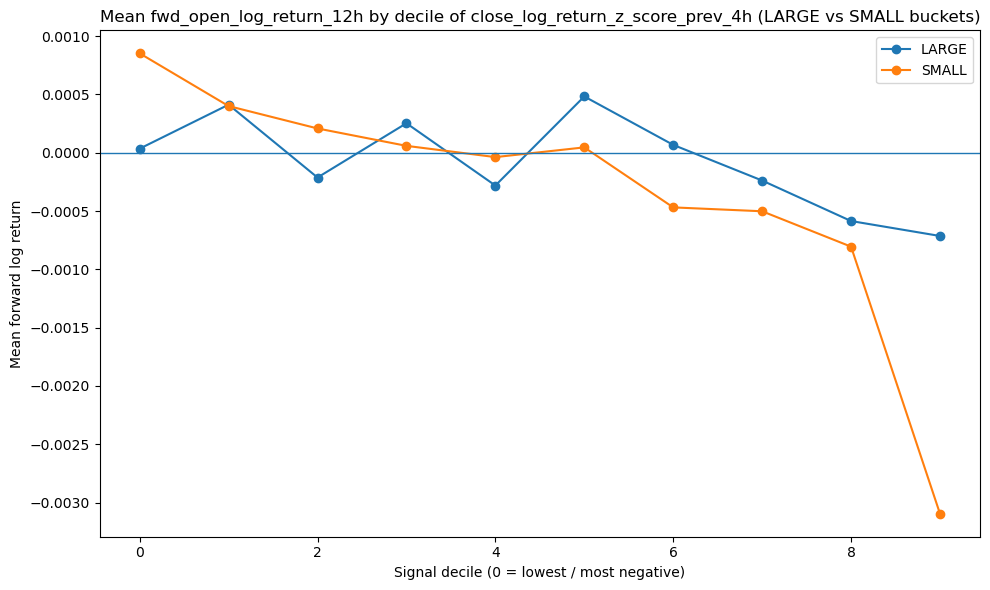


Decile0 - Decile9 spread by bucket:
cap_bucket
SMALL    0.003949
LARGE    0.000749
dtype: float64


In [94]:
signal_col = "close_log_return_z_score_prev_4h"
fwd_ret_col = "fwd_open_log_return_12h"

df_diag = df_signal.copy()
df_diag["date"] = pd.to_datetime(df_diag["date"])

# (A) Add LARGE/SMALL bucket (uses volume if present; else realized-vol proxy)
df_diag = add_liquidity_proxy_and_bucket(
    df_diag,
    date_col="date",
    ticker_col="ticker",
    close_col="close",
    volume_col="volume",                 # ok if missing
    ret_col_for_vol="close_log_return_prev_4h",
    bars_per_day=6,
    window_days=30,
    top_n=15,
    lag_bars=1,
    bucket_col="cap_bucket",
)

# (B) Run decile diagnostic separately by bucket:
#     Important: recompute deciles WITHIN each bucket each timestamp
df_bucket = df_diag.dropna(subset=["cap_bucket"]).copy()
df_bucket["signal_decile"] = (
    df_bucket.groupby(["date", "cap_bucket"], group_keys=False)[signal_col]
             .apply(lambda s: pd.qcut(s, q=10, labels=False, duplicates="drop"))
)

stats_bucket = decile_stats_by_bucket(df_bucket, fwd_ret_col=fwd_ret_col, bucket_col="cap_bucket", decile_col="signal_decile")
print(stats_bucket)

plot_decile_curves_by_bucket(
    stats_bucket,
    bucket_col="cap_bucket",
    title=f"Mean {fwd_ret_col} by decile of {signal_col} (LARGE vs SMALL buckets)"
)

# Optional: spread per bucket (D0 - D9)
spread_bucket = (
    stats_bucket.pivot(index="signal_decile", columns="cap_bucket", values="mean")
)
if 0 in spread_bucket.index and 9 in spread_bucket.index:
    print("\nDecile0 - Decile9 spread by bucket:")
    print((spread_bucket.loc[0] - spread_bucket.loc[9]).sort_values(ascending=False))


In [95]:
df_diag.head()

ticker                date    low   high   open  close     volume  \
223149  1INCH-USD 2022-04-01 08:00:00  1.738  1.772  1.757  1.747   43729.16   
223150  1INCH-USD 2022-04-01 12:00:00  1.710  1.831  1.744  1.816  149897.91   
223151  1INCH-USD 2022-04-01 16:00:00  1.809  1.885  1.819  1.880  167483.50   
223152  1INCH-USD 2022-04-01 20:00:00  1.856  1.890  1.881  1.882  219778.94   
223153  1INCH-USD 2022-04-02 00:00:00  1.869  1.953  1.879  1.928  228449.80   

        imputed  close_log_return_prev_4h  close_log_return_z_score_prev_4h  \
223149    False                  0.027146                          0.152888   
223150    False                 -0.004569                          0.127891   
223151    False                  0.038736                         -0.044778   
223152    False                  0.034635                          0.904957   
223153    False                  0.001063                          0.306189   

        fwd_open_log_return_12h  quantile_bucket  bottom_quintile_signal  \
223149                 0.068196                7                   False   
223150                 0.074558                6                   False   
223151                 0.058196                5                   False   
223152                 0.019479                8                   False   
223153                 0.070872                6                   False   

        trade_signal  trade_signal_exec    dollar_vol  liq_proxy cap_bucket  
223149           0.0                0.0   76394.84252        NaN      SMALL  
223150           0.0                0.0  272214.60456        NaN      SMALL  
223151           0.0                0.0  314868.98000        NaN      SMALL  
223152           0.0                0.0  413623.96508        NaN      SMALL  
223153           0.0                0.0  440451.21440        NaN      SMALL

In [96]:
df_diag[df_diag['date'] == pd.Timestamp('2022-04-20 12:00:00')].sort_values(['quantile_bucket'])

ticker                date           low          high  \
150892   AIOZ-USD 2022-04-20 12:00:00      0.203000      0.211100   
162954    KRL-USD 2022-04-20 12:00:00      0.840400      0.853800   
217233    BAL-USD 2022-04-20 12:00:00     15.650000     16.270000   
96613     LRC-USD 2022-04-20 12:00:00      0.974700      1.022300   
102644    STX-USD 2022-04-20 12:00:00      1.170000      1.220000   
114706   SHIB-USD 2022-04-20 12:00:00      0.000025      0.000026   
30272     DOT-USD 2022-04-20 12:00:00     18.890000     19.530000   
108675   DOGE-USD 2022-04-20 12:00:00      0.140500      0.146100   
229295   MANA-USD 2022-04-20 12:00:00      2.110000      2.212000   
120737   LINK-USD 2022-04-20 12:00:00     13.840000     14.490000   
54396     XLM-USD 2022-04-20 12:00:00      0.200410      0.206217   
42334     LTC-USD 2022-04-20 12:00:00    110.750000    113.960000   
78520     FIL-USD 2022-04-20 12:00:00     19.550000     20.610000   
36303    ATOM-USD 2022-04-20 12:00:00     24.170000     25.100000   
138830   RNDR-USD 2022-04-20 12:00:00      2.040000      2.210000   
66458     CRO-USD 2022-04-20 12:00:00      0.410000      0.424100   
144861    OXT-USD 2022-04-20 12:00:00      0.239800      0.250100   
235326    REQ-USD 2022-04-20 12:00:00      0.217300      0.227600   
223264  1INCH-USD 2022-04-20 12:00:00      1.522000      1.591000   
72489     XTZ-USD 2022-04-20 12:00:00      3.120000      3.280000   
90582     IMX-USD 2022-04-20 12:00:00      1.953000      2.119000   
205171  SUSHI-USD 2022-04-20 12:00:00      3.270000      3.460000   
117       BTC-USD 2022-04-20 12:00:00  41055.840000  42197.100000   
84551     SKL-USD 2022-04-20 12:00:00      0.196700      0.209900   
60427     ICP-USD 2022-04-20 12:00:00     17.000000     17.810000   
6148      ETH-USD 2022-04-20 12:00:00   3051.020000   3163.730000   
126768    FET-USD 2022-04-20 12:00:00      0.336400      0.352800   
48365    ALGO-USD 2022-04-20 12:00:00      0.732700      0.771400   
168985    UNI-USD 2022-04-20 12:00:00      9.200000      9.700000   
211202    CRV-USD 2022-04-20 12:00:00      2.312000      2.418000   
24241    AVAX-USD 2022-04-20 12:00:00     77.790000     81.330000   
18210     ADA-USD 2022-04-20 12:00:00      0.941700      0.975500   
12179     SOL-USD 2022-04-20 12:00:00    104.690000    110.800000   
181047    AMP-USD 2022-04-20 12:00:00      0.022150      0.023080   
193109    MKR-USD 2022-04-20 12:00:00   1792.130000   1915.270000   
156923    DIA-USD 2022-04-20 12:00:00      0.910000      0.970000   
175016   AAVE-USD 2022-04-20 12:00:00    185.250000    198.800000   
187078   COMP-USD 2022-04-20 12:00:00    143.160000    149.170000   
199140    SNX-USD 2022-04-20 12:00:00      6.377000      7.191000   
132799    GRT-USD 2022-04-20 12:00:00      0.364200      0.379800   

                open         close        volume  imputed  \
150892      0.209100      0.203000  1.962864e+05    False   
162954      0.847600      0.840400  6.221960e+04    False   
217233     16.210000     15.740000  4.898333e+04    False   
96613       1.017100      0.980400  4.938450e+06    False   
102644      1.220000      1.180000  6.872038e+04    False   
114706      0.000026      0.000025  6.003581e+11    False   
30272      19.290000     19.090000  1.560755e+05    False   
108675      0.145900      0.141500  3.639257e+07    False   
229295      2.209000      2.122000  1.196757e+06    False   
120737     14.440000     13.930000  2.711051e+05    False   
54396       0.205660      0.201661  2.057796e+07    False   
42334     113.870000    111.760000  2.929387e+04    False   
78520      20.500000     19.710000  1.221321e+05    False   
36303      25.050000     24.300000  1.087830e+05    False   
138830      2.190000      2.060000  6.354257e+04    False   
66458       0.423400      0.413300  2.689029e+06    False   
144861      0.250100      0.243700  2.732639e+06    False   
235326      0.227200      0.219000  9.752600e+05    False   
223264      1.567000  

## Plotting Decile Time Series for Large vs Small

In [98]:
def build_decile_return_timeseries(
    df: pd.DataFrame,
    signal_col: str,
    fwd_ret_col: str,
    date_col: str = "date",
    q: int = 10,
    decile_col: str = "signal_decile",
    group_cols: list = None,   # e.g. ["cap_bucket"] or None
) -> pd.DataFrame:
    """
    Returns a time series DataFrame indexed by date with columns:
      - decile_0 ... decile_{q-1}
      - spread_d0_d{q-1}
    If group_cols is provided, returns a MultiIndex columns (group, decile_k).
    """
    d = df.dropna(subset=[date_col, signal_col, fwd_ret_col]).copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # assign deciles cross-sectionally (optionally within bucket each timestamp)
    if group_cols:
        d[decile_col] = (
            d.groupby([date_col] + group_cols, group_keys=False)[signal_col]
             .apply(lambda s: pd.qcut(s, q=q, labels=False, duplicates="drop"))
        )
        d = d.dropna(subset=[decile_col])
        d[decile_col] = d[decile_col].astype(int)

        # average forward returns by (date, group, decile)
        ts = (
            d.groupby([date_col] + group_cols + [decile_col])[fwd_ret_col]
             .mean()
             .reset_index()
        )

        # pivot to wide
        ts_wide = ts.pivot_table(index=date_col, columns=group_cols + [decile_col], values=fwd_ret_col)
        # rename decile level to decile_k
        ts_wide.columns = pd.MultiIndex.from_tuples(
            [(g, f"decile_{k}") for g, k in ts_wide.columns],
            names=group_cols + ["decile"]
        )

        # compute spread per group
        for g in ts[group_cols[0]].unique():
            if (g, "decile_0") in ts_wide.columns and (g, f"decile_{q-1}") in ts_wide.columns:
                ts_wide[(g, f"spread_d0_d{q-1}")] = ts_wide[(g, "decile_0")] - ts_wide[(g, f"decile_{q-1}")]

        ts_wide = ts_wide.sort_index()
        return ts_wide

    else:
        d[decile_col] = (
            d.groupby(date_col, group_keys=False)[signal_col]
             .apply(lambda s: pd.qcut(s, q=q, labels=False, duplicates="drop"))
        )
        d = d.dropna(subset=[decile_col])
        d[decile_col] = d[decile_col].astype(int)

        ts = (
            d.groupby([date_col, decile_col])[fwd_ret_col]
             .mean()
             .unstack(decile_col)
             .sort_index()
        )
        ts.columns = [f"decile_{c}" for c in ts.columns]

        if "decile_0" in ts.columns and f"decile_{q-1}" in ts.columns:
            ts[f"spread_d0_d{q-1}"] = ts["decile_0"] - ts[f"decile_{q-1}"]

        return ts


def cumulate_log_returns(x: pd.Series) -> pd.Series:
    # if forward returns are log returns, cumulative log return is cumsum
    return x.cumsum()


def plot_cumulative_curves(ts: pd.DataFrame, cols: list, title: str):
    plt.figure(figsize=(11, 6))
    for c in cols:
        if c in ts.columns:
            plt.plot(ts.index, cumulate_log_returns(ts[c]), label=c)
    plt.axhline(0.0, linewidth=1)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


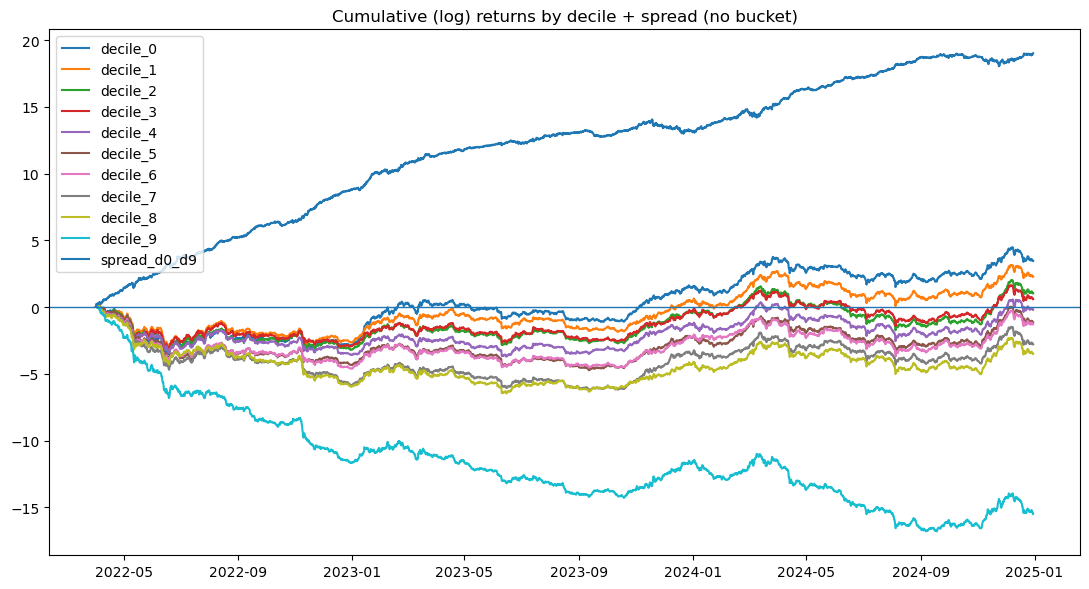

In [99]:
signal_col = "close_log_return_z_score_prev_4h"
fwd_ret_col = "fwd_open_log_return_12h"

ts = build_decile_return_timeseries(
    df=df_diag,
    signal_col=signal_col,
    fwd_ret_col=fwd_ret_col,
    date_col="date",
    q=10,
    group_cols=None
)

decile_cols = ["decile_0", "decile_1", "decile_2", "decile_3", "decile_4", "decile_5", "decile_6", "decile_7", "decile_8", "decile_9", "spread_d0_d9"]
plot_cumulative_curves(
    ts,
    cols=decile_cols,
    title=f"Cumulative (log) returns by decile + spread (no bucket)"
)


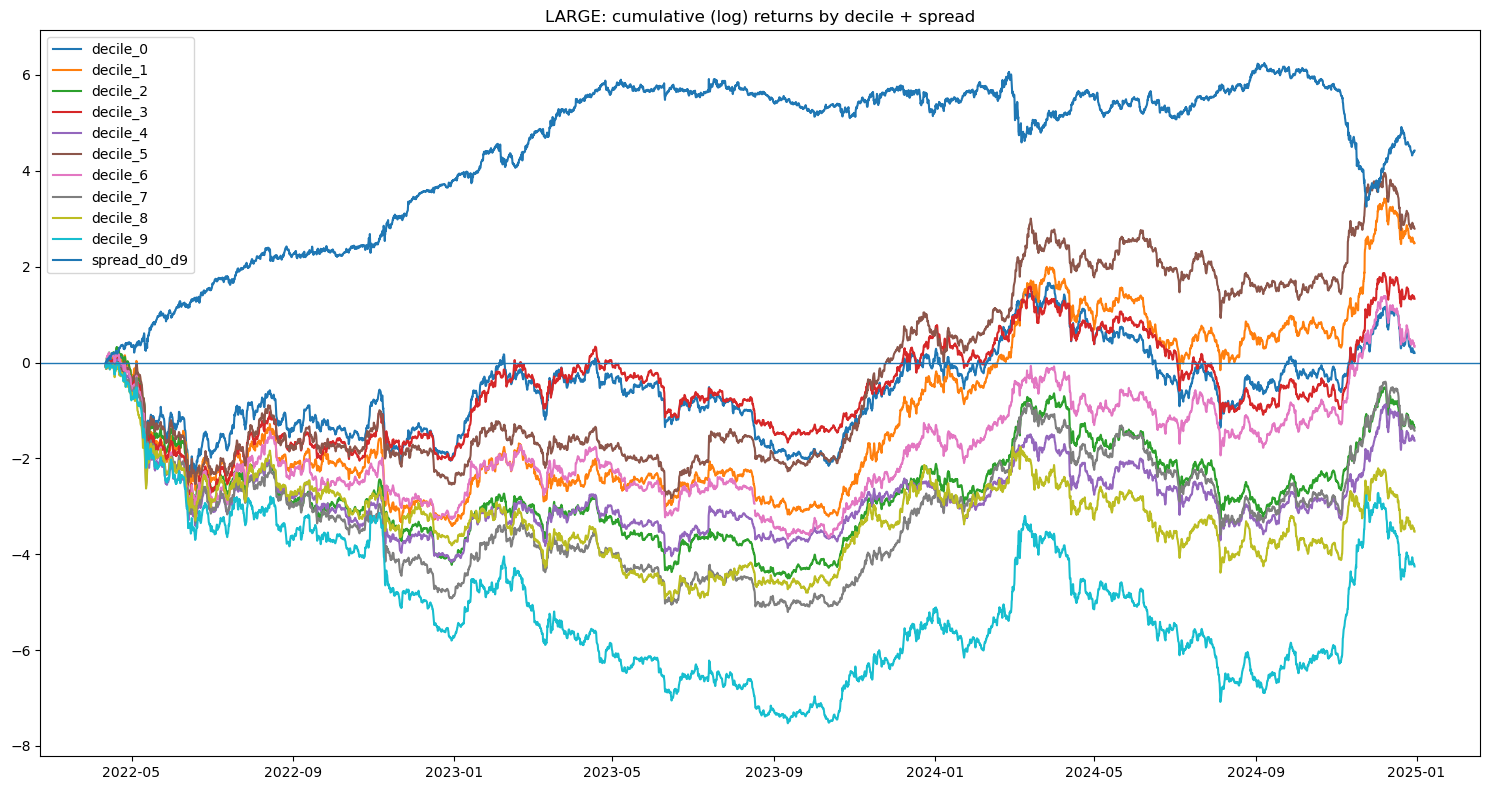

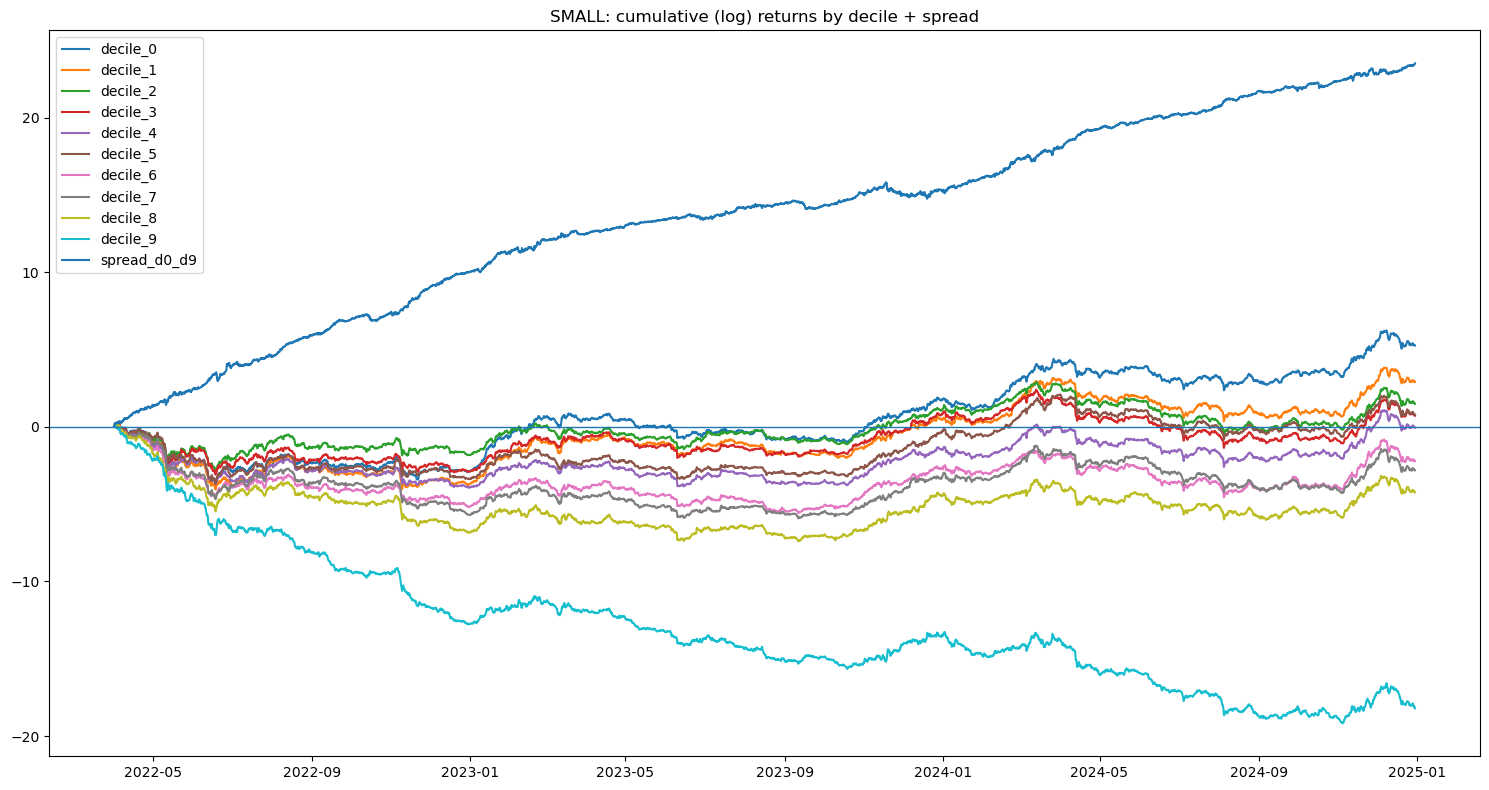

In [100]:
ts_bucket = build_decile_return_timeseries(
    df=df_diag.dropna(subset=["cap_bucket"]),
    signal_col=signal_col,
    fwd_ret_col=fwd_ret_col,
    date_col="date",
    q=10,
    group_cols=["cap_bucket"]
)

# Plot for each bucket separately
decile_cols = ["decile_0", "decile_1", "decile_2", "decile_3", "decile_4", "decile_5", "decile_6", "decile_7", "decile_8", "decile_9", "spread_d0_d9"]
for bucket in ["LARGE", "SMALL"]:
    cols = [(bucket, col) for col in decile_cols]
    # cols = [(bucket, "decile_0"), (bucket, "decile_1"), (bucket, "decile_8"), (bucket, "decile_9"), (bucket, "spread_d0_d9")]
    # keep only those that exist
    cols = [c for c in cols if c in ts_bucket.columns]
    plt.figure(figsize=(15, 8))
    for c in cols:
        plt.plot(ts_bucket.index, ts_bucket[c].cumsum(), label=str(c[1]))
    plt.axhline(0.0, linewidth=1)
    plt.title(f"{bucket}: cumulative (log) returns by decile + spread")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Testing Performance of Only Small Universe with Backtesting Engine

In [129]:
def add_liquidity_proxy_and_bucket(
    df: pd.DataFrame,
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    volume_col: str = "volume",         # optional; if missing we'll fall back
    ret_col_for_vol: str = "close_log_return_prev_4h",
    bars_per_day: int = 6,
    window_days: int = 30,
    top_n: int = 15,
    lag_bars: int = 1,
    bucket_col: str = "cap_bucket",
) -> pd.DataFrame:
    """
    Creates a 'large vs small' bucket per timestamp using only past info (lagged).

    - Preferred: rolling $-volume (close*volume) if volume exists.
    - Fallback: rolling realized vol; lower vol => more "large-cap-like".

    Robustness:
      - If proxy is NaN for a timestamp/ticker, bucket stays NaN (not forced to SMALL).
      - top_n is clamped to available valid proxies for that timestamp.
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col])
    out = out.sort_values([ticker_col, date_col])

    window_bars = int(window_days * bars_per_day)
    min_periods = max(10, window_bars // 3)

    has_volume = volume_col in out.columns and out[volume_col].notna().any()

    if has_volume:
        out["dollar_vol"] = out[close_col].astype(float) * out[volume_col].astype(float)
        out["liq_proxy"] = (
            out.groupby(ticker_col)["dollar_vol"]
               .rolling(window_bars, min_periods=min_periods)
               .mean()
               .reset_index(level=0, drop=True)
        )
        # no-lookahead
        out["liq_proxy"] = out.groupby(ticker_col)["liq_proxy"].shift(lag_bars)
        proxy_col = "liq_proxy"
        ascending = False  # rank high first
    else:
        if ret_col_for_vol not in out.columns:
            raise ValueError(
                f"Missing '{volume_col}' and fallback '{ret_col_for_vol}' not found. "
                "Compute returns first (e.g., close_log_return_prev_4h) or provide volume."
            )

        out["vol_proxy"] = (
            out.groupby(ticker_col)[ret_col_for_vol]
               .rolling(window_bars, min_periods=min_periods)
               .std()
               .reset_index(level=0, drop=True)
        )
        out["vol_proxy"] = out.groupby(ticker_col)["vol_proxy"].shift(lag_bars)
        proxy_col = "vol_proxy"
        ascending = True   # rank low first

    def _bucket_one_timestamp(g: pd.DataFrame) -> pd.DataFrame:
        gg = g.copy()

        valid = gg[proxy_col].notna()
        gg[bucket_col] = np.nan  # default (keeps early history clean)

        if valid.sum() == 0:
            return gg

        # rank only valid rows
        gg.loc[valid, "rank"] = gg.loc[valid, proxy_col].rank(method="first", ascending=ascending)

        top_n_eff = int(min(int(top_n), int(valid.sum())))
        gg.loc[valid, bucket_col] = np.where(gg.loc[valid, "rank"] <= top_n_eff, "LARGE", "SMALL")

        return gg.drop(columns=["rank"], errors="ignore")

    out = out.groupby(date_col, group_keys=False).apply(_bucket_one_timestamp)
    return out


In [170]:
def get_mean_reversion_signal(
    df_ohlc: pd.DataFrame,
    min_z_score_ticker_count: int = 20,
    fwd_return_period: int = 3,
    winsorize_fwd_return: bool = True,
    fwd_return_cap: float = 0.50,
    bottom_q: float = 0.2,
    # ---------------- universe selection ----------------
    universe: str = "ALL",  # "SMALL" | "LARGE" | "ALL"
    # ---------------- liquidity bucket params ----------------
    bars_per_day: int = 6,
    liq_window_days: int = 30,
    liq_top_n_large: int = 15,
    liq_lag_bars: int = 1,
    bucket_col: str = "cap_bucket",
    # ---------------- schema ----------------
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    open_col: str = "open",
    volume_col: str = "volume",
):
    """
    Mean reversion signal:
      - Compute returns/features on ALL coins
      - Compute cross-sectional Z-score on ALL coins each bar (GLOBAL Z)
      - Identify bottom_q losers globally
      - Trade only the selected universe (SMALL/LARGE/ALL) among those losers
      - Signal computed on bar close, executed next bar open (shift 1)

    Notes:
      - Liquidity bucket is computed with lag (no lookahead).
      - We drop early-history rows where bucket is unknown (proxy NaN).
      - min_z_score_ticker_count is applied globally to stabilize Z-score computation.
      - Quantile bucket uses transform (robust) rather than groupby.apply assignment.
    """
    df = df_ohlc.copy()

    # -----------------------------
    # Build return features on ALL coins (no universe filtering yet)
    # -----------------------------
    df_signal = build_return_features(
        df,
        min_z_score_ticker_count=1,  # defer min count until after bucketing
        fwd_return_period=fwd_return_period,
        winsorize_fwd_return=winsorize_fwd_return,
        fwd_return_cap=fwd_return_cap,
    )

    # -----------------------------
    # Liquidity proxy + LARGE/SMALL buckets (lagged, no lookahead)
    # -----------------------------
    df_signal = add_liquidity_proxy_and_bucket(
        df_signal,
        date_col=date_col,
        ticker_col=ticker_col,
        close_col=close_col,
        volume_col=volume_col,
        ret_col_for_vol="close_log_return_prev_4h",
        bars_per_day=bars_per_day,
        window_days=liq_window_days,
        top_n=liq_top_n_large,
        lag_bars=liq_lag_bars,
        bucket_col=bucket_col,
    )

    # Drop rows where bucket is unknown (early history / insufficient proxy)
    df_signal = df_signal.dropna(subset=[bucket_col]).copy()

    # -----------------------------
    # Enforce GLOBAL min ticker count per bar (across ALL coins)
    # -----------------------------
    ticker_count_by_date_all = df_signal.groupby(date_col)[ticker_col].transform("nunique")
    df_signal = df_signal[ticker_count_by_date_all >= int(min_z_score_ticker_count)].copy()

    # -----------------------------
    # Compute GLOBAL cross-sectional z-score (across ALL coins)
    # -----------------------------
    df_signal = calculate_z_score(
        df_signal,
        return_col="close_log_return_prev_4h",
        date_col=date_col,
        z_score_col_name="close_log_return_z_score_prev_4h",
    )

    # -----------------------------
    # Drop NA rows needed for signal/label work
    # -----------------------------
    fwd_col = f"fwd_open_log_return_{fwd_return_period * 4}h"
    req_cols = ["close_log_return_prev_4h", fwd_col, "close_log_return_z_score_prev_4h", open_col]
    df_signal = df_signal.dropna(subset=req_cols).copy()

    # -----------------------------
    # Quantile buckets (diagnostic) - robust transform-based
    # -----------------------------
    def _cs_bucket_series(s: pd.Series, q: int = 10) -> pd.Series:
        s = pd.Series(s).astype(float)
        nn = int(s.notna().sum())
        if nn < 2 or s.nunique(dropna=True) < 2:
            return pd.Series(np.nan, index=s.index)
        q_eff = min(int(q), nn)  # helpful when universe is small / sparse
        try:
            return pd.qcut(s, q=q_eff, labels=False, duplicates="drop")
        except ValueError:
            return pd.Series(np.nan, index=s.index)

    df_signal["quantile_bucket"] = (
        df_signal.groupby(date_col)["close_log_return_z_score_prev_4h"]
                 .transform(lambda s: _cs_bucket_series(s, q=10))
    )

    # -----------------------------
    # Bottom-q selection computed GLOBALLY
    # -----------------------------
    q = float(bottom_q)
    df_signal["bottom_quintile_global"] = df_signal.groupby(date_col)["close_log_return_z_score_prev_4h"].transform(
        lambda s: s <= s.quantile(q)
    )

    # -----------------------------
    # Trade universe constraint applied AFTER global selection
    # -----------------------------
    universe_u = str(universe).upper().strip()
    if universe_u in {"SMALL", "LARGE"}:
        df_signal["bottom_quintile_signal"] = (
            df_signal["bottom_quintile_global"] & (df_signal[bucket_col] == universe_u)
        )
    elif universe_u == "ALL":
        df_signal["bottom_quintile_signal"] = df_signal["bottom_quintile_global"]
    else:
        raise ValueError("universe must be one of: 'ALL', 'SMALL', 'LARGE'")

    # -----------------------------
    # compute signal on bar close, execute next bar open (shift by 1 bar)
    # -----------------------------
    df_signal = df_signal.sort_values([ticker_col, date_col])
    df_signal["trade_signal"] = df_signal["bottom_quintile_signal"].astype(float)

    df_signal["trade_signal_exec"] = (
        df_signal.groupby(ticker_col)["trade_signal"]
                 .shift(1)
                 .fillna(0.0)
                 .astype(float)
    )

    return df_signal


In [172]:
df_ohlc = df_ticker_price_impute.copy()

# SMALL-only signals
sig_small = get_mean_reversion_signal(df_ohlc, universe="SMALL", liq_top_n_large=15)

# LARGE-only signals
sig_large = get_mean_reversion_signal(df_ohlc, universe="LARGE", liq_top_n_large=15)

# ALL coins (original behavior, but now with bucket labels included)
sig_all = get_mean_reversion_signal(df_ohlc, universe="ALL", liq_top_n_large=15)


In [182]:
sig_small[sig_small['date'] == pd.Timestamp('2022-04-11 00:00:00')].sort_values('quantile_bucket')

ticker       date           low          high          open  \
174959   AAVE-USD 2022-04-11    171.210000    178.140000    176.370000   
84494     SKL-USD 2022-04-11      0.190900      0.203000      0.194200   
162897    KRL-USD 2022-04-11      0.938900      1.018000      0.995500   
126711    FET-USD 2022-04-11      0.363600      0.380200      0.375900   
205114  SUSHI-USD 2022-04-11      3.300000      3.430000      3.390000   
90525     IMX-USD 2022-04-11      1.983000      2.092000      2.042000   
60370     ICP-USD 2022-04-11     16.940000     17.530000     17.340000   
108618   DOGE-USD 2022-04-11      0.144800      0.151500      0.148300   
132742    GRT-USD 2022-04-11      0.371800      0.386400      0.384100   
144804    OXT-USD 2022-04-11      0.261200      0.268200      0.265700   
217176    BAL-USD 2022-04-11     16.560000     17.280000     16.960000   
30215     DOT-USD 2022-04-11     18.740000     19.290000     19.220000   
72432     XTZ-USD 2022-04-11      3.050000      3.150000      3.130000   
187021   COMP-USD 2022-04-11    128.990000    134.030000    133.980000   
24184    AVAX-USD 2022-04-11     78.170000     81.530000     80.980000   
48308    ALGO-USD 2022-04-11      0.739000      0.757100      0.750700   
223207  1INCH-USD 2022-04-11      1.547000      1.603000      1.588000   
102587    STX-USD 2022-04-11      1.200000      1.240000      1.220000   
120680   LINK-USD 2022-04-11     14.790000     15.280000     15.240000   
96556     LRC-USD 2022-04-11      0.919200      0.965000      0.961100   
168928    UNI-USD 2022-04-11      9.630000      9.890000      9.880000   
199083    SNX-USD 2022-04-11      4.929000      5.139000      5.087000   
235269    REQ-USD 2022-04-11      0.235000      0.240300      0.239500   
193052    MKR-USD 2022-04-11   1990.120000   2036.240000   2015.040000   
18153     ADA-USD 2022-04-11      1.001400      1.032900      1.027400   
78463     FIL-USD 2022-04-11     20.320000     21.070000     20.980000   
138773   RNDR-USD 2022-04-11      2.370000      2.470000      2.470000   
211145    CRV-USD 2022-04-11      2.348000      2.447000      2.406000   
12122     SOL-USD 2022-04-11    108.350000    111.990000    111.050000   
229238   MANA-USD 2022-04-11      2.205000      2.283000      2.265000   
54339     XLM-USD 2022-04-11      0.196094      0.201127      0.200361   
42277     LTC-USD 2022-04-11    107.260000    110.630000    110.310000   
114649   SHIB-USD 2022-04-11      0.000024      0.000025      0.000024   
36246    ATOM-USD 2022-04-11     25.800000     26.600000     26.500000   
60        BTC-USD 2022-04-11  41800.000000  42424.140000  42165.960000   
6091      ETH-USD 2022-04-11   3152.370000   3214.880000   3203.050000   
180990    AMP-USD 2022-04-11      0.024400      0.024940      0.024570   
150835   AIOZ-USD 2022-04-11      0.231100      0.240400      0.239300   
66401     CRO-USD 2022-04-11      0.435000      0.441500      0.440100   
156866    DIA-USD 2022-04-11      0.920000      1.000000      0.930000   

               close        volume  imputed  close_log_return_prev_4h  \
174959    173.160000  1.721645e+04    False                 -0.056651   
84494       0.192900  9.519084e+06    False                 -0.101749   
162897      0.967500  5.318621e+05    False                 -0.060311   
126711      0.367000  1.258809e+06    False                 -0.059106   
205114      3.360000  3.656188e+05    False                 -0.054377   
90525       2.019000  9.659898e+05    False                 -0.054273   
60370      17.090000  2.091250e+05    False                 -0.055461   
108618      0.146400  7.714419e+07    False                 -0.055132   
132742      0.376600  5.238613e+06    False                 -0.052971   
144804      0.263200  7.323380e+05    False                 -0.046623   
217176     16.710000  3.877661e+04    False                 -0.049521   
30215      18.890000  1.635997e+05    False                 -0.045243   
72432       3.090000  6.333

In [184]:
sig_large[sig_large['date'] == pd.Timestamp('2022-04-11 00:00:00')].sort_values('quantile_bucket')

ticker       date           low          high          open  \
174959   AAVE-USD 2022-04-11    171.210000    178.140000    176.370000   
84494     SKL-USD 2022-04-11      0.190900      0.203000      0.194200   
162897    KRL-USD 2022-04-11      0.938900      1.018000      0.995500   
126711    FET-USD 2022-04-11      0.363600      0.380200      0.375900   
205114  SUSHI-USD 2022-04-11      3.300000      3.430000      3.390000   
90525     IMX-USD 2022-04-11      1.983000      2.092000      2.042000   
60370     ICP-USD 2022-04-11     16.940000     17.530000     17.340000   
108618   DOGE-USD 2022-04-11      0.144800      0.151500      0.148300   
132742    GRT-USD 2022-04-11      0.371800      0.386400      0.384100   
144804    OXT-USD 2022-04-11      0.261200      0.268200      0.265700   
217176    BAL-USD 2022-04-11     16.560000     17.280000     16.960000   
30215     DOT-USD 2022-04-11     18.740000     19.290000     19.220000   
72432     XTZ-USD 2022-04-11      3.050000      3.150000      3.130000   
187021   COMP-USD 2022-04-11    128.990000    134.030000    133.980000   
24184    AVAX-USD 2022-04-11     78.170000     81.530000     80.980000   
48308    ALGO-USD 2022-04-11      0.739000      0.757100      0.750700   
223207  1INCH-USD 2022-04-11      1.547000      1.603000      1.588000   
102587    STX-USD 2022-04-11      1.200000      1.240000      1.220000   
120680   LINK-USD 2022-04-11     14.790000     15.280000     15.240000   
96556     LRC-USD 2022-04-11      0.919200      0.965000      0.961100   
168928    UNI-USD 2022-04-11      9.630000      9.890000      9.880000   
199083    SNX-USD 2022-04-11      4.929000      5.139000      5.087000   
235269    REQ-USD 2022-04-11      0.235000      0.240300      0.239500   
193052    MKR-USD 2022-04-11   1990.120000   2036.240000   2015.040000   
18153     ADA-USD 2022-04-11      1.001400      1.032900      1.027400   
78463     FIL-USD 2022-04-11     20.320000     21.070000     20.980000   
138773   RNDR-USD 2022-04-11      2.370000      2.470000      2.470000   
211145    CRV-USD 2022-04-11      2.348000      2.447000      2.406000   
12122     SOL-USD 2022-04-11    108.350000    111.990000    111.050000   
229238   MANA-USD 2022-04-11      2.205000      2.283000      2.265000   
54339     XLM-USD 2022-04-11      0.196094      0.201127      0.200361   
42277     LTC-USD 2022-04-11    107.260000    110.630000    110.310000   
114649   SHIB-USD 2022-04-11      0.000024      0.000025      0.000024   
36246    ATOM-USD 2022-04-11     25.800000     26.600000     26.500000   
60        BTC-USD 2022-04-11  41800.000000  42424.140000  42165.960000   
6091      ETH-USD 2022-04-11   3152.370000   3214.880000   3203.050000   
180990    AMP-USD 2022-04-11      0.024400      0.024940      0.024570   
150835   AIOZ-USD 2022-04-11      0.231100      0.240400      0.239300   
66401     CRO-USD 2022-04-11      0.435000      0.441500      0.440100   
156866    DIA-USD 2022-04-11      0.920000      1.000000      0.930000   

               close        volume  imputed  close_log_return_prev_4h  \
174959    173.160000  1.721645e+04    False                 -0.056651   
84494       0.192900  9.519084e+06    False                 -0.101749   
162897      0.967500  5.318621e+05    False                 -0.060311   
126711      0.367000  1.258809e+06    False                 -0.059106   
205114      3.360000  3.656188e+05    False                 -0.054377   
90525       2.019000  9.659898e+05    False                 -0.054273   
60370      17.090000  2.091250e+05    False                 -0.055461   
108618      0.146400  7.714419e+07    False                 -0.055132   
132742      0.376600  5.238613e+06    False                 -0.052971   
144804      0.263200  7.323380e+05    False                 -0.046623   
217176     16.710000  3.877661e+04    False                 -0.049521   
30215      18.890000  1.635997e+05    False                 -0.045243   
72432       3.090000  6.333

In [186]:
sig_all[sig_all['date'] == pd.Timestamp('2022-04-11 00:00:00')].sort_values('quantile_bucket')

ticker       date           low          high          open  \
174959   AAVE-USD 2022-04-11    171.210000    178.140000    176.370000   
84494     SKL-USD 2022-04-11      0.190900      0.203000      0.194200   
162897    KRL-USD 2022-04-11      0.938900      1.018000      0.995500   
126711    FET-USD 2022-04-11      0.363600      0.380200      0.375900   
205114  SUSHI-USD 2022-04-11      3.300000      3.430000      3.390000   
90525     IMX-USD 2022-04-11      1.983000      2.092000      2.042000   
60370     ICP-USD 2022-04-11     16.940000     17.530000     17.340000   
108618   DOGE-USD 2022-04-11      0.144800      0.151500      0.148300   
132742    GRT-USD 2022-04-11      0.371800      0.386400      0.384100   
144804    OXT-USD 2022-04-11      0.261200      0.268200      0.265700   
217176    BAL-USD 2022-04-11     16.560000     17.280000     16.960000   
30215     DOT-USD 2022-04-11     18.740000     19.290000     19.220000   
72432     XTZ-USD 2022-04-11      3.050000      3.150000      3.130000   
187021   COMP-USD 2022-04-11    128.990000    134.030000    133.980000   
24184    AVAX-USD 2022-04-11     78.170000     81.530000     80.980000   
48308    ALGO-USD 2022-04-11      0.739000      0.757100      0.750700   
223207  1INCH-USD 2022-04-11      1.547000      1.603000      1.588000   
102587    STX-USD 2022-04-11      1.200000      1.240000      1.220000   
120680   LINK-USD 2022-04-11     14.790000     15.280000     15.240000   
96556     LRC-USD 2022-04-11      0.919200      0.965000      0.961100   
168928    UNI-USD 2022-04-11      9.630000      9.890000      9.880000   
199083    SNX-USD 2022-04-11      4.929000      5.139000      5.087000   
235269    REQ-USD 2022-04-11      0.235000      0.240300      0.239500   
193052    MKR-USD 2022-04-11   1990.120000   2036.240000   2015.040000   
18153     ADA-USD 2022-04-11      1.001400      1.032900      1.027400   
78463     FIL-USD 2022-04-11     20.320000     21.070000     20.980000   
138773   RNDR-USD 2022-04-11      2.370000      2.470000      2.470000   
211145    CRV-USD 2022-04-11      2.348000      2.447000      2.406000   
12122     SOL-USD 2022-04-11    108.350000    111.990000    111.050000   
229238   MANA-USD 2022-04-11      2.205000      2.283000      2.265000   
54339     XLM-USD 2022-04-11      0.196094      0.201127      0.200361   
42277     LTC-USD 2022-04-11    107.260000    110.630000    110.310000   
114649   SHIB-USD 2022-04-11      0.000024      0.000025      0.000024   
36246    ATOM-USD 2022-04-11     25.800000     26.600000     26.500000   
60        BTC-USD 2022-04-11  41800.000000  42424.140000  42165.960000   
6091      ETH-USD 2022-04-11   3152.370000   3214.880000   3203.050000   
180990    AMP-USD 2022-04-11      0.024400      0.024940      0.024570   
150835   AIOZ-USD 2022-04-11      0.231100      0.240400      0.239300   
66401     CRO-USD 2022-04-11      0.435000      0.441500      0.440100   
156866    DIA-USD 2022-04-11      0.920000      1.000000      0.930000   

               close        volume  imputed  close_log_return_prev_4h  \
174959    173.160000  1.721645e+04    False                 -0.056651   
84494       0.192900  9.519084e+06    False                 -0.101749   
162897      0.967500  5.318621e+05    False                 -0.060311   
126711      0.367000  1.258809e+06    False                 -0.059106   
205114      3.360000  3.656188e+05    False                 -0.054377   
90525       2.019000  9.659898e+05    False                 -0.054273   
60370      17.090000  2.091250e+05    False                 -0.055461   
108618      0.146400  7.714419e+07    False                 -0.055132   
132742      0.376600  5.238613e+06    False                 -0.052971   
144804      0.263200  7.323380e+05    False                 -0.046623   
217176     16.710000  3.877661e+04    False                 -0.049521   
30215      18.890000  1.635997e+05    False                 -0.045243   
72432       3.090000  6.333

In [175]:
print(sig_small.shape, sig_large.shape, sig_all.shape)

(238720, 19) (238720, 19) (238720, 19)


In [194]:
## Backtest with No Transaction Costs of Fees
df_daily_position_with_t_cost_held_tickers_cooldown_3_small, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_small = run_mean_reversion_backtest_w_cooldown(
    sig_small, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
    cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate, enable_fees=True, signal_col='trade_signal_exec',
    # ---------------- NEW toggles ----------------
    enable_held_filter = True,          # block buying tickers already held elsewhere
    enable_cooldown_filter = True,      # block re-entry after exit
    cooldown_bars = 3,                    # number of bars to block after exit (incl. same bar)
    # ---------------- other controls forwarded to open ----------------
    max_names=None,
    max_name_weight=0.05,
    min_trade_notional_gross=0.0,
    regime_filter_cols=None,
    sort_col=None,
    sort_ascending=True
)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_small['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_small['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_small['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(
    df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_small, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05
)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.6867521398303231,
 'annualized_sharpe_ratio': -8.160078227172841,
 'calmar_ratio': -0.7167558566969947,
 'annualized_std_dev': 0.14675930306323048,
 'max_drawdown': -0.9582888012994533,
 'max_drawdown_duration': Timedelta('166 days 08:00:00'),
 'hit_rate': 0.2902902902902903,
 't_statistic': -12.942529741722506,
 'p_value': 1.5695689366559474e-35,
 'trade_count': 999.0}

In [198]:
## Backtest with No Transaction Costs of Fees
df_daily_position_with_t_cost_held_tickers_cooldown_3_large, df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_large = run_mean_reversion_backtest_w_cooldown(
    sig_large, fwd_return_period=fwd_return_period, initial_capital=initial_capital,
    cash_buffer_percentage=cash_buffer_percentage, transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate, enable_fees=True, signal_col='trade_signal_exec',
    # ---------------- NEW toggles ----------------
    enable_held_filter = True,          # block buying tickers already held elsewhere
    enable_cooldown_filter = True,      # block re-entry after exit
    cooldown_bars = 3,                    # number of bars to block after exit (incl. same bar)
    # ---------------- other controls forwarded to open ----------------
    max_names=None,
    max_name_weight=0.05,
    min_trade_notional_gross=0.0,
    regime_filter_cols=None,
    sort_col=None,
    sort_ascending=True
)

df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_large['daily_pct_returns'] = df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_large['total_portfolio_value'].pct_change()
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_large['count_of_trades'] = 1.0
perf.calculate_risk_and_performance_metrics(
    df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_large, strategy_daily_return_col='daily_pct_returns', strategy_trade_count_col='count_of_trades', annual_rf=0.05,
    annual_trading_days=365,
    include_transaction_costs_and_fees=False,
    transaction_cost_est=0.001,
    passive_trade_rate=0.05
)

0
100
200
300
400
500
600
700
800
900


{'annualized_return': -0.26939249250918706,
 'annualized_sharpe_ratio': -6.708817861059132,
 'calmar_ratio': -0.4659647384985262,
 'annualized_std_dev': 0.053844813029478154,
 'max_drawdown': -0.5781392243912017,
 'max_drawdown_duration': Timedelta('166 days 04:00:00'),
 'hit_rate': 0.34234234234234234,
 't_statistic': -9.595217897076331,
 'p_value': 6.473044550171178e-21,
 'trade_count': 999.0}

<Axes: title={'center': 'Total Portfolio Value'}, xlabel='date'>

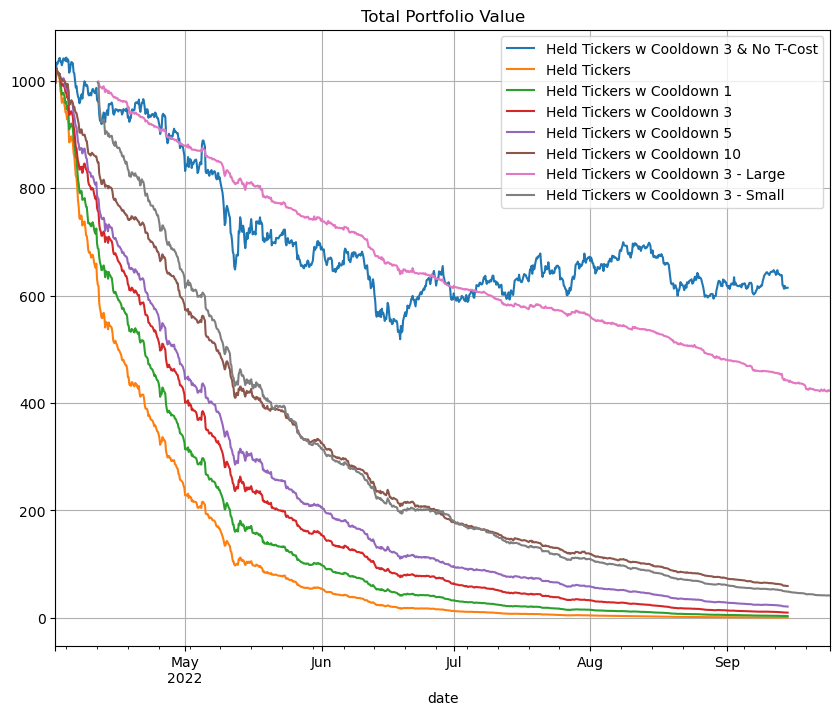

In [200]:
df_daily_portfolio_with_no_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 & No T-Cost', legend=True)
df_daily_portfolio_with_t_cost_held_tickers['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_1['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 1', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_5['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 5', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_10['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 10', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_large['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 - Large', legend=True)
df_daily_portfolio_with_t_cost_held_tickers_w_cooldown_3_small['total_portfolio_value'].plot(figsize=(10,8), grid=True, label='Held Tickers w Cooldown 3 - Small', legend=True, title='Total Portfolio Value')

## Rolling Performance Metrics for Large vs Small Coins

In [94]:
# Try to reuse your module
from portfolio import strategy_performance as perf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_bucket_spread_returns(
    df: pd.DataFrame,
    fwd_log_ret_col: str = "fwd_open_log_return_12h",
    bucket_col: str = "cap_bucket",
    decile_col: str = "signal_decile",
    date_col: str = "date",
    long_decile: int = 0,
    short_decile: int = 9,
    half_gross: bool = True,   # True => return on $2 gross; False => per-leg PnL (long-short)
):
    d = df.dropna(subset=[date_col, bucket_col, decile_col, fwd_log_ret_col]).copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # Use SIMPLE forward returns for compounding metrics
    d["fwd_simple_ret"] = np.expm1(d[fwd_log_ret_col].astype(float))

    # mean return per (date, bucket, decile)
    g = (
        d.groupby([date_col, bucket_col, decile_col])["fwd_simple_ret"]
         .mean()
         .reset_index()
    )

    piv = g.pivot_table(index=date_col, columns=[bucket_col, decile_col], values="fwd_simple_ret").sort_index()

    out = {}
    for b in sorted(d[bucket_col].unique()):
        if (b, long_decile) not in piv.columns or (b, short_decile) not in piv.columns:
            continue
        long_ret = piv[(b, long_decile)]
        short_ret = piv[(b, short_decile)]
        spread = long_ret - short_ret
        if half_gross:
            spread = 0.5 * spread

        df_spread = pd.DataFrame(
            {
                "spread_return": spread,
                "trade_count": np.where(spread.notna(), 1.0, 0.0),
            },
            index=spread.index,
        )
        out[b] = df_spread

    return out


In [96]:
def rolling_max_drawdown_from_returns(r: pd.Series, window: int, min_periods: int = None) -> pd.Series:
    rr = r.dropna()
    if min_periods is None:
        min_periods = max(20, window // 3)

    def _mdd(x):
        # equity curve inside window (start at 1)
        eq = np.cumprod(1.0 + x)
        peak = np.maximum.accumulate(eq)
        dd = (eq / peak) - 1.0
        return float(dd.min())

    return rr.rolling(window, min_periods=min_periods).apply(_mdd, raw=True)


def compute_rolling_spread_metrics(
    df_spread: pd.DataFrame,
    window: int,
    annual_trading_days: int,
    annual_rf: float = 0.0,
):
    # Reuse your module's rolling Sharpe (set costs off)
    roll_sharpe = perf.rolling_sharpe_ratio(
        df_spread,
        window=window,
        strategy_daily_return_col="spread_return",
        strategy_trade_count_col="trade_count",
        min_trade_count=0,  # important for shorter windows
        annual_trading_days=annual_trading_days,
        annual_rf=annual_rf,
        include_transaction_costs_and_fees=False,
    )

    r = df_spread["spread_return"]

    roll_mean = r.rolling(window, min_periods=max(20, window // 3)).mean()
    roll_vol  = r.rolling(window, min_periods=max(20, window // 3)).std() * np.sqrt(annual_trading_days)
    roll_hit  = r.rolling(window, min_periods=max(20, window // 3)).apply(lambda x: np.mean(x > 0), raw=True)
    roll_mdd  = rolling_max_drawdown_from_returns(r, window=window)

    out = pd.DataFrame(
        {
            "roll_sharpe": roll_sharpe,
            "roll_mean_per_bar": roll_mean,
            "roll_ann_vol": roll_vol,
            "roll_hit_rate": roll_hit,
            "roll_mdd": roll_mdd,  # negative
        }
    )
    return out


def summarize_rolling_sharpe(roll_sharpe: pd.Series) -> dict:
    s = roll_sharpe.dropna()
    return {
        "pct_sharpe_pos": float((s > 0).mean()),
        "pct_sharpe_gt_1": float((s > 1).mean()),
        "pct_sharpe_gt_2": float((s > 2).mean()),
        "median": float(s.median()),
        "p10": float(s.quantile(0.10)),
        "p90": float(s.quantile(0.90)),
    }


def plot_rolling_panels(m: pd.DataFrame, title: str):
    fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

    axes[0].plot(m.index, m["roll_sharpe"])
    axes[0].axhline(0, linewidth=1)
    axes[0].set_title(f"{title} | Rolling Sharpe")

    axes[1].plot(m.index, m["roll_mean_per_bar"])
    axes[1].axhline(0, linewidth=1)
    axes[1].set_title("Rolling mean (per bar)")

    axes[2].plot(m.index, m["roll_hit_rate"])
    axes[2].axhline(0.5, linewidth=1)
    axes[2].set_title("Rolling hit rate")

    axes[3].plot(m.index, m["roll_mdd"])
    axes[3].axhline(0, linewidth=1)
    axes[3].set_title("Rolling max drawdown (window)")

    plt.tight_layout()
    plt.show()



=== LARGE ===  n_bars=5960
--- 14D window --- {'pct_sharpe_pos': 0.6251488854857921, 'pct_sharpe_gt_1': 0.5623617491917645, 'pct_sharpe_gt_2': 0.48477114173898245, 'median': 1.7948792332091736, 'p10': -5.674689350160666, 'p90': 8.267598542480599}


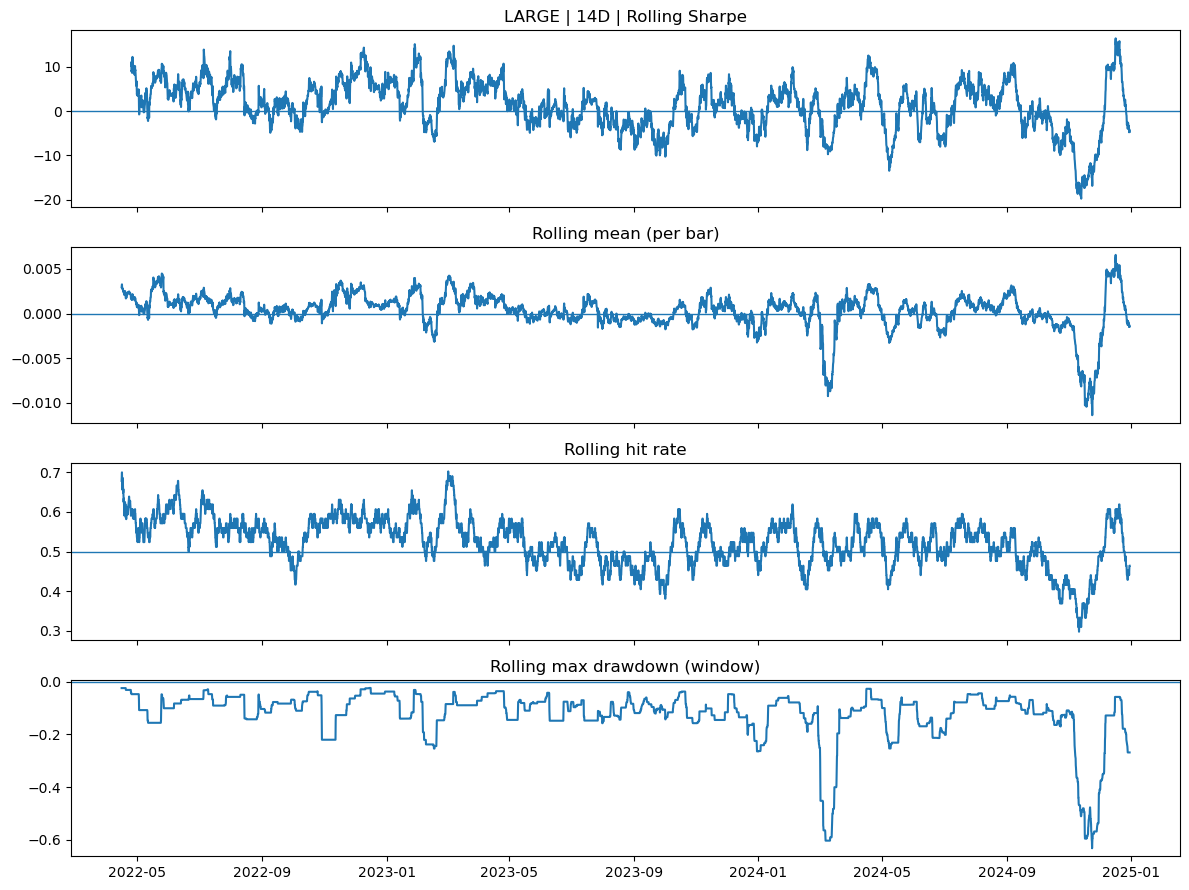

--- 30D window --- {'pct_sharpe_pos': 0.6422764227642277, 'pct_sharpe_gt_1': 0.5336446981491092, 'pct_sharpe_gt_2': 0.44680851063829785, 'median': 1.3675226445595081, 'p10': -3.8225236850961757, 'p90': 6.188612440499925}


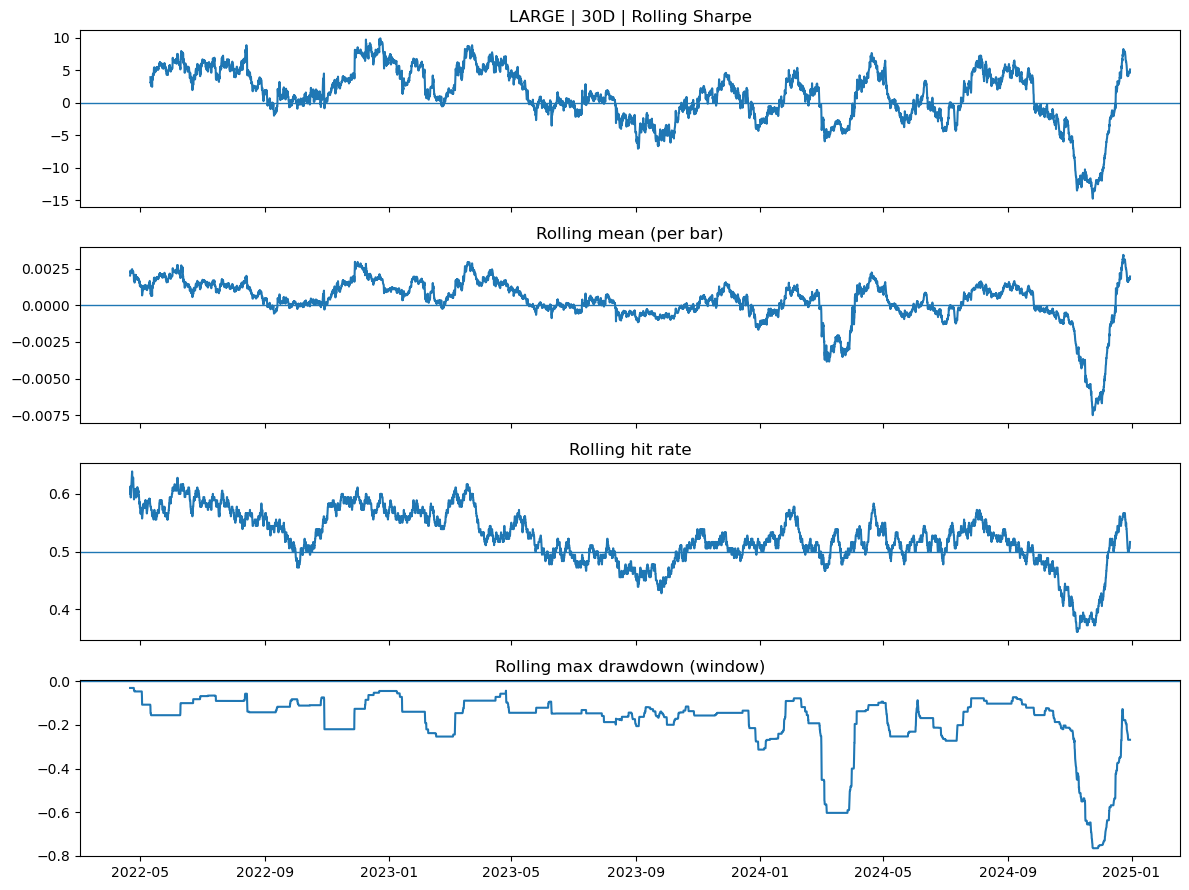

--- 90D window --- {'pct_sharpe_pos': 0.6541228555617045, 'pct_sharpe_gt_1': 0.4886552296624239, 'pct_sharpe_gt_2': 0.3835085777531821, 'median': 0.8857103047101518, 'p10': -1.7393358529354634, 'p90': 4.529835575180799}


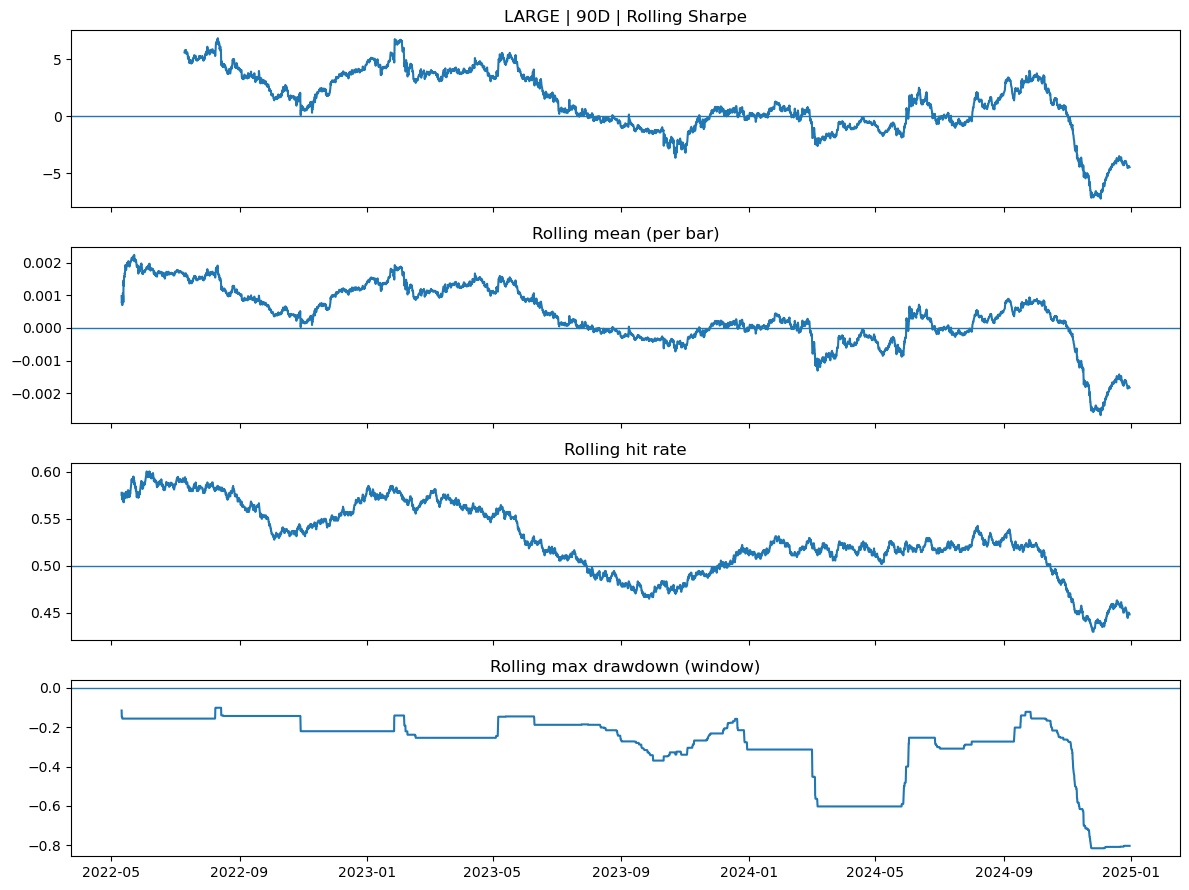


=== SMALL ===  n_bars=5987
--- 14D window --- {'pct_sharpe_pos': 0.883130081300813, 'pct_sharpe_gt_1': 0.8468834688346883, 'pct_sharpe_gt_2': 0.796239837398374, 'median': 6.178792271849078, 'p10': -0.5359767152877918, 'p90': 13.100597193477734}


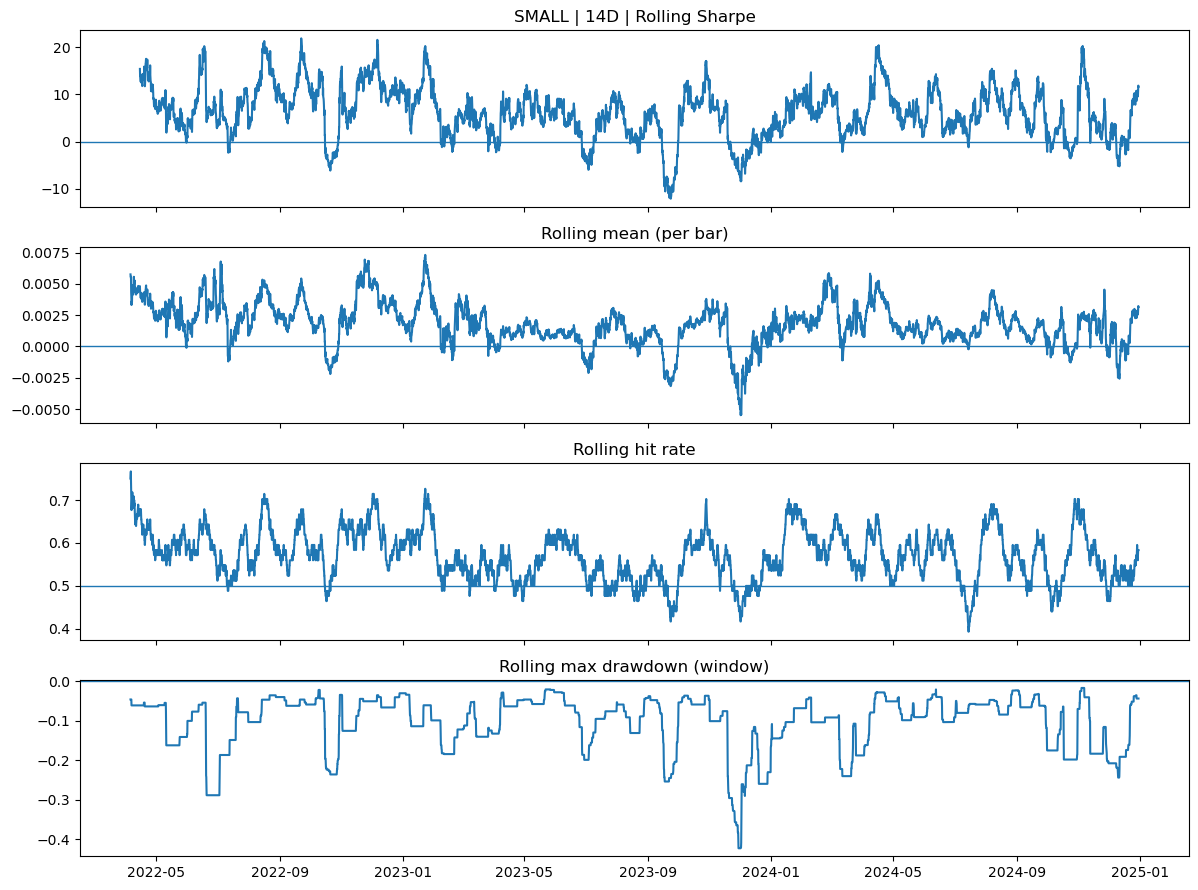

--- 30D window --- {'pct_sharpe_pos': 0.9257920110192838, 'pct_sharpe_gt_1': 0.8767217630853994, 'pct_sharpe_gt_2': 0.8269628099173554, 'median': 5.598046636411659, 'p10': 0.5057073818200271, 'p90': 10.940681147166824}


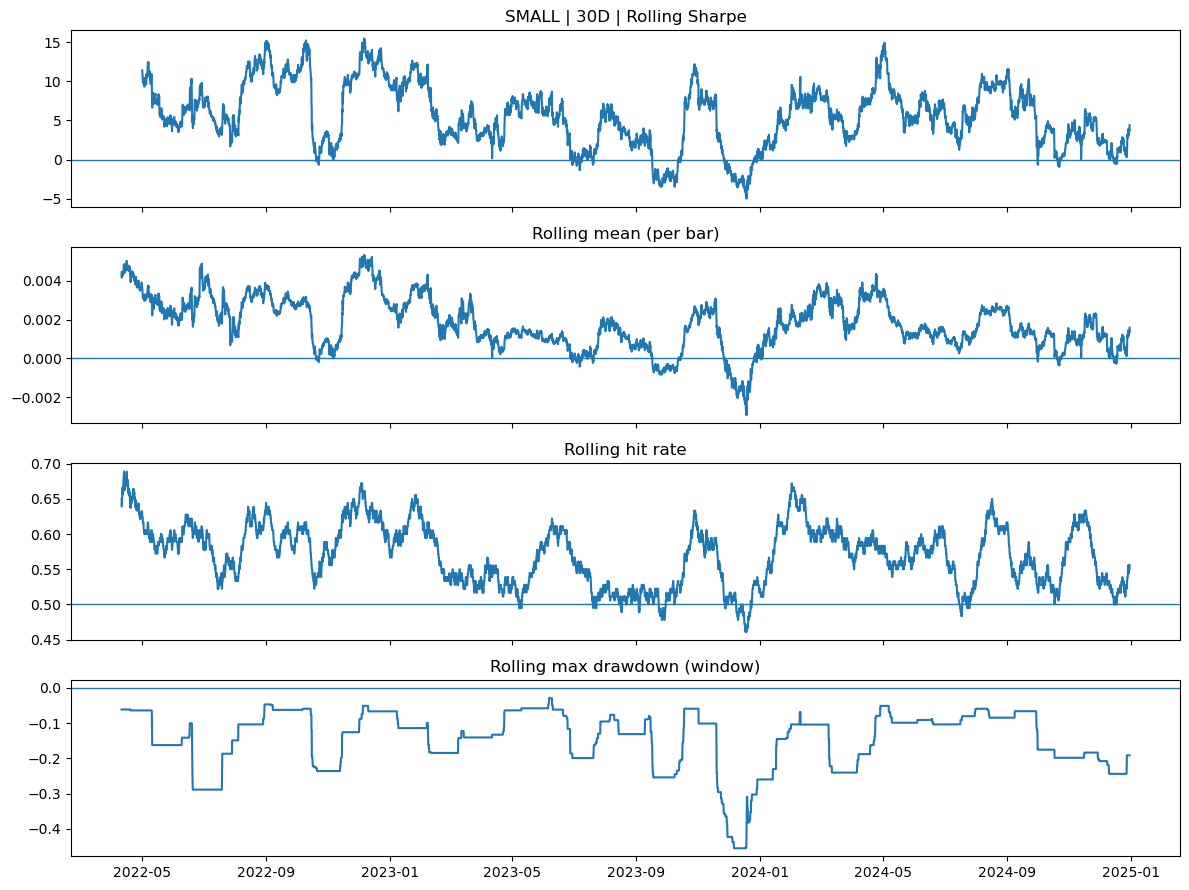

--- 90D window --- {'pct_sharpe_pos': 1.0, 'pct_sharpe_gt_1': 0.9631057268722467, 'pct_sharpe_gt_2': 0.8869309838472834, 'median': 5.42986149891156, 'p10': 1.655245498174501, 'p90': 8.268101761510666}


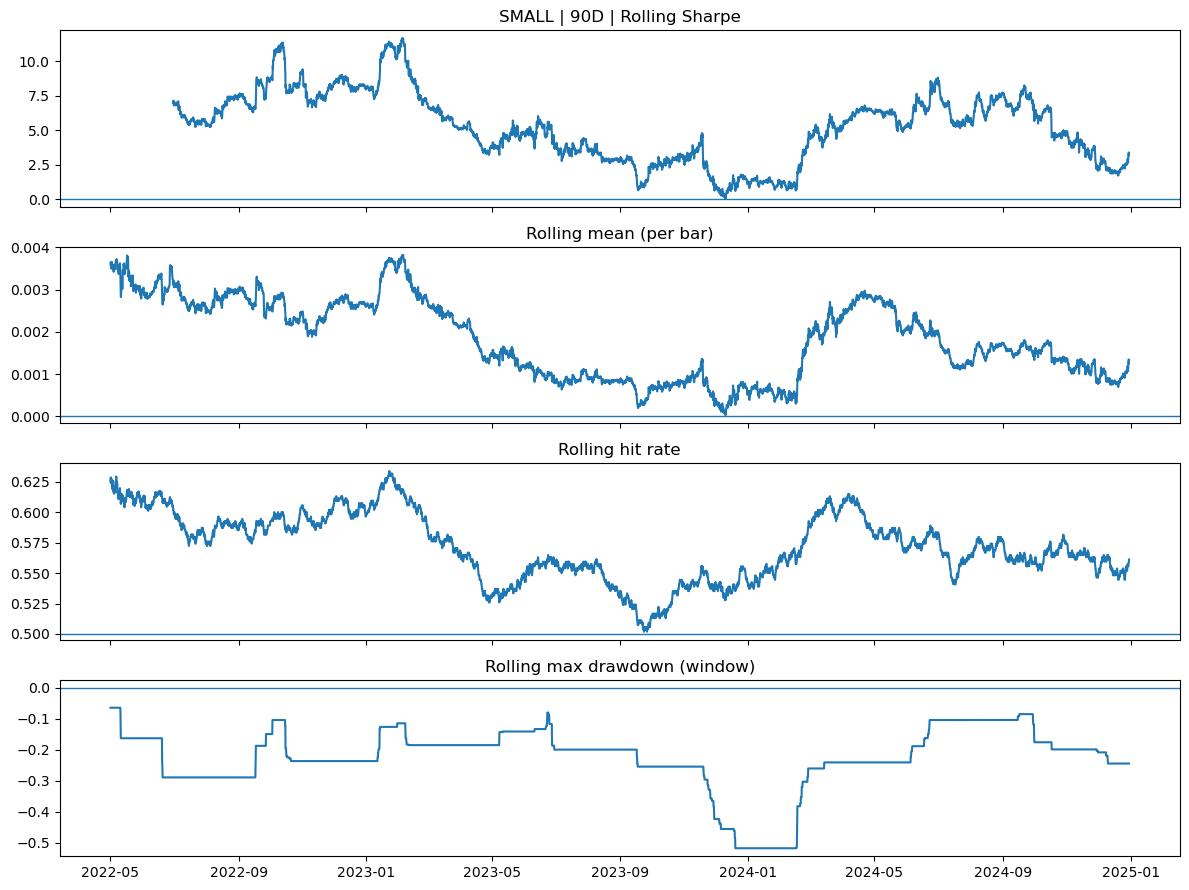

In [100]:
bars_per_day = 6                 # 4h bars
annual_trading_days = 365 * 6    # ~2190 “bars/year”
windows_days = [14, 30, 90]
windows = [w * bars_per_day for w in windows_days]

bucket_series = build_bucket_spread_returns(
    df=df_bucket,
    fwd_log_ret_col="fwd_open_log_return_12h",
    bucket_col="cap_bucket",
    decile_col="signal_decile",
    date_col="date",
    long_decile=0,
    short_decile=9,
    half_gross=True,   # recommended convention
)

for bucket_name in ["LARGE", "SMALL"]:
    df_sp = bucket_series[bucket_name].dropna()
    print(f"\n=== {bucket_name} ===  n_bars={len(df_sp)}")

    for w_days, w in zip(windows_days, windows):
        m = compute_rolling_spread_metrics(
            df_spread=df_sp,
            window=w,
            annual_trading_days=annual_trading_days,
            annual_rf=0.0,
        )
        print(f"--- {w_days}D window ---", summarize_rolling_sharpe(m["roll_sharpe"]))
        plot_rolling_panels(m, title=f"{bucket_name} | {w_days}D")


<Axes: xlabel='date'>

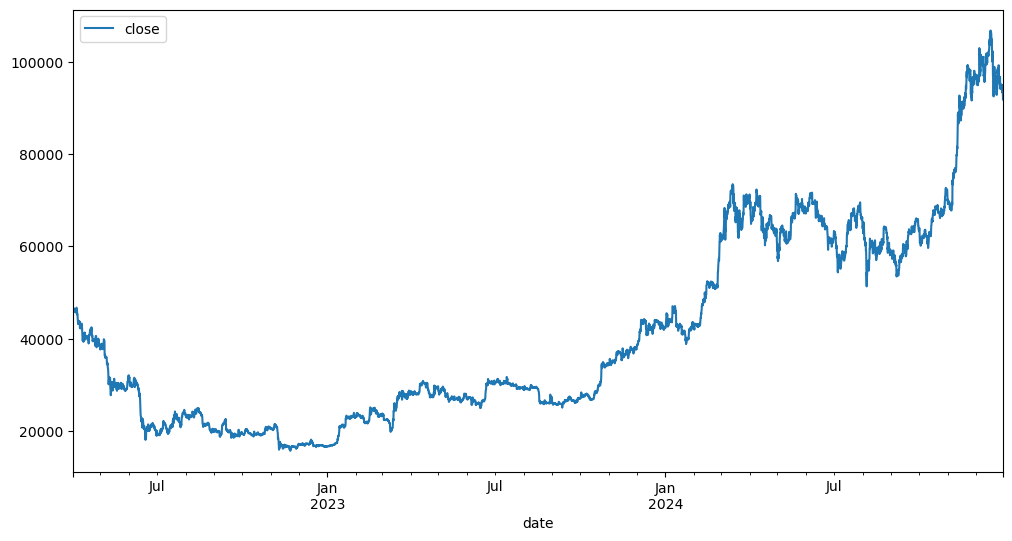

In [102]:
df_bucket[df_bucket['ticker'] == 'BTC-USD'][['date','close']].set_index('date').plot(figsize=(12,6))#.head()

## Simple Regime Filter Implementation

In [106]:
import numpy as np
import pandas as pd

def build_btc_regime_simple(
    df: pd.DataFrame,
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    bars_per_day: int = 6,
    trend_days: int = 14,      # trend lookback (days)
    vol_days: int = 14,        # vol lookback (days)
    vol_ref_days: int = 90,    # rolling baseline for "high vol" threshold
):
    """
    Returns DataFrame indexed by date with:
      btc_ret_lag1, btc_trend, btc_vol, btc_high_vol, btc_regime
    Regime = {UP,DOWN}_{LV,HV}
    All features use LAGGED BTC returns to avoid lookahead at time t.
    """
    btc = (
        df.loc[df[ticker_col] == btc_ticker, [date_col, close_col]]
        .drop_duplicates(subset=[date_col])
        .sort_values(date_col)
        .copy()
    )
    btc[date_col] = pd.to_datetime(btc[date_col])
    btc = btc.set_index(date_col)

    btc["btc_ret"] = np.log(btc[close_col] / btc[close_col].shift(1))
    btc["btc_ret_lag1"] = btc["btc_ret"].shift(1)  # last fully formed bar return

    r = btc["btc_ret_lag1"]

    trend_w = trend_days * bars_per_day
    vol_w   = vol_days * bars_per_day
    ref_w   = vol_ref_days * bars_per_day

    btc["btc_trend"] = r.rolling(trend_w, min_periods=trend_w).sum()
    btc["btc_vol"]   = r.rolling(vol_w,   min_periods=vol_w).std()

    # “high vol” if current vol > rolling median vol baseline
    btc["btc_vol_ref"]  = btc["btc_vol"].rolling(ref_w, min_periods=ref_w).median()
    btc["btc_high_vol"] = btc["btc_vol"] > btc["btc_vol_ref"]

    btc_trend_sign = np.where(btc["btc_trend"] >= 0, "UP", "DOWN")
    btc_vol_state  = np.where(btc["btc_high_vol"], "HV", "LV")
    btc["btc_regime"] = pd.Series(btc_trend_sign, index=btc.index) + "_" + pd.Series(btc_vol_state, index=btc.index)

    return btc[["btc_ret_lag1","btc_trend","btc_vol","btc_high_vol","btc_regime"]]

In [108]:
def compute_decile_spread_series(
    df: pd.DataFrame,
    cap_bucket_value: str,                 # "LARGE" or "SMALL"
    date_col: str = "date",
    bucket_col: str = "cap_bucket",
    decile_col: str = "signal_decile",
    fwd_ret_col: str = "fwd_open_log_return_12h",
    long_decile: int = 0,
    short_decile: int = 9,
    stride: int | None = None,             # set stride=3 to reduce overlap (non-overlapping entries)
):
    d = df.loc[df[bucket_col] == cap_bucket_value].dropna(subset=[date_col, decile_col, fwd_ret_col]).copy()
    d[date_col] = pd.to_datetime(d[date_col])

    # mean fwd return per decile per timestamp
    piv = d.pivot_table(index=date_col, columns=decile_col, values=fwd_ret_col, aggfunc="mean")

    if long_decile not in piv.columns or short_decile not in piv.columns:
        raise ValueError(f"Missing decile columns in pivot: need {long_decile} and {short_decile}")

    out = pd.DataFrame(index=piv.index)
    out["ret_long_d0"]  = piv[long_decile]
    out["ret_short_d9"] = piv[short_decile]
    out["spread_d0_d9"] = out["ret_long_d0"] - out["ret_short_d9"]

    out = out.sort_index().dropna(subset=["spread_d0_d9"])

    # Optional: reduce overlap in “trade-level” returns (recommended sanity check)
    if stride is not None and stride > 1:
        out = out.iloc[::stride].copy()

    return out


In [110]:
def summarize_by_regime(
    spread_df: pd.DataFrame,
    btc_regime_df: pd.DataFrame,
    ret_col: str = "spread_d0_d9",
    regime_col: str = "btc_regime",
    bars_per_year: int = 365 * 6,   # 4h bars
):
    x = spread_df.join(btc_regime_df[[regime_col]], how="inner").dropna(subset=[regime_col, ret_col]).copy()

    g = x.groupby(regime_col)[ret_col]
    summary = g.agg(["mean","std","count"]).rename(columns={"count":"n"})

    # Sharpe (approx; overlap exists if you didn't stride)
    summary["sharpe"] = np.sqrt(bars_per_year) * (summary["mean"] / summary["std"].replace(0, np.nan))
    summary["hit_rate"] = x.groupby(regime_col)[ret_col].apply(lambda s: (s > 0).mean())
    summary["frac_time"] = summary["n"] / summary["n"].sum()

    return summary.sort_values("sharpe", ascending=False)

In [112]:
def pick_allowed_regimes(
    regime_summary: pd.DataFrame,
    min_frac_time: float = 0.05,
    min_sharpe: float = 0.0,
    min_mean: float = 0.0,
):
    ok = (
        (regime_summary["frac_time"] >= min_frac_time) &
        (regime_summary["sharpe"] >= min_sharpe) &
        (regime_summary["mean"] >= min_mean)
    )
    return regime_summary.index[ok].tolist()


def apply_regime_gate(
    spread_df: pd.DataFrame,
    btc_regime_df: pd.DataFrame,
    allowed_regimes: list[str],
    ret_col: str = "spread_d0_d9",
    regime_col: str = "btc_regime",
):
    x = spread_df.join(btc_regime_df[[regime_col]], how="inner").copy()
    x["regime_ok"] = x[regime_col].isin(set(allowed_regimes))
    x["ret_gated"] = np.where(x["regime_ok"], x[ret_col], 0.0)
    return x


In [114]:
# Inputs you already have:
# df_diag has: date, ticker, cap_bucket, signal_decile, fwd_open_log_return_12h, close (for BTC rows)

btc_reg = build_btc_regime_simple(
    df=df_bucket,
    btc_ticker="BTC-USD",
    date_col="date",
    ticker_col="ticker",
    close_col="close",
    bars_per_day=6,
    trend_days=14,
    vol_days=14,
    vol_ref_days=90,
)

# Optional sanity: set stride=3 to reduce overlap (since fwd is 12h)
spread_large = compute_decile_spread_series(df_bucket, "LARGE", stride=3)
spread_small = compute_decile_spread_series(df_bucket, "SMALL", stride=3)

sum_large = summarize_by_regime(spread_large, btc_reg)
sum_small = summarize_by_regime(spread_small, btc_reg)

print("\n=== LARGE: regime summary ===")
print(sum_large)

print("\n=== SMALL: regime summary ===")
print(sum_small)

# Pick allowed regimes separately (LARGE and SMALL will likely differ)
allowed_large = pick_allowed_regimes(sum_large, min_frac_time=0.05, min_sharpe=0.0, min_mean=0.0)
allowed_small = pick_allowed_regimes(sum_small, min_frac_time=0.05, min_sharpe=0.0, min_mean=0.0)

gated_large = apply_regime_gate(spread_large, btc_reg, allowed_large)
gated_small = apply_regime_gate(spread_small, btc_reg, allowed_small)

print("\nAllowed regimes (LARGE):", allowed_large)
print("Allowed regimes (SMALL):", allowed_small)



=== LARGE: regime summary ===
                mean       std    n    sharpe  hit_rate  frac_time
btc_regime                                                        
DOWN_HV     0.002693  0.026345  350  4.783869  0.542857   0.176145
UP_HV       0.002072  0.033949  558  2.856094  0.528674   0.280825
DOWN_LV     0.001664  0.027567  551  2.825063  0.522686   0.277302
UP_LV      -0.000240  0.026327  528 -0.426249  0.520833   0.265727

=== SMALL: regime summary ===
                mean       std    n     sharpe  hit_rate  frac_time
btc_regime                                                         
DOWN_HV     0.007311  0.027918  350  12.255386  0.585714   0.175351
UP_LV       0.003891  0.027344  537   6.658669  0.569832   0.269038
DOWN_LV     0.003078  0.032081  553   4.490558  0.542495   0.277054
UP_HV       0.003255  0.035863  556   4.247065  0.566547   0.278557

Allowed regimes (LARGE): ['DOWN_HV', 'UP_HV', 'DOWN_LV']
Allowed regimes (SMALL): ['DOWN_HV', 'UP_LV', 'DOWN_LV', 'UP_HV']


In [116]:
allowed_large

['DOWN_HV', 'UP_HV', 'DOWN_LV']

In [118]:
allowed_small

['DOWN_HV', 'UP_LV', 'DOWN_LV', 'UP_HV']

## BTC Regime Time Series Plot for Large and Small Coin Universe

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

REGIME_COLORS = {
    "DOWN_HV": "#d62728",  # red
    "UP_HV":   "#ff7f0e",  # orange
    "DOWN_LV": "#1f77b4",  # blue
    "UP_LV":   "#2ca02c",  # green
}

BARS_PER_DAY = 6          # 4h bars
BARS_PER_YEAR = 365 * BARS_PER_DAY
ANN_FACTOR = np.sqrt(BARS_PER_YEAR)

def build_regime_blocks(regime_s: pd.Series) -> pd.DataFrame:
    s = pd.Series(regime_s).dropna().copy()
    s = s[~s.index.duplicated(keep="last")].sort_index()
    if s.empty:
        return pd.DataFrame(columns=["start", "end", "regime"])

    df = s.rename("regime").to_frame()
    df["gid"] = (df["regime"] != df["regime"].shift()).cumsum()

    blocks = df.groupby("gid").agg(
        start=("regime", lambda x: x.index.min()),
        end=("regime", lambda x: x.index.max()),
        regime=("regime", "first"),
    ).reset_index(drop=True)
    return blocks

def shade_regime_blocks(ax, blocks: pd.DataFrame, colors: dict,
                        alpha: float = 0.18, label_blocks: bool = True,
                        min_label_bars: int = 6 * 7):
    for _, row in blocks.iterrows():
        r = row["regime"]
        c = colors.get(r, "grey")
        ax.axvspan(row["start"], row["end"], facecolor=c, alpha=alpha, linewidth=0)

        if label_blocks:
            dur = (pd.Timestamp(row["end"]) - pd.Timestamp(row["start"]))
            bars_est = int(dur / pd.Timedelta(hours=4)) + 1
            if bars_est >= min_label_bars:
                mid = row["start"] + (row["end"] - row["start"]) / 2
                y = ax.get_ylim()[1]
                ax.text(mid, y, r, ha="center", va="top", fontsize=9, alpha=0.85)

def plot_regime_strip(ax, blocks: pd.DataFrame, colors: dict):
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    for _, row in blocks.iterrows():
        r = row["regime"]
        c = colors.get(r, "grey")
        ax.axvspan(row["start"], row["end"], facecolor=c, alpha=0.9, linewidth=0)

    ax.set_title("BTC Regime (colored strip)", fontsize=10)
    for spine in ax.spines.values():
        spine.set_visible(False)

def add_regime_legend(ax, colors: dict):
    order = ["DOWN_HV","UP_HV","DOWN_LV","UP_LV"]
    patches = [mpatches.Patch(color=colors[k], label=k) for k in order if k in colors]
    ax.legend(handles=patches, loc="upper left", ncol=4, frameon=False)

def cum_and_dd_from_logret(logret: pd.Series):
    lr = logret.fillna(0.0)
    cum_log = lr.cumsum()
    equity = np.exp(cum_log)
    peak = np.maximum.accumulate(equity)
    dd = (equity / peak) - 1.0
    return cum_log, equity, dd

def regime_summary_from_returns(ret: pd.Series, reg: pd.Series) -> pd.DataFrame:
    """
    ret: per-bar spread return (timestamp-indexed)
    reg: regime labels aligned to ret index (timestamp-indexed)
    """
    df = pd.DataFrame({"ret": ret, "regime": reg}).dropna()
    if df.empty:
        return pd.DataFrame(columns=["mean","std","n","sharpe","hit_rate","frac_time"])

    g = df.groupby("regime")["ret"]
    out = g.agg(["mean","std","count"]).rename(columns={"count":"n"})
    out["hit_rate"] = g.apply(lambda x: (x > 0).mean())
    out["frac_time"] = out["n"] / out["n"].sum()
    out["sharpe"] = (out["mean"] / out["std"].replace(0, np.nan)) * ANN_FACTOR
    out = out.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return out.sort_values("sharpe", ascending=False)

def plot_bucket_regime_diagnostics(
    bucket_name: str,
    df_diag: pd.DataFrame,
    btc_reg: pd.DataFrame,
    spread_df: pd.DataFrame,        # index=date, contains spread return column
    allowed_regimes: list[str],
    spread_ret_col: str = "spread_d0_d9",  # <- your per-bar spread return column
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    regime_col: str = "btc_regime",
    colors: dict = REGIME_COLORS,
    shade_alpha: float = 0.22,
):
    # --- BTC close (for top panel) ---
    btc_close = (
        df_diag.loc[df_diag[ticker_col] == btc_ticker, [date_col, close_col]]
        .drop_duplicates(subset=[date_col])
        .copy()
    )
    btc_close[date_col] = pd.to_datetime(btc_close[date_col])
    btc_close = btc_close.sort_values(date_col).set_index(date_col)[close_col].astype(float)

    # --- Regime series (make sure it's clean + sorted) ---
    reg_s = pd.Series(btc_reg[regime_col]).dropna().copy()
    reg_s.index = pd.to_datetime(reg_s.index)
    reg_s = reg_s[~reg_s.index.duplicated(keep="last")].sort_index()

    # --- Raw spread returns aligned to regime index ---
    raw = spread_df[spread_ret_col].copy()
    raw.index = pd.to_datetime(raw.index)
    raw = raw[~raw.index.duplicated(keep="last")].sort_index()
    raw = raw.reindex(reg_s.index).fillna(0.0)

    # --- Align regime to raw index (ffill regime labels is OK; never ffill returns) ---
    reg_aligned = reg_s.reindex(raw.index).ffill()

    allowed_set = set(allowed_regimes)
    mask = reg_aligned.isin(allowed_set)
    gated = raw.where(mask, 0.0)

    # For sanity/debug: if you gate to one regime you should see lots of zeros
    active_frac = float(mask.mean())

    # Regime blocks from aligned regime
    blocks = build_regime_blocks(reg_aligned)

    raw_cum, _, raw_dd = cum_and_dd_from_logret(raw)
    g_cum, _, g_dd = cum_and_dd_from_logret(gated)

    fig, axes = plt.subplots(
        4, 1, figsize=(14, 10), sharex=True,
        gridspec_kw={"height_ratios": [2.2, 2.0, 2.0, 0.45]}
    )

    # (1) BTC close + shading
    btc_plot = btc_close.reindex(raw.index).dropna()
    axes[0].plot(btc_plot.index, btc_plot.values)
    axes[0].set_title(f"{bucket_name} | BTC-USD Close with Regime Shading")
    shade_regime_blocks(axes[0], blocks, colors, alpha=shade_alpha, label_blocks=True, min_label_bars=6*10)
    add_regime_legend(axes[0], colors)

    # (2) Cumulative returns
    axes[1].plot(raw_cum.index, raw_cum.values, label="Spread raw")
    axes[1].plot(g_cum.index, g_cum.values, label=f"Spread gated (active={active_frac:.2%})")
    axes[1].axhline(0.0, linewidth=1)
    axes[1].set_title(f"{bucket_name} | Spread cumulative (log) returns | Allowed: {allowed_regimes}")
    axes[1].legend(loc="upper left", frameon=False)
    shade_regime_blocks(axes[1], blocks, colors, alpha=shade_alpha*0.65, label_blocks=False)

    # (3) Drawdowns
    axes[2].plot(raw_dd.index, raw_dd.values, label="DD raw")
    axes[2].plot(g_dd.index, g_dd.values, label="DD gated")
    axes[2].axhline(0.0, linewidth=1)
    axes[2].set_title(f"{bucket_name} | Drawdowns (raw vs gated)")
    axes[2].legend(loc="lower left", frameon=False)
    shade_regime_blocks(axes[2], blocks, colors, alpha=shade_alpha*0.65, label_blocks=False)

    # (4) Regime strip
    plot_regime_strip(axes[3], blocks, colors)

    plt.tight_layout()
    plt.show()

    # Return the summary so you can inspect it
    return regime_summary_from_returns(raw, reg_aligned)

# -----------------------------
# LARGE experiments driver
# -----------------------------
def run_large_regime_experiments(df_diag, btc_reg, spread_large_df, spread_ret_col="spread_d0_d9", cohort='LARGE'):
    # Build aligned raw/reg once (same logic as plot function, but without plotting yet)
    reg_s = pd.Series(btc_reg["btc_regime"]).dropna().copy()
    reg_s.index = pd.to_datetime(reg_s.index)
    reg_s = reg_s[~reg_s.index.duplicated(keep="last")].sort_index()

    raw = spread_large_df[spread_ret_col].copy()
    raw.index = pd.to_datetime(raw.index)
    raw = raw[~raw.index.duplicated(keep="last")].sort_index()
    raw = raw.reindex(reg_s.index).fillna(0.0)
    reg_aligned = reg_s.reindex(raw.index).ffill()

    summary = regime_summary_from_returns(raw, reg_aligned)
    print(f"\n=== {cohort} regime summary (ranked by Sharpe) ===")
    print(summary)

    # A) remove UP_LV
    allowed_ex_up_lv = [r for r in ["DOWN_HV","UP_HV","DOWN_LV","UP_LV"] if r != "UP_LV"]

    # B) top 1 regime by Sharpe
    top1 = summary.head(1).index.tolist()

    # C) top 2 regimes by Sharpe
    top2 = summary.head(2).index.tolist()

    print(f"\n{cohort} allowed sets:")
    print("Exclude UP_LV:", allowed_ex_up_lv)
    print("Top 1:", top1)
    print("Top 2:", top2)

    # Plot each experiment
    plot_bucket_regime_diagnostics(
        bucket_name=f"{cohort} | exclude UP_LV",
        df_diag=df_diag, btc_reg=btc_reg, spread_df=spread_large_df,
        allowed_regimes=allowed_ex_up_lv, spread_ret_col=spread_ret_col
    )
    plot_bucket_regime_diagnostics(
        bucket_name=f"{cohort} | TOP 1 regime",
        df_diag=df_diag, btc_reg=btc_reg, spread_df=spread_large_df,
        allowed_regimes=top1, spread_ret_col=spread_ret_col
    )
    plot_bucket_regime_diagnostics(
        bucket_name=f"{cohort} | TOP 2 regimes",
        df_diag=df_diag, btc_reg=btc_reg, spread_df=spread_large_df,
        allowed_regimes=top2, spread_ret_col=spread_ret_col
    )

    return summary, {"exclude_up_lv": allowed_ex_up_lv, "top1": top1, "top2": top2}



=== LARGE regime summary (ranked by Sharpe) ===
             mean       std     n  hit_rate  frac_time    sharpe
regime                                                          
DOWN_HV  0.000883  0.015120  1068  0.177903   0.177232  2.731625
UP_HV    0.000692  0.019637  1670  0.176647   0.277132  1.649878
DOWN_LV  0.000546  0.015802  1679  0.171531   0.278626  1.617379
UP_LV   -0.000079  0.015072  1609  0.170914   0.267010 -0.244325

LARGE allowed sets:
Exclude UP_LV: ['DOWN_HV', 'UP_HV', 'DOWN_LV']
Top 1: ['DOWN_HV']
Top 2: ['DOWN_HV', 'UP_HV']


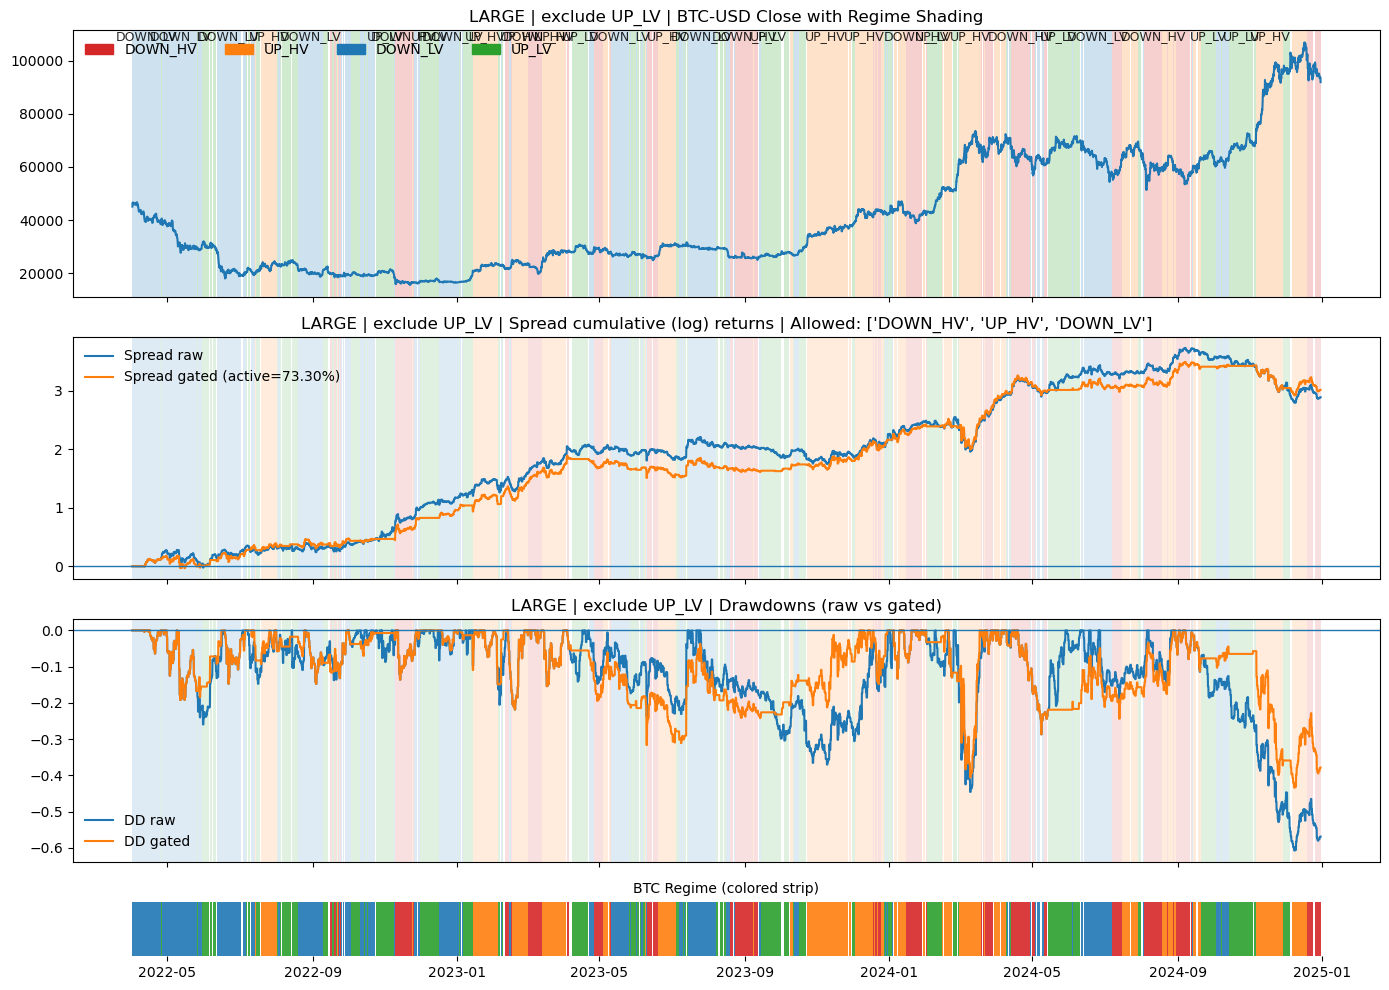

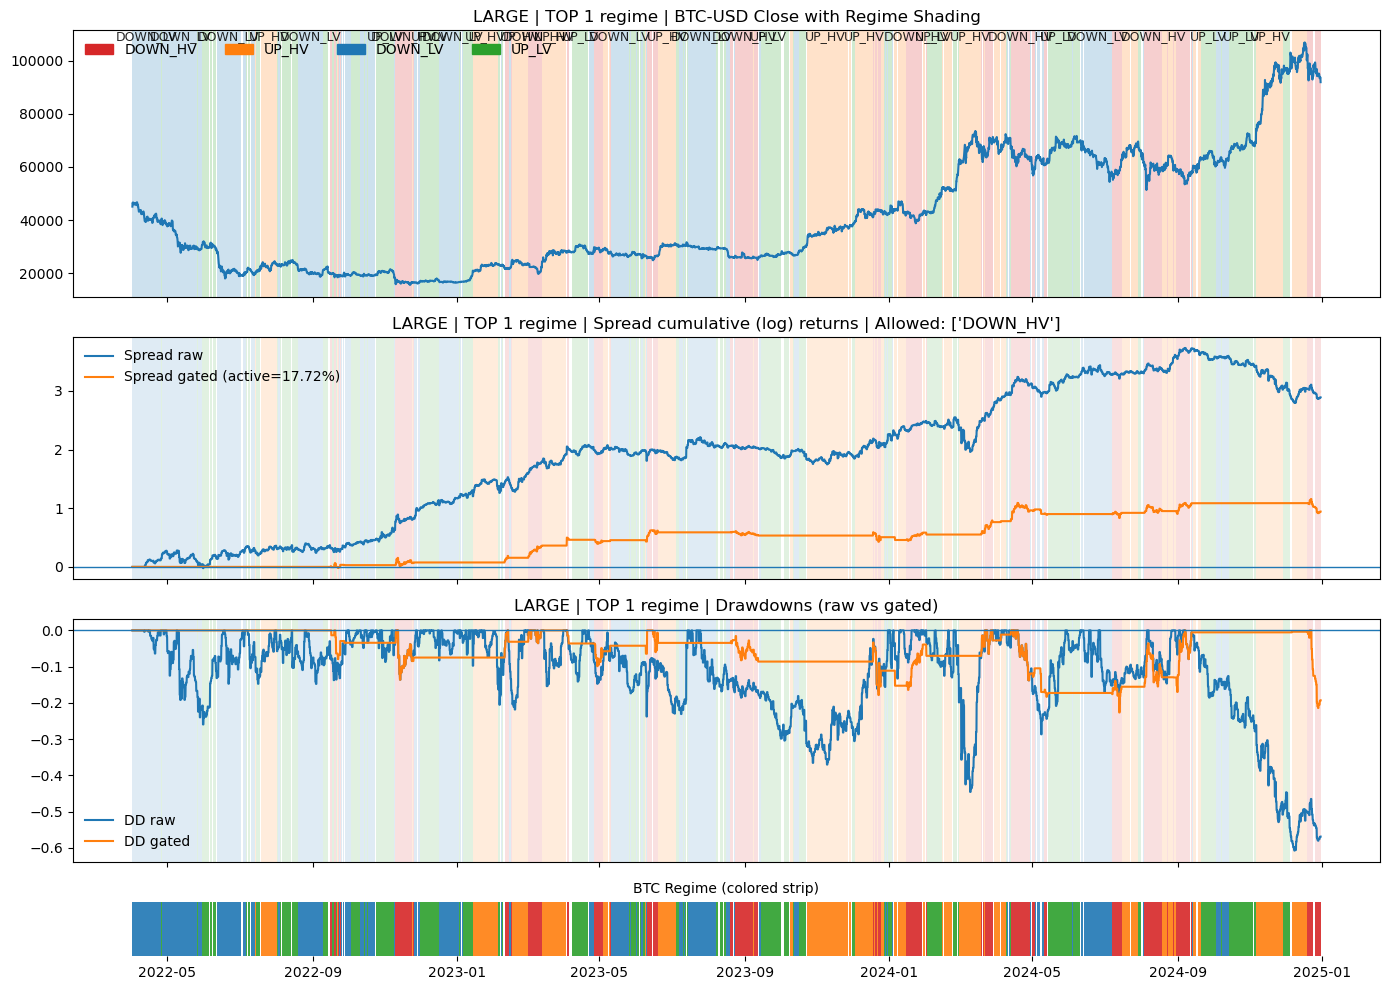

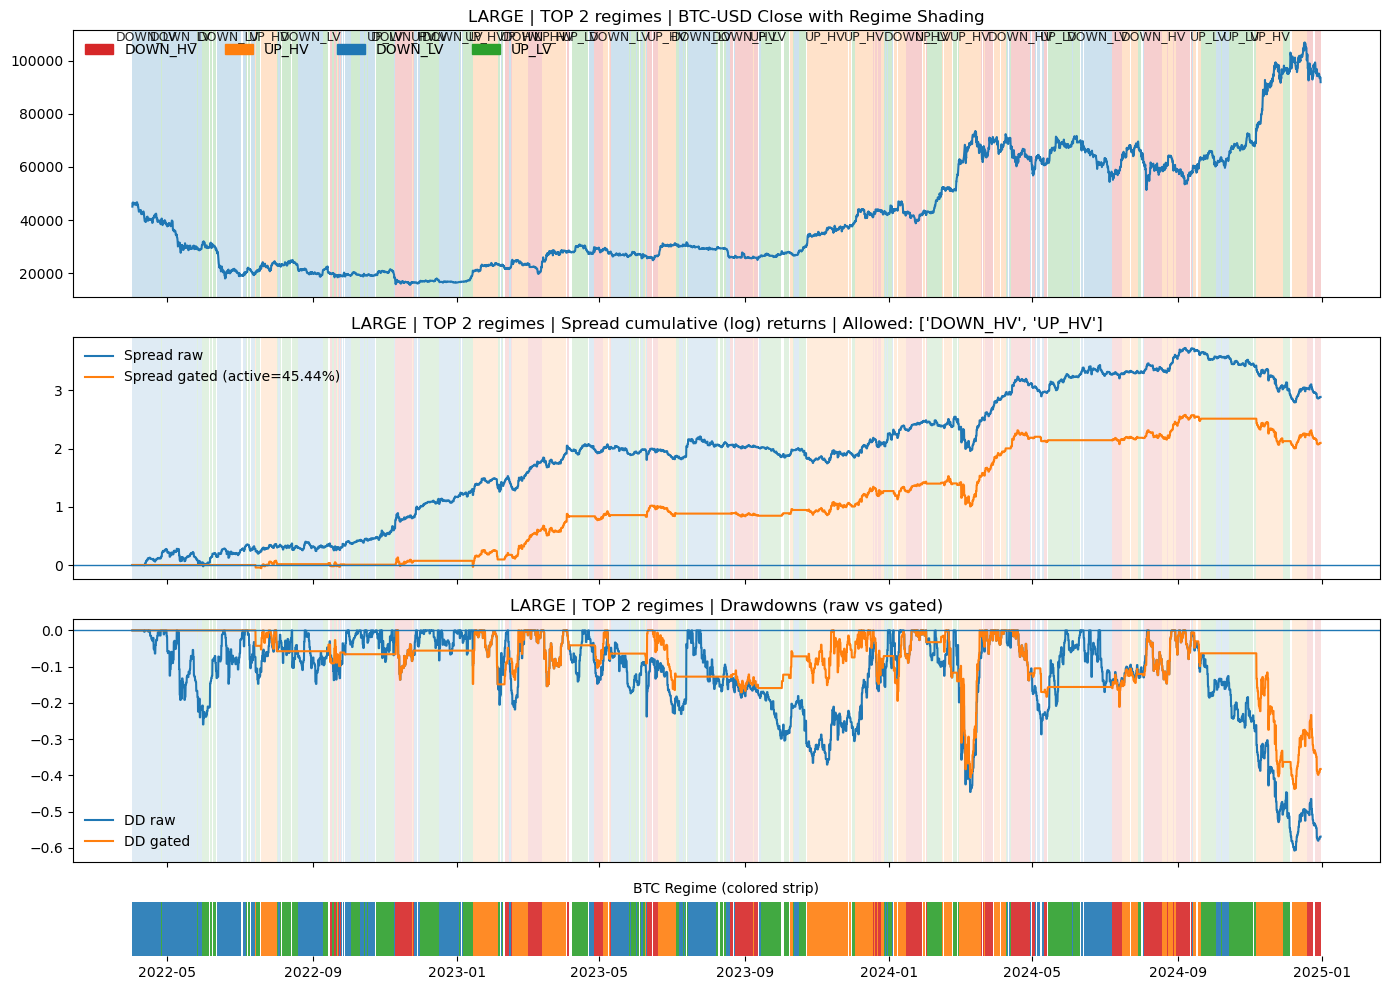

In [123]:
summary_large, allowed_sets = run_large_regime_experiments(
    df_diag=df_diag,
    btc_reg=btc_reg,
    spread_large_df=spread_large,
    spread_ret_col="spread_d0_d9",   # change if your spread return column name differs
)



=== SMALL regime summary (ranked by Sharpe) ===
             mean       std     n  hit_rate  frac_time    sharpe
regime                                                          
DOWN_HV  0.002396  0.016332  1068  0.191948   0.177232  6.865590
UP_LV    0.001299  0.015894  1609  0.190180   0.267010  3.823415
DOWN_LV  0.001014  0.018457  1679  0.178678   0.278626  2.570763
UP_HV    0.001084  0.020738  1670  0.188623   0.277132  2.445327

SMALL allowed sets:
Exclude UP_LV: ['DOWN_HV', 'UP_HV', 'DOWN_LV']
Top 1: ['DOWN_HV']
Top 2: ['DOWN_HV', 'UP_LV']


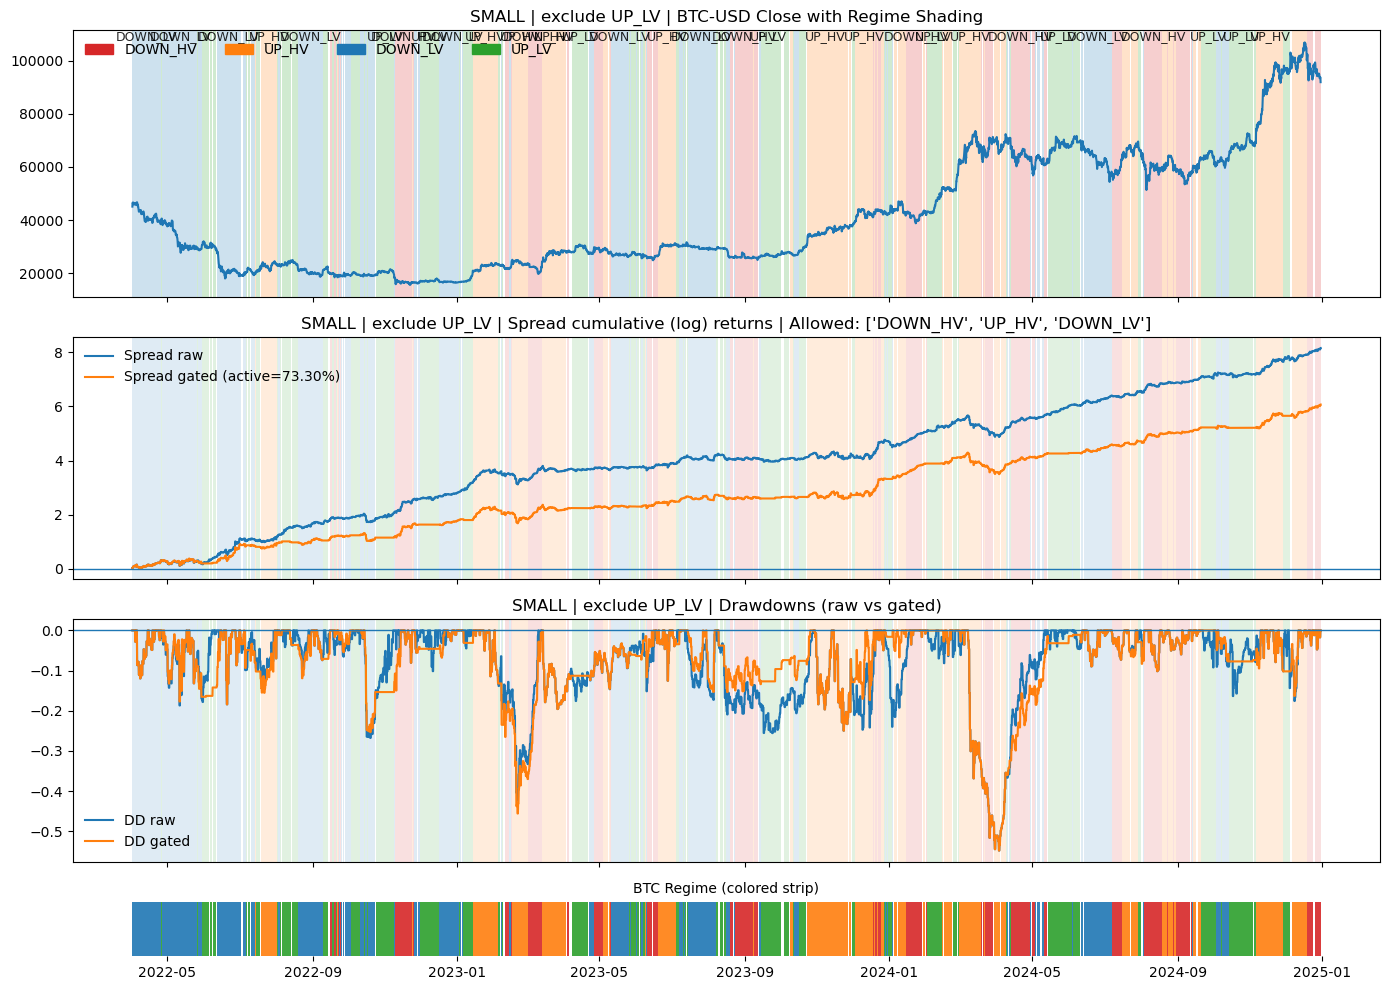

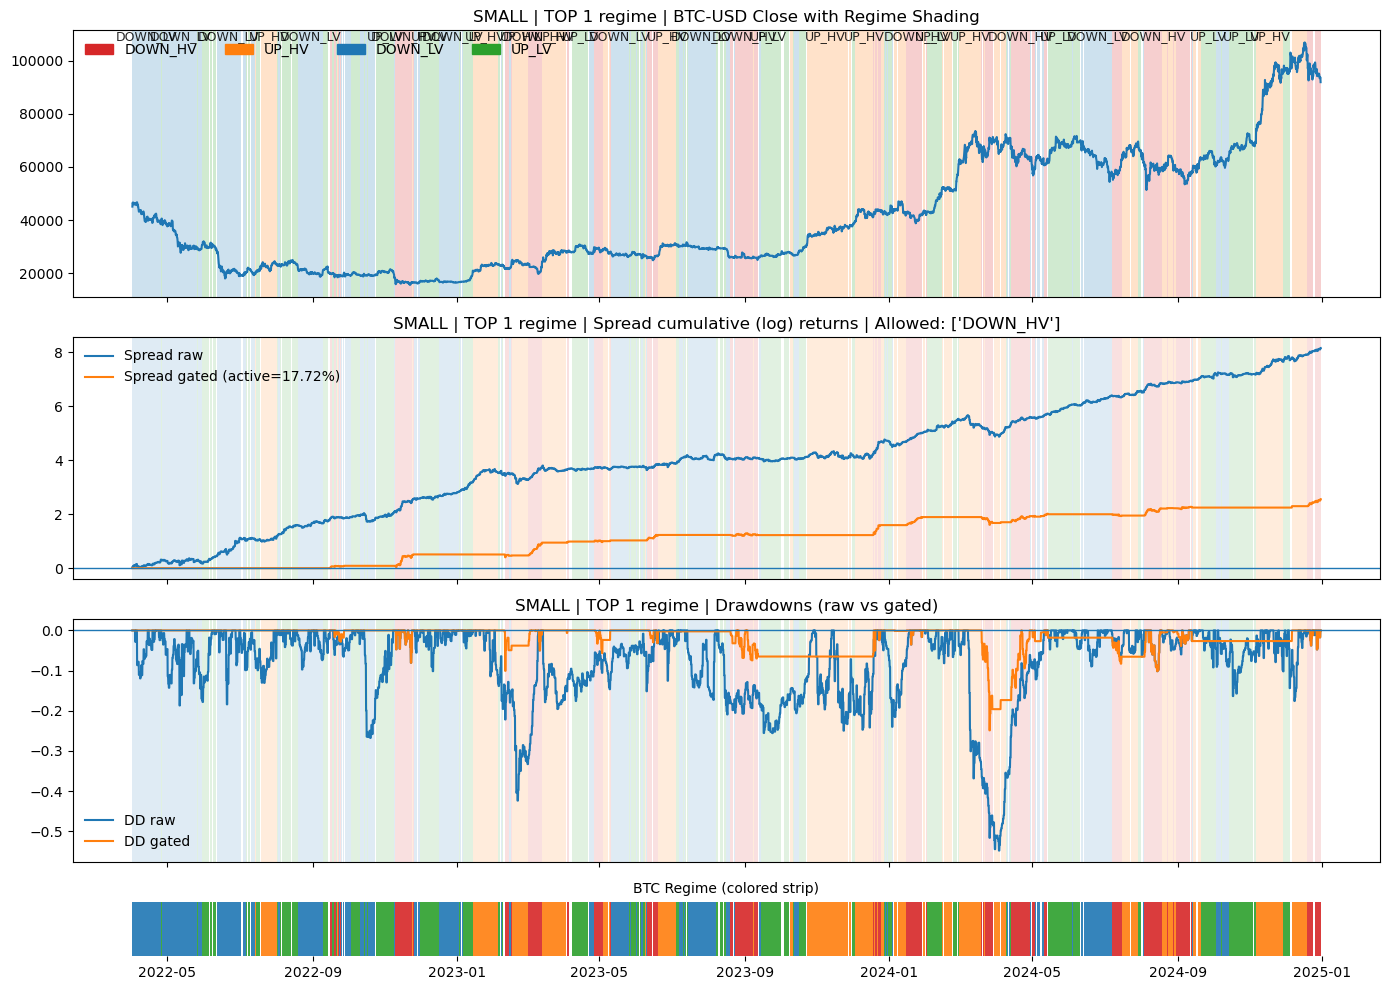

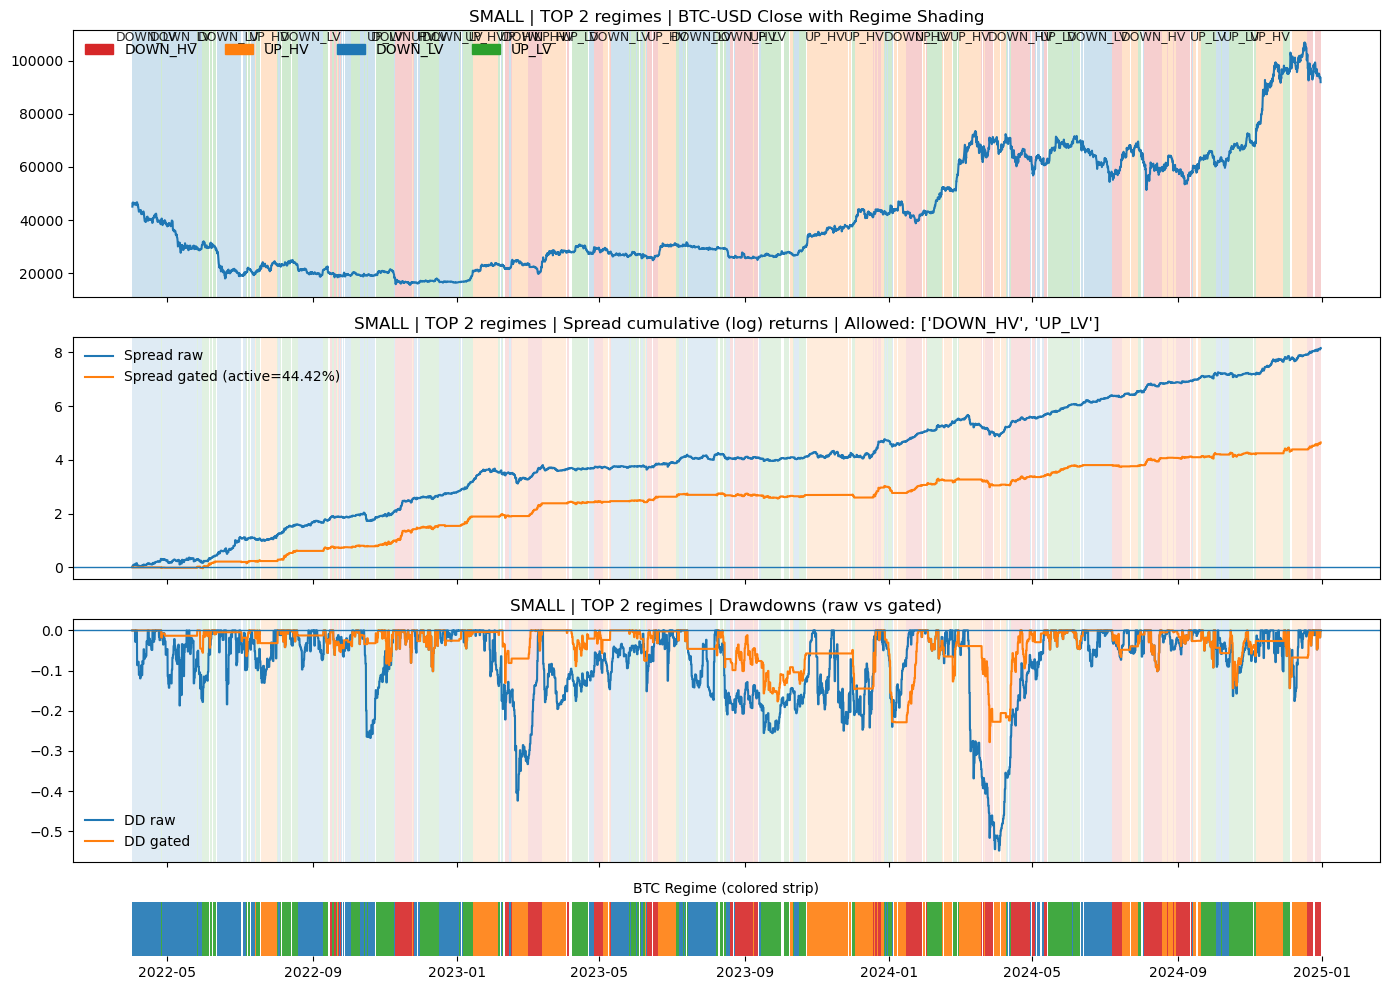

In [125]:
summary_small, allowed_sets = run_large_regime_experiments(
    df_diag=df_diag,
    btc_reg=btc_reg,
    spread_large_df=spread_small,
    spread_ret_col="spread_d0_d9",   # change if your spread return column name differs
    cohort='SMALL'
)

## Regime Gating Experiments & Contribution to Drawdowns

In [129]:
import numpy as np
import pandas as pd

BARS_PER_DAY = 6            # 4h bars
ANNUAL_BARS = BARS_PER_DAY * 365  # crypto trades every day

def _prep_regime_series(btc_reg: pd.DataFrame, date_col="date", regime_col="btc_regime") -> pd.Series:
    """
    Return a clean, timestamp-indexed regime series with unique sorted index.
    Accepts either:
      - df indexed by datetime
      - df with a 'date' column
    """
    if regime_col not in btc_reg.columns and regime_col != btc_reg.name:
        raise ValueError(f"Missing regime_col='{regime_col}'")

    if date_col in btc_reg.columns:
        s = btc_reg[[date_col, regime_col]].copy()
        s[date_col] = pd.to_datetime(s[date_col])
        s = s.drop_duplicates(subset=[date_col]).sort_values(date_col).set_index(date_col)[regime_col]
    else:
        s = btc_reg[regime_col].copy()
        s.index = pd.to_datetime(s.index)
        s = s[~s.index.duplicated(keep="last")].sort_index()

    return s.dropna()

def gate_log_returns_by_regime(
    logret: pd.Series,
    regime_s: pd.Series,
    allowed_regimes: list[str],
) -> tuple[pd.Series, float]:
    """
    logret: timestamp-indexed log return series (per bar)
    regime_s: timestamp-indexed regime labels
    allowed_regimes: list of regimes to keep active

    returns: (gated_logret, active_fraction)
    """
    lr = pd.Series(logret).copy()
    lr.index = pd.to_datetime(lr.index)
    lr = lr[~lr.index.duplicated(keep="last")].sort_index()

    reg = regime_s.reindex(lr.index)
    active = reg.isin(allowed_regimes)
    gated = lr.where(active, 0.0)

    active_frac = float(active.mean())  # fraction of bars active
    return gated, active_frac

def sharpe_from_logret(logret: pd.Series, annual_bars: int = ANNUAL_BARS) -> float:
    x = logret.dropna()
    if len(x) < 2:
        return np.nan
    mu = x.mean()
    sd = x.std(ddof=1)
    if sd == 0 or np.isnan(sd):
        return np.nan
    return float((mu / sd) * np.sqrt(annual_bars))

def perf_metrics_via_strategy_performance(
    logret: pd.Series,
    annual_bars: int = ANNUAL_BARS,
    name: str = "strategy",
) -> dict:
    """
    Use your strategy_performance.py to compute CAGR/Sharpe/Calmar/DD
    by converting log returns -> simple returns.
    """
    lr = logret.fillna(0.0)
    simple_ret = np.exp(lr) - 1.0  # convert log -> simple

    df = pd.DataFrame({
        "strategy_return": simple_ret,
        "trade_count": np.ones(len(simple_ret), dtype=float),  # dummy (not used if costs disabled)
    }, index=simple_ret.index)

    out = perf.calculate_risk_and_performance_metrics(
        df=df,
        strategy_daily_return_col="strategy_return",
        strategy_trade_count_col="trade_count",
        annual_rf=0.0,
        annual_trading_days=annual_bars,
        include_transaction_costs_and_fees=False,  # keep clean here
    )
    out["name"] = name
    return out

def regime_summary_table(logret: pd.Series, regime_s: pd.Series, annual_bars: int = ANNUAL_BARS) -> pd.DataFrame:
    lr = pd.Series(logret).copy()
    lr.index = pd.to_datetime(lr.index)
    lr = lr[~lr.index.duplicated(keep="last")].sort_index()

    reg = regime_s.reindex(lr.index)
    d = pd.DataFrame({"logret": lr, "regime": reg}).dropna(subset=["logret", "regime"])

    g = d.groupby("regime")["logret"]
    stats = g.agg(["mean", "std", "count"]).rename(columns={"count": "n"})
    stats["hit_rate"] = g.apply(lambda x: float((x > 0).mean()))
    stats["frac_time"] = stats["n"] / stats["n"].sum()
    stats["sharpe"] = (stats["mean"] / stats["std"]).replace([np.inf, -np.inf], np.nan) * np.sqrt(annual_bars)

    # nicer ordering
    stats = stats.sort_values("sharpe", ascending=False)
    return stats


In [131]:
def run_step_a_bucket(
    bucket_name: str,
    spread_df: pd.DataFrame,          # index=date, col 'spread_d0_d9' (log returns)
    regime_s: pd.Series,              # btc regime series
    exclude_regime: str | None = None,
    top_k_list: list[int] = [1, 2],
    annual_bars: int = ANNUAL_BARS,
) -> dict:
    """
    Returns a dict with:
      - regime_table
      - experiments: {label: {allowed_regimes, active_frac, metrics_raw, metrics_gated}}
    """
    spread = spread_df["spread_d0_d9"].copy()
    spread.index = pd.to_datetime(spread.index)
    spread = spread[~spread.index.duplicated(keep="last")].sort_index()

    # regime quality table (for this bucket's spread)
    reg_tbl = regime_summary_table(spread, regime_s, annual_bars=annual_bars)

    experiments = {}

    # RAW metrics
    raw_metrics = perf_metrics_via_strategy_performance(spread, annual_bars=annual_bars, name=f"{bucket_name}_raw")

    # (A1) Exclude one regime
    if exclude_regime is not None:
        allowed = [r for r in reg_tbl.index.tolist() if r != exclude_regime]
        gated, active_frac = gate_log_returns_by_regime(spread, regime_s, allowed)
        gated_metrics = perf_metrics_via_strategy_performance(gated, annual_bars=annual_bars,
                                                             name=f"{bucket_name}_exclude_{exclude_regime}")
        experiments[f"exclude_{exclude_regime}"] = dict(
            allowed_regimes=allowed,
            active_frac=active_frac,
            metrics_raw=raw_metrics,
            metrics_gated=gated_metrics,
        )

    # (A2) Top-K regimes by Sharpe
    ranked = reg_tbl.index.tolist()
    for k in top_k_list:
        allowed = ranked[:k]
        gated, active_frac = gate_log_returns_by_regime(spread, regime_s, allowed)
        gated_metrics = perf_metrics_via_strategy_performance(gated, annual_bars=annual_bars,
                                                             name=f"{bucket_name}_top{k}")
        experiments[f"top_{k}"] = dict(
            allowed_regimes=allowed,
            active_frac=active_frac,
            metrics_raw=raw_metrics,
            metrics_gated=gated_metrics,
        )

    return {"regime_table": reg_tbl, "experiments": experiments}

In [133]:
# ---- RUN STEP A for LARGE + SMALL ----
regime_s = _prep_regime_series(btc_reg, date_col="date", regime_col="btc_regime")

res_large_A = run_step_a_bucket(
    bucket_name="LARGE",
    spread_df=spread_large,
    regime_s=regime_s,
    exclude_regime="UP_LV",  # per your finding
    top_k_list=[1, 2],
)

res_small_A = run_step_a_bucket(
    bucket_name="SMALL",
    spread_df=spread_small,
    regime_s=regime_s,
    exclude_regime=None,     # (optional) we can still do top-1/top-2 below
    top_k_list=[1, 2],
)

print("=== LARGE regime table ===")
print(res_large_A["regime_table"])
print("\n=== SMALL regime table ===")
print(res_small_A["regime_table"])


=== LARGE regime table ===
             mean       std    n  hit_rate  frac_time    sharpe
regime                                                         
DOWN_HV  0.002693  0.026345  350  0.542857   0.176145  4.783869
UP_HV    0.002072  0.033949  558  0.528674   0.280825  2.856094
DOWN_LV  0.001664  0.027567  551  0.522686   0.277302  2.825063
UP_LV   -0.000240  0.026327  528  0.520833   0.265727 -0.426249

=== SMALL regime table ===
             mean       std    n  hit_rate  frac_time     sharpe
regime                                                          
DOWN_HV  0.007311  0.027918  350  0.585714   0.175351  12.255386
UP_LV    0.003891  0.027344  537  0.569832   0.269038   6.658669
DOWN_LV  0.003078  0.032081  553  0.542495   0.277054   4.490558
UP_HV    0.003255  0.035863  556  0.566547   0.278557   4.247065


In [135]:
def _print_experiments(bucket_name: str, resA: dict):
    print(f"\n================ {bucket_name} STEP A ================")
    for label, e in resA["experiments"].items():
        m0 = e["metrics_raw"]
        m1 = e["metrics_gated"]
        print(f"\n--- {label} ---")
        print(f"allowed={e['allowed_regimes']} | active={100*e['active_frac']:.2f}%")
        print(f"RAW  sharpe={m0['annualized_sharpe_ratio']:.3f}  ann_ret={m0['annualized_return']:.3f}  mdd={m0['max_drawdown']:.3f}")
        print(f"GATE sharpe={m1['annualized_sharpe_ratio']:.3f}  ann_ret={m1['annualized_return']:.3f}  mdd={m1['max_drawdown']:.3f}")

_print_experiments("LARGE", res_large_A)
_print_experiments("SMALL", res_small_A)



================ LARGE STEP A ================

--- exclude_UP_LV ---
allowed=['DOWN_HV', 'UP_HV', 'DOWN_LV'] | active=73.43%
RAW  sharpe=3.031  ann_ret=23.148  mdd=-0.608
GATE sharpe=3.379  ann_ret=26.764  mdd=-0.434

--- top_1 ---
allowed=['DOWN_HV'] | active=17.61%
RAW  sharpe=3.031  ann_ret=23.148  mdd=-0.608
GATE sharpe=2.227  ann_ret=1.826  mdd=-0.227

--- top_2 ---
allowed=['DOWN_HV', 'UP_HV'] | active=45.70%
RAW  sharpe=3.031  ann_ret=23.148  mdd=-0.608
GATE sharpe=2.852  ann_ret=9.106  mdd=-0.438

================ SMALL STEP A ================

--- top_1 ---
allowed=['DOWN_HV'] | active=17.54%
RAW  sharpe=6.830  ann_ret=7732.653  mdd=-0.548
GATE sharpe=5.204  ann_ret=15.570  mdd=-0.249

--- top_2 ---
allowed=['DOWN_HV', 'UP_LV'] | active=44.44%
RAW  sharpe=6.830  ann_ret=7732.653  mdd=-0.548
GATE sharpe=6.252  ann_ret=163.023  mdd=-0.278


In [140]:
def contribution_by_regime(logret: pd.Series, regime_s: pd.Series) -> pd.DataFrame:
    lr = pd.Series(logret).copy()
    lr.index = pd.to_datetime(lr.index)
    lr = lr[~lr.index.duplicated(keep="last")].sort_index()

    reg = regime_s.reindex(lr.index)
    d = pd.DataFrame({"logret": lr, "regime": reg}).dropna(subset=["logret", "regime"])

    total_logpnl = d["logret"].sum()
    g = d.groupby("regime")["logret"]

    out = g.agg(["sum", "mean", "std", "count"]).rename(columns={"count": "n"})
    out["hit_rate"] = g.apply(lambda x: float((x > 0).mean()))
    out["pct_logpnl"] = out["sum"] / (total_logpnl if total_logpnl != 0 else np.nan)

    out = out.sort_values("sum", ascending=False)
    return out

def equity_and_drawdown_from_logret(logret: pd.Series) -> tuple[pd.Series, pd.Series]:
    lr = logret.fillna(0.0)
    cum_log = lr.cumsum()
    eq = np.exp(cum_log)
    peak = np.maximum.accumulate(eq)
    dd = (eq / peak) - 1.0
    return eq, dd

def regime_block_attribution(logret: pd.Series, regime_s: pd.Series) -> pd.DataFrame:
    """
    Attribute PnL + drawdown to contiguous regime blocks.
    Uses drawdown of the *full* equity curve (most relevant for 'did this regime coincide with DD?').
    """
    lr = pd.Series(logret).copy()
    lr.index = pd.to_datetime(lr.index)
    lr = lr[~lr.index.duplicated(keep="last")].sort_index()

    reg = regime_s.reindex(lr.index)
    d = pd.DataFrame({"logret": lr, "regime": reg}).dropna(subset=["regime"])

    # contiguous blocks
    gid = (d["regime"] != d["regime"].shift()).cumsum()
    d["gid"] = gid

    eq, dd = equity_and_drawdown_from_logret(d["logret"])

    out = []
    for k, grp in d.groupby("gid"):
        r = grp["regime"].iloc[0]
        idx = grp.index
        out.append({
            "regime": r,
            "start": idx.min(),
            "end": idx.max(),
            "n_bars": len(idx),
            "block_logpnl": float(grp["logret"].sum()),
            "block_simple_ret": float(np.exp(grp["logret"].sum()) - 1.0),
            "min_dd_during_block": float(dd.reindex(idx).min()),
        })

    out = pd.DataFrame(out).sort_values("block_logpnl")
    return out


def run_step_b_bucket(bucket_name: str, spread_df: pd.DataFrame, regime_s: pd.Series, allowed_regimes: list[str] | None = None):
    spread = spread_df["spread_d0_d9"].copy()
    spread.index = pd.to_datetime(spread.index)
    spread = spread[~spread.index.duplicated(keep="last")].sort_index()

    print(f"\n================ {bucket_name} STEP B ================")

    print("\n--- Contribution by regime (RAW) ---")
    print(contribution_by_regime(spread, regime_s))

    raw_blocks = regime_block_attribution(spread, regime_s)
    print("\n--- Worst 10 regime blocks by block_logpnl (RAW) ---")
    print(raw_blocks.head(10)[["regime","start","end","n_bars","block_logpnl","block_simple_ret","min_dd_during_block"]])

    if allowed_regimes is not None:
        gated, active_frac = gate_log_returns_by_regime(spread, regime_s, allowed_regimes)
        print(f"\nGATED active fraction: {100*active_frac:.2f}% | allowed={allowed_regimes}")

        print("\n--- Contribution by regime (GATED) ---")
        print(contribution_by_regime(gated, regime_s))

        gated_blocks = regime_block_attribution(gated, regime_s)
        print("\n--- Worst 10 regime blocks by block_logpnl (GATED) ---")
        print(gated_blocks.head(10)[["regime","start","end","n_bars","block_logpnl","block_simple_ret","min_dd_during_block"]])

        return {"raw_blocks": raw_blocks, "gated_blocks": gated_blocks}

    return {"raw_blocks": raw_blocks}


# Pick which gating set you want to explain via Step B (example: LARGE exclude UP_LV)
large_allowed_excl = res_large_A["experiments"]["exclude_UP_LV"]["allowed_regimes"]
small_allowed_top2  = res_small_A["experiments"]["top_2"]["allowed_regimes"]  # if you want

stepB_large = run_step_b_bucket("LARGE", spread_large, regime_s, allowed_regimes=large_allowed_excl)
stepB_small = run_step_b_bucket("SMALL", spread_small, regime_s, allowed_regimes=None)  # no gating for now



================ LARGE STEP B ================

--- Contribution by regime (RAW) ---
              sum      mean       std    n  hit_rate  pct_logpnl
regime                                                          
UP_HV    1.156143  0.002072  0.033949  558  0.528674    0.400182
DOWN_HV  0.942578  0.002693  0.026345  350  0.542857    0.326259
DOWN_LV  0.916938  0.001664  0.027567  551  0.522686    0.317384
UP_LV   -0.126612 -0.000240  0.026327  528  0.520833   -0.043825

--- Worst 10 regime blocks by block_logpnl (RAW) ---
      regime               start                 end  n_bars  block_logpnl  \
235    UP_HV 2024-11-06 08:00:00 2024-11-28 20:00:00      46     -0.385803   
4    DOWN_LV 2022-04-29 08:00:00 2022-05-25 08:00:00      53     -0.161612   
144    UP_LV 2023-10-16 20:00:00 2023-10-22 20:00:00      13     -0.155177   
107  DOWN_LV 2023-06-09 20:00:00 2023-06-09 20:00:00       1     -0.150282   
82   DOWN_LV 2023-02-13 12:00:00 2023-02-15 12:00:00       5     -0.149030   
23

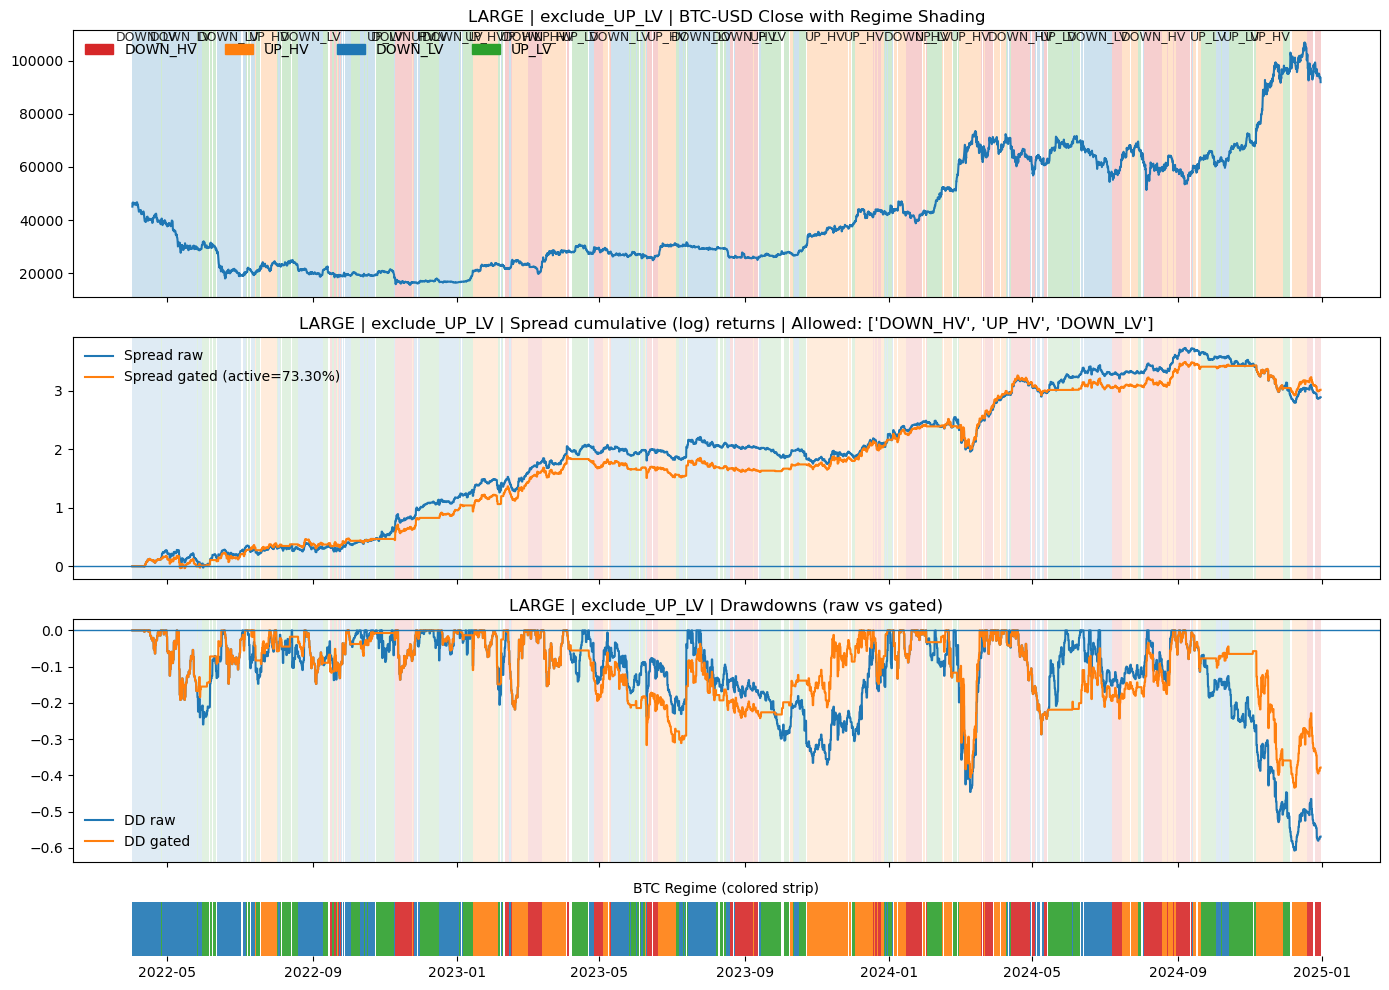

mean       std     n  hit_rate  frac_time    sharpe
regime                                                          
DOWN_HV  0.000883  0.015120  1068  0.177903   0.177232  2.731625
UP_HV    0.000692  0.019637  1670  0.176647   0.277132  1.649878
DOWN_LV  0.000546  0.015802  1679  0.171531   0.278626  1.617379
UP_LV   -0.000079  0.015072  1609  0.170914   0.267010 -0.244325

In [142]:
# Example: plot LARGE exclude UP_LV
allowed = res_large_A["experiments"]["exclude_UP_LV"]["allowed_regimes"]
gated_lr, active = gate_log_returns_by_regime(spread_large["spread_d0_d9"], regime_s, allowed)

gated_df = pd.DataFrame({"ret_gated": gated_lr}, index=gated_lr.index)

plot_bucket_regime_diagnostics(
    bucket_name="LARGE | exclude_UP_LV",
    df_diag=df_diag,            # your full df with BTC close etc
    btc_reg=btc_reg,            # your btc regime df
    spread_df=spread_large,     # has 'spread_d0_d9'
    # gated_df=gated_df,          # has 'ret_gated'
    allowed_regimes=allowed,
    btc_ticker="BTC-USD",
)

In [143]:
gated_lr.head()

date
2022-04-11 08:00:00   -0.003903
2022-04-11 20:00:00    0.020741
2022-04-12 08:00:00    0.021427
2022-04-12 20:00:00    0.026364
2022-04-13 08:00:00    0.014375
Name: spread_d0_d9, dtype: float64

In [146]:
gated_df.head()

ret_gated
date                          
2022-04-11 08:00:00  -0.003903
2022-04-11 20:00:00   0.020741
2022-04-12 08:00:00   0.021427
2022-04-12 20:00:00   0.026364
2022-04-13 08:00:00   0.014375

## Running Granular Experiments on BTC Regimes based on Trend and Volatility

In [150]:
import numpy as np
import pandas as pd

BARS_PER_DAY = 6

def _get_btc_close(df_diag, btc_ticker="BTC-USD", date_col="date", ticker_col="ticker", close_col="close"):
    btc = df_diag.loc[df_diag[ticker_col] == btc_ticker, [date_col, close_col]].copy()
    btc[date_col] = pd.to_datetime(btc[date_col])
    btc = btc.drop_duplicates(subset=[date_col]).sort_values(date_col).set_index(date_col)[close_col].astype(float)
    return btc

def _rolling_tercile_bins(x: pd.Series, window: int) -> pd.Series:
    """
    Returns 0/1/2 bins based on rolling tercile cutpoints computed from *past* data.
    Uses shift(1) to avoid lookahead.
    """
    x = x.copy()
    q33 = x.rolling(window).quantile(1/3).shift(1)
    q67 = x.rolling(window).quantile(2/3).shift(1)

    b = pd.Series(index=x.index, dtype="float")
    b[x < q33] = 0
    b[(x >= q33) & (x <= q67)] = 1
    b[x > q67] = 2
    return b

def build_btc_quantile_regimes(
    df_diag: pd.DataFrame,
    btc_ticker: str = "BTC-USD",
    date_col: str = "date",
    ticker_col: str = "ticker",
    close_col: str = "close",
    mom_days: int = 30,              # trend horizon
    vol_days: int = 14,              # vol horizon
    q_window_days: int = 180,         # rolling window to estimate quantile cutpoints
) -> pd.DataFrame:
    btc_close = _get_btc_close(df_diag, btc_ticker, date_col, ticker_col, close_col)
    btc_lr = np.log(btc_close).diff()

    mom_w = mom_days * BARS_PER_DAY
    vol_w = vol_days * BARS_PER_DAY
    q_w   = q_window_days * BARS_PER_DAY

    # Features
    mom = btc_lr.rolling(mom_w).sum()            # 30D log return
    rv  = btc_lr.rolling(vol_w).std()            # 14D realized vol per bar

    # Rolling tercile bins (avoid lookahead)
    mom_bin = _rolling_tercile_bins(mom, window=q_w)
    vol_bin = _rolling_tercile_bins(rv,  window=q_w)

    mom_lbl = mom_bin.map({0: "DOWN", 1: "MID", 2: "UP"})
    vol_lbl = vol_bin.map({0: "LV",   1: "MV",  2: "HV"})

    reg = (mom_lbl.astype(str) + "_" + vol_lbl.astype(str)).where(mom_lbl.notna() & vol_lbl.notna())

    out = pd.DataFrame({
        "btc_close": btc_close,
        "btc_lr": btc_lr,
        "btc_mom": mom,
        "btc_rv": rv,
        "btc_regime_q": reg,
    }).dropna(subset=["btc_regime_q"])

    return out


In [154]:
# Build regimes
btc_q = build_btc_quantile_regimes(
    df_diag=df_diag,
    btc_ticker="BTC-USD",
    mom_days=30,
    vol_days=14,
    q_window_days=180,
)

regime_s_q = btc_q["btc_regime_q"]  # Series, indexed by datetime

# Your spread series must be log returns per bar, indexed by datetime
large_tbl_q = regime_summary_table(spread_large["spread_d0_d9"], regime_s_q)
small_tbl_q = regime_summary_table(spread_small["spread_d0_d9"], regime_s_q)

print("=== LARGE quantile-regime table ===")
print(large_tbl_q)
print("\n=== SMALL quantile-regime table ===")
print(small_tbl_q)


=== LARGE quantile-regime table ===
             mean       std    n  hit_rate  frac_time    sharpe
regime                                                         
MID_MV   0.003498  0.022561  138  0.528986   0.086957  7.256360
MID_HV   0.004112  0.026650  135  0.548148   0.085066  7.220004
DOWN_MV  0.003327  0.027172  162  0.537037   0.102079  5.730126
UP_MV    0.001508  0.035186  191  0.528796   0.120353  2.005158
MID_LV   0.000603  0.022673  157  0.471338   0.098929  1.243939
UP_LV    0.000641  0.027579  200  0.520000   0.126024  1.087142
UP_HV    0.000852  0.043577  260  0.530769   0.163831  0.914485
DOWN_LV  0.000274  0.022962  171  0.532164   0.107750  0.559128
DOWN_HV  0.000060  0.023767  173  0.497110   0.109011  0.117425

=== SMALL quantile-regime table ===
             mean       std    n  hit_rate  frac_time     sharpe
regime                                                          
DOWN_HV  0.008153  0.023010  170  0.600000   0.107800  16.581450
DOWN_MV  0.004326  0.021622 

In [157]:
def allowed_by_excluding_bottom_k(regime_table: pd.DataFrame, k_exclude: int) -> list[str]:
    ranked = regime_table.sort_values("sharpe", ascending=True).index.tolist()  # worst first
    bad = set(ranked[:k_exclude])
    allowed = [r for r in regime_table.index.tolist() if r not in bad]
    return allowed

def run_quantile_step_a(bucket_name: str, spread_df: pd.DataFrame, regime_s: pd.Series, regime_table: pd.DataFrame, k_list=(1,2)):
    spread = spread_df["spread_d0_d9"].copy()
    raw_metrics = perf_metrics_via_strategy_performance(spread, name=f"{bucket_name}_raw")

    out = {}
    for k in k_list:
        allowed = allowed_by_excluding_bottom_k(regime_table, k_exclude=k)
        gated, active = gate_log_returns_by_regime(spread, regime_s, allowed)
        gated_metrics = perf_metrics_via_strategy_performance(gated, name=f"{bucket_name}_excludeBottom{k}")
        out[f"exclude_bottom_{k}"] = dict(allowed_regimes=allowed, active_frac=active, raw=raw_metrics, gated=gated_metrics)

    return out

large_Aq = run_quantile_step_a("LARGE_Q", spread_large, regime_s_q, large_tbl_q, k_list=(1,2))
small_Aq = run_quantile_step_a("SMALL_Q", spread_small, regime_s_q, small_tbl_q, k_list=(1,2))

for label, e in large_Aq.items():
    print("\nLARGE", label, f"active={100*e['active_frac']:.1f}%")
    print("RAW ", e["raw"]["annualized_sharpe_ratio"], e["raw"]["max_drawdown"])
    print("GATE", e["gated"]["annualized_sharpe_ratio"], e["gated"]["max_drawdown"])

for label, e in small_Aq.items():
    print("\nSMALL", label, f"active={100*e['active_frac']:.1f}%")
    print("RAW ", e["raw"]["annualized_sharpe_ratio"], e["raw"]["max_drawdown"])
    print("GATE", e["gated"]["annualized_sharpe_ratio"], e["gated"]["max_drawdown"])



LARGE exclude_bottom_1 active=71.2%
RAW  3.0311282487903957 -0.607640361984675
GATE 2.750712331810048 -0.6076403619846752

LARGE exclude_bottom_2 active=62.6%
RAW  3.0311282487903957 -0.607640361984675
GATE 2.761914927716093 -0.607640361984675

SMALL exclude_bottom_1 active=65.8%
RAW  6.8304579815145905 -0.5482406686312059
GATE 6.900617848667494 -0.25582155928897493

SMALL exclude_bottom_2 active=57.3%
RAW  6.8304579815145905 -0.5482406686312059
GATE 6.8956642217498185 -0.25167019238059984


## Walk Forward Analysis on Regime Gating

In [420]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats as scipy_stats

# -----------------------------
# Constants for 4h crypto bars
# -----------------------------
BARS_PER_DAY = 6
ANNUAL_DAYS = 365
ANNUAL_BARS = ANNUAL_DAYS * BARS_PER_DAY  # 2190

REGIME_COLORS = {
    "DOWN_HV": "#d62728",
    "UP_HV":   "#ff7f0e",
    "DOWN_LV": "#1f77b4",
    "UP_LV":   "#2ca02c",
}

# =============================
# Helpers: series prep
# =============================
def _to_datetime_indexed(s: pd.Series) -> pd.Series:
    s = pd.Series(s).copy()
    s.index = pd.to_datetime(s.index)
    s = s[~s.index.duplicated(keep="last")].sort_index()
    return s

def prep_regime_series(btc_reg: pd.DataFrame, date_col="date", regime_col="btc_regime") -> pd.Series:
    if date_col in btc_reg.columns:
        d = btc_reg[[date_col, regime_col]].copy()
        d[date_col] = pd.to_datetime(d[date_col])
        d = d.drop_duplicates(subset=[date_col]).sort_values(date_col).set_index(date_col)[regime_col]
        return _to_datetime_indexed(d).dropna()
    else:
        if regime_col in btc_reg.columns:
            return _to_datetime_indexed(btc_reg[regime_col]).dropna()
        raise ValueError(f"btc_reg must contain '{regime_col}' or a '{date_col}' column.")

def prep_return_series(spread_df_or_series, col: str = "spread_d0_d9") -> pd.Series:
    """
    IMPORTANT: This returns a *research series* (not necessarily tradable returns).
    We will only compute realistic metrics after normalizing/aggregating.
    """
    if isinstance(spread_df_or_series, pd.DataFrame):
        s = spread_df_or_series[col].copy()
    else:
        s = pd.Series(spread_df_or_series).copy()
    return _to_datetime_indexed(s).dropna()

# =============================
# Realistic evaluation utilities
# =============================
def aggregate_logret_to_daily(lr_bar: pd.Series) -> pd.Series:
    """
    Aggregate 4h log returns into daily log returns (sum within each day).
    """
    lr_bar = _to_datetime_indexed(lr_bar).fillna(0.0)
    # day buckets (UTC-ish based on timestamp)
    lr_day = lr_bar.groupby(lr_bar.index.floor("D")).sum()
    lr_day = lr_day[lr_day.index.notna()].sort_index()
    return lr_day

def equity_and_drawdown_from_logret(lr: pd.Series):
    lr = _to_datetime_indexed(lr).fillna(0.0)
    cum_log = lr.cumsum()
    eq = np.exp(cum_log)
    peak = np.maximum.accumulate(eq)
    dd = (eq / peak) - 1.0
    return cum_log, eq, dd

def max_drawdown_duration(dd: pd.Series) -> pd.Timedelta:
    dd = pd.Series(dd).copy()
    idx = dd.index
    underwater = dd < 0
    if not underwater.any():
        return pd.Timedelta(0)

    start = None
    episodes = []
    for t, is_under in zip(idx, underwater.values):
        if is_under and start is None:
            start = t
        if (not is_under) and start is not None:
            episodes.append((start, t))
            start = None
    if start is not None:
        episodes.append((start, idx[-1]))

    t_min = dd.idxmin()
    for s, e in episodes:
        if s <= t_min <= e:
            return pd.Timestamp(e) - pd.Timestamp(s)
    return pd.Timedelta(0)

def cagr_from_equity(eq: pd.Series) -> float:
    """
    CAGR computed from start/end equity and *actual elapsed time*.
    """
    eq = pd.Series(eq).dropna()
    if len(eq) < 2:
        return np.nan
    start = eq.index.min()
    end = eq.index.max()
    years = (pd.Timestamp(end) - pd.Timestamp(start)).total_seconds() / (365.0 * 24 * 3600)
    if years <= 0:
        return np.nan
    return float(eq.iloc[-1] ** (1 / years) - 1)

def performance_from_logret_realistic(
    lr_bar: pd.Series,
    name: str = "series",
    use_daily_stats: bool = True,
) -> dict:
    """
    More realistic metrics for research:

    - Equity/DD still computed from per-bar log returns (fine for path diagnostics).
    - Annualized mean/vol/Sharpe/t-stat computed on DAILY aggregated log returns by default.
    - Annualized return is CAGR based on actual elapsed time (not exp(mean*annual_bars)).
    - Also report total_simple_return over the OOS window.
    """
    lr_bar = _to_datetime_indexed(lr_bar).dropna()
    if len(lr_bar) < 10:
        return {
            "total_simple_return": np.nan,
            "cagr": np.nan,
            "ann_vol": np.nan,
            "sharpe": np.nan,
            "calmar": np.nan,
            "max_drawdown": np.nan,
            "max_drawdown_duration": pd.Timedelta(0),
            "hit_rate": np.nan,
            "t_statistic": np.nan,
            "p_value": np.nan,
            "n_bars": len(lr_bar),
            "n_days": np.nan,
            "name": name,
        }

    # Path / drawdown from bar series
    cum_log, eq, dd = equity_and_drawdown_from_logret(lr_bar)
    total_simple = float(eq.iloc[-1] - 1.0)
    mdd = float(dd.min())
    dd_dur = max_drawdown_duration(dd)

    # Stats series for Sharpe/t-stats
    if use_daily_stats:
        lr_stats = aggregate_logret_to_daily(lr_bar)
        ann_factor = ANNUAL_DAYS
        n = len(lr_stats)
        hit_rate = float((lr_stats > 0).mean())
    else:
        lr_stats = lr_bar
        ann_factor = ANNUAL_BARS
        n = len(lr_stats)
        hit_rate = float((lr_stats > 0).mean())

    mu = float(lr_stats.mean())
    sd = float(lr_stats.std(ddof=1))
    ann_vol = float(sd * np.sqrt(ann_factor)) if sd > 0 else np.nan
    sharpe = float((mu / sd) * np.sqrt(ann_factor)) if sd > 0 else np.nan

    # t-stat on mean(logret)
    if sd > 0 and n > 2:
        t_stat = float(mu / (sd / np.sqrt(n)))
        p_val = float(2 * (1 - scipy_stats.t.cdf(abs(t_stat), df=n-1)))
    else:
        t_stat, p_val = np.nan, np.nan

    # CAGR from actual elapsed time
    cagr = cagr_from_equity(eq)

    calmar = float(cagr / abs(mdd)) if (mdd < 0 and np.isfinite(cagr)) else np.nan

    return {
        "total_simple_return": total_simple,
        "cagr": cagr,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "calmar": calmar,
        "max_drawdown": mdd,
        "max_drawdown_duration": dd_dur,
        "hit_rate": hit_rate,
        "t_statistic": t_stat,
        "p_value": p_val,
        "n_bars": int(len(lr_bar)),
        "n_days": int(len(aggregate_logret_to_daily(lr_bar))),
        "name": name,
    }

# =============================
# Regime tables + gating
# =============================
def regime_summary_table(lr_bar: pd.Series, regime_s: pd.Series, use_daily_stats: bool = True) -> pd.DataFrame:
    lr_bar = _to_datetime_indexed(lr_bar).dropna()
    reg = _to_datetime_indexed(regime_s).reindex(lr_bar.index)

    d = pd.DataFrame({"lr_bar": lr_bar, "regime": reg}).dropna(subset=["lr_bar", "regime"])

    if use_daily_stats:
        # daily aggregate within each regime label per bar -> daily by summing within day then stats
        d["day"] = d.index.floor("D")
        g = d.groupby(["day", "regime"])["lr_bar"].sum().reset_index()
        # stats by regime on daily lr
        grp = g.groupby("regime")["lr_bar"]
        ann_factor = ANNUAL_DAYS
    else:
        grp = d.groupby("regime")["lr_bar"]
        ann_factor = ANNUAL_BARS

    out = grp.agg(["mean", "std", "count"]).rename(columns={"count": "n"})
    out["hit_rate"] = grp.apply(lambda x: float((x > 0).mean()))
    out["frac_time"] = out["n"] / out["n"].sum()
    out["sharpe"] = (out["mean"] / out["std"]).replace([np.inf, -np.inf], np.nan) * np.sqrt(ann_factor)

    return out.sort_values("sharpe", ascending=False)

def gate_logret_by_regime(lr: pd.Series, regime_s: pd.Series, allowed_regimes: list[str]) -> tuple[pd.Series, float]:
    lr = _to_datetime_indexed(lr).dropna()
    reg = _to_datetime_indexed(regime_s).reindex(lr.index)
    active = reg.isin(allowed_regimes)
    gated = lr.where(active, 0.0)
    return gated, float(active.mean())

def pick_allowed_regimes(
    reg_tbl: pd.DataFrame,
    rule: str,
    k: int | None = None,
    exclude_regime: str | None = None,
    exclude_bottom_k: int | None = None,
) -> list[str]:
    ranked = reg_tbl.index.tolist()
    if rule == "all":
        return ranked
    if rule == "exclude_regime":
        if exclude_regime is None:
            raise ValueError("exclude_regime required for rule='exclude_regime'")
        return [r for r in ranked if r != exclude_regime]
    if rule == "top_k":
        if k is None:
            raise ValueError("k required for rule='top_k'")
        return ranked[:k]
    if rule == "exclude_bottom_k":
        if exclude_bottom_k is None:
            raise ValueError("exclude_bottom_k required for rule='exclude_bottom_k'")
        worst_first = reg_tbl.sort_values("sharpe", ascending=True).index.tolist()
        bad = set(worst_first[:exclude_bottom_k])
        return [r for r in ranked if r not in bad]
    raise ValueError(f"Unknown rule={rule}")

# =============================
# Walk-forward (train/test)
# =============================
def walk_forward_regime_gating(
    bucket_name: str,
    lr: pd.Series,
    regime_s: pd.Series,
    train_days: int = 180,
    test_days: int = 30,
    rule: str = "exclude_regime",
    k: int | None = None,
    exclude_regime: str | None = None,
    exclude_bottom_k: int | None = None,
    min_regime_days: int = 30,
    use_daily_stats: bool = True,
):
    """
    Same WF structure, but metrics are now "realistic":
      - report TOTAL OOS return + CAGR based on real elapsed time
      - Sharpe/t-stat based on daily aggregated log returns by default
    """
    lr = _to_datetime_indexed(lr).dropna()
    regime_s = _to_datetime_indexed(regime_s).dropna()

    reg = regime_s.reindex(lr.index)
    mask = reg.notna()
    lr = lr[mask]
    reg = reg[mask]

    train_bars = train_days * BARS_PER_DAY
    test_bars  = test_days  * BARS_PER_DAY
    min_regime_bars = min_regime_days * BARS_PER_DAY

    idx = lr.index
    start_bar = train_bars
    folds = []
    oos_raw_parts = []
    oos_gate_parts = []

    fold_id = 0
    while start_bar + test_bars <= len(idx):
        fold_id += 1
        train_slice = slice(0, start_bar)
        test_slice  = slice(start_bar, start_bar + test_bars)

        lr_is = lr.iloc[train_slice]
        reg_is = reg.iloc[train_slice]

        lr_oos = lr.iloc[test_slice]
        reg_oos = reg.iloc[test_slice]

        reg_tbl_is = regime_summary_table(lr_is, reg_is, use_daily_stats=use_daily_stats)

        # optional stability filter
        if min_regime_bars is not None and min_regime_bars > 0 and ("n" in reg_tbl_is.columns):
            # NOTE: n counts days if use_daily_stats=True, else bars
            # So compare with min_regime_days (in days) in daily mode
            if use_daily_stats:
                reg_tbl_is = reg_tbl_is[reg_tbl_is["n"] >= min_regime_days]
            else:
                reg_tbl_is = reg_tbl_is[reg_tbl_is["n"] >= min_regime_bars]
            if reg_tbl_is.empty:
                reg_tbl_is = regime_summary_table(lr_is, reg_is, use_daily_stats=use_daily_stats)

        allowed = pick_allowed_regimes(
            reg_tbl_is, rule=rule, k=k, exclude_regime=exclude_regime, exclude_bottom_k=exclude_bottom_k
        )
        lr_gate_oos, active_frac = gate_logret_by_regime(lr_oos, reg_oos, allowed)

        m_raw = performance_from_logret_realistic(lr_oos, name=f"{bucket_name}_fold{fold_id}_raw", use_daily_stats=use_daily_stats)
        m_gate = performance_from_logret_realistic(lr_gate_oos, name=f"{bucket_name}_fold{fold_id}_gated", use_daily_stats=use_daily_stats)

        folds.append({
            "bucket": bucket_name,
            "fold": fold_id,
            "train_start": lr_is.index.min(),
            "train_end": lr_is.index.max(),
            "test_start": lr_oos.index.min(),
            "test_end": lr_oos.index.max(),
            "rule": rule,
            "k": k,
            "exclude_regime": exclude_regime,
            "exclude_bottom_k": exclude_bottom_k,
            "allowed_regimes": allowed,
            "n_allowed": len(allowed),
            "active_frac": active_frac,

            # raw (realistic)
            "oos_raw_total_ret": m_raw["total_simple_return"],
            "oos_raw_cagr": m_raw["cagr"],
            "oos_raw_sharpe": m_raw["sharpe"],
            "oos_raw_ann_vol": m_raw["ann_vol"],
            "oos_raw_mdd": m_raw["max_drawdown"],
            "oos_raw_calmar": m_raw["calmar"],

            # gated (realistic)
            "oos_gate_total_ret": m_gate["total_simple_return"],
            "oos_gate_cagr": m_gate["cagr"],
            "oos_gate_sharpe": m_gate["sharpe"],
            "oos_gate_ann_vol": m_gate["ann_vol"],
            "oos_gate_mdd": m_gate["max_drawdown"],
            "oos_gate_calmar": m_gate["calmar"],
        })

        oos_raw_parts.append(lr_oos)
        oos_gate_parts.append(lr_gate_oos)

        start_bar += test_bars  # expanding window

    fold_df = pd.DataFrame(folds)
    oos_raw = pd.concat(oos_raw_parts).sort_index()
    oos_gate = pd.concat(oos_gate_parts).sort_index()

    oos_summary_raw = performance_from_logret_realistic(oos_raw, name=f"{bucket_name}_OOS_RAW", use_daily_stats=use_daily_stats)
    oos_summary_gate = performance_from_logret_realistic(oos_gate, name=f"{bucket_name}_OOS_GATED", use_daily_stats=use_daily_stats)

    oos_reg = reg.reindex(oos_raw.index)
    oos_tbl_raw = regime_summary_table(oos_raw, oos_reg, use_daily_stats=use_daily_stats)
    oos_tbl_gate = regime_summary_table(oos_gate, oos_reg, use_daily_stats=use_daily_stats)

    return {
        "fold_table": fold_df,
        "oos_logret_raw": oos_raw,
        "oos_logret_gated": oos_gate,
        "oos_regime": oos_reg,
        "oos_summary_raw": oos_summary_raw,
        "oos_summary_gated": oos_summary_gate,
        "oos_regime_table_raw": oos_tbl_raw,
        "oos_regime_table_gated": oos_tbl_gate,
        "use_daily_stats": use_daily_stats,
    }

# =============================
# Plotting with regime shading
# =============================
def build_regime_blocks(regime_s: pd.Series) -> pd.DataFrame:
    s = _to_datetime_indexed(regime_s).dropna()
    if s.empty:
        return pd.DataFrame(columns=["start","end","regime"])
    df = s.rename("regime").to_frame()
    df["gid"] = (df["regime"] != df["regime"].shift()).cumsum()
    blocks = df.groupby("gid").agg(
        start=("regime", lambda x: x.index.min()),
        end=("regime", lambda x: x.index.max()),
        regime=("regime", "first"),
    ).reset_index(drop=True)
    return blocks

def shade_regime_blocks(ax, blocks: pd.DataFrame, colors: dict, alpha: float = 0.22, label_blocks: bool = True, min_label_bars: int = 6*10):
    for _, row in blocks.iterrows():
        r = row["regime"]
        c = colors.get(r, "grey")
        ax.axvspan(row["start"], row["end"], facecolor=c, alpha=alpha, linewidth=0)

        if label_blocks:
            dur = (pd.Timestamp(row["end"]) - pd.Timestamp(row["start"]))
            bars_est = int(dur / pd.Timedelta(hours=4)) + 1
            if bars_est >= min_label_bars:
                mid = row["start"] + (row["end"] - row["start"]) / 2
                y_top = ax.get_ylim()[1]
                ax.text(mid, y_top, r, ha="center", va="top", fontsize=9, alpha=0.85)

def add_regime_legend(ax, colors: dict, order=None):
    if order is None:
        order = list(colors.keys())
    patches = [mpatches.Patch(color=colors[k], label=k) for k in order if k in colors]
    ax.legend(handles=patches, loc="upper left", ncol=4, frameon=False)

def plot_oos_diagnostics(
    wf_res: dict,
    bucket_name: str,
    colors: dict = REGIME_COLORS,
    shade_alpha: float = 0.26,
    log_equity: bool = False,  # << default linear now
):
    lr_raw = wf_res["oos_logret_raw"]
    lr_gate = wf_res["oos_logret_gated"]
    reg_oos = wf_res["oos_regime"]

    blocks = build_regime_blocks(reg_oos)

    _, raw_eq, raw_dd = equity_and_drawdown_from_logret(lr_raw)
    _, gate_eq, gate_dd = equity_and_drawdown_from_logret(lr_gate)

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(raw_eq.index, raw_eq.values, label="OOS Equity (raw)")
    axes[0].plot(gate_eq.index, gate_eq.values, label="OOS Equity (gated)")
    axes[0].set_title(f"{bucket_name} | OOS Equity (raw vs gated) with BTC regime shading")
    if log_equity:
        axes[0].set_yscale("log")
    shade_regime_blocks(axes[0], blocks, colors, alpha=shade_alpha, label_blocks=True, min_label_bars=6*10)
    add_regime_legend(axes[0], colors)
    axes[0].legend(loc="upper left", frameon=False)

    axes[1].plot(raw_dd.index, raw_dd.values, label="OOS DD (raw)")
    axes[1].plot(gate_dd.index, gate_dd.values, label="OOS DD (gated)")
    axes[1].axhline(0.0, linewidth=1)
    axes[1].set_title(f"{bucket_name} | OOS Drawdown (raw vs gated)")
    shade_regime_blocks(axes[1], blocks, colors, alpha=shade_alpha*0.7, label_blocks=False)
    axes[1].legend(loc="lower left", frameon=False)

    plt.tight_layout()
    plt.show()

def plot_oos_regime_cumulative(wf_res: dict, bucket_name: str):
    """
    Cumulative log PnL attribution by regime for RAW OOS.
    """
    lr = wf_res["oos_logret_raw"].copy()
    reg = wf_res["oos_regime"].reindex(lr.index)

    d = pd.DataFrame({"lr": lr, "regime": reg}).dropna()
    regimes = d["regime"].unique().tolist()

    plt.figure(figsize=(14, 5))
    for r in regimes:
        x = d.loc[d["regime"] == r, "lr"].copy()
        x = x.reindex(d.index, fill_value=0.0)
        plt.plot(x.index, x.cumsum().values, label=r)

    plt.title(f"{bucket_name} | OOS cumulative log PnL by regime (raw)")
    plt.axhline(0.0, linewidth=1)
    plt.legend(ncol=4, frameon=False)
    plt.tight_layout()
    plt.show()


{'total_simple_return': 1.9205698308792138, 'cagr': 1.3876238038856656, 'ann_vol': 0.8507926563893663, 'sharpe': 1.021790258805882, 'calmar': 2.283626781067353, 'max_drawdown': -0.6076403619846755, 'max_drawdown_duration': Timedelta('110 days 12:00:00'), 'hit_rate': 0.54, 't_statistic': 1.1345446251367801, 'p_value': 0.25717149259354555, 'n_bars': 900, 'n_days': 450, 'name': 'LARGE_4REG_OOS_RAW'}
{'total_simple_return': 3.052428813193173, 'cagr': 2.1151073124402386, 'ann_vol': 0.7259645813425356, 'sharpe': 1.563438652413933, 'calmar': 4.872322478217973, 'max_drawdown': -0.43410659329220513, 'max_drawdown_duration': Timedelta('110 days 12:00:00'), 'hit_rate': 0.4311111111111111, 't_statistic': 1.7359638189350755, 'p_value': 0.0832562258413676, 'n_bars': 900, 'n_days': 450, 'name': 'LARGE_4REG_OOS_GATED'}
       bucket  fold         train_start           train_end  \
0  LARGE_4REG     1 2022-04-11 08:00:00 2023-10-03 20:00:00   
1  LARGE_4REG     2 2022-04-11 08:00:00 2024-01-01 20:00:00

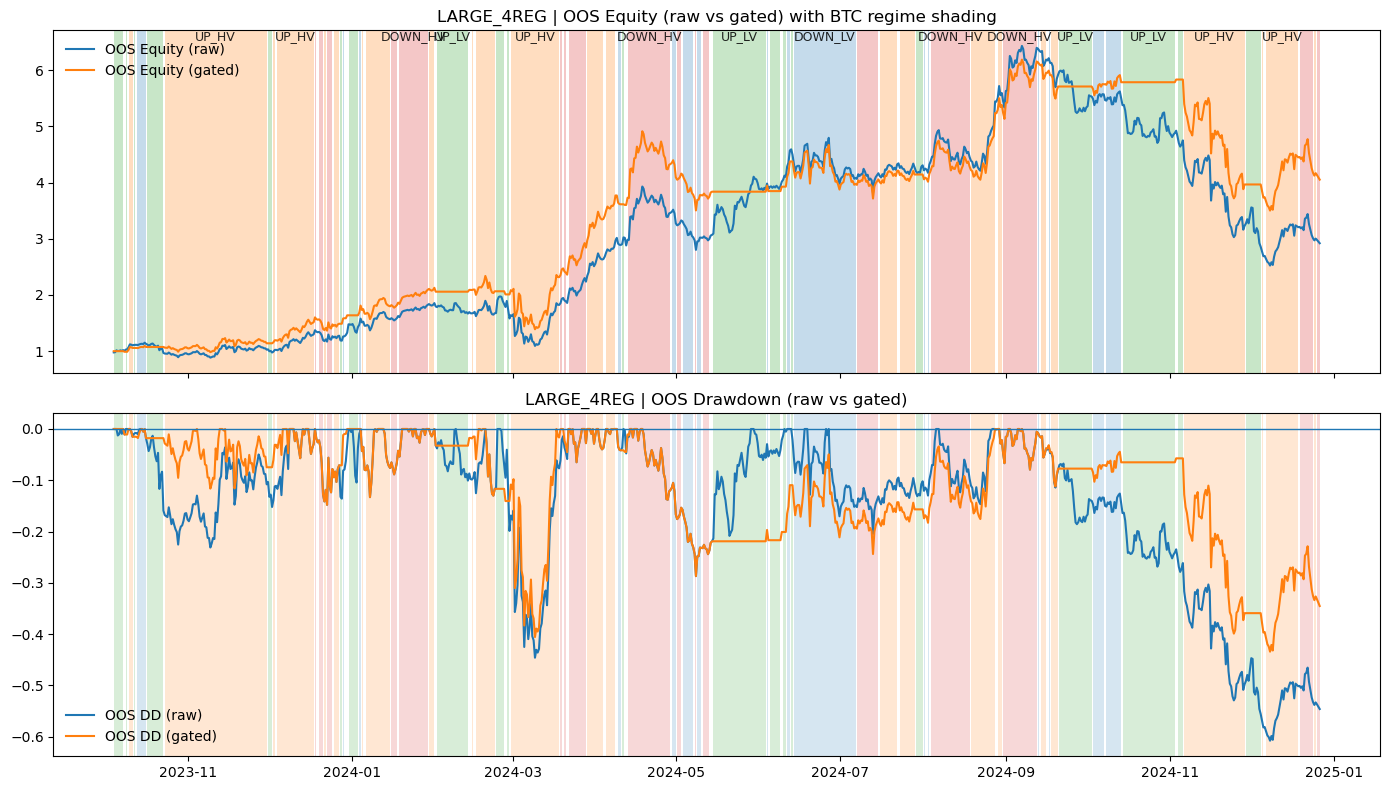

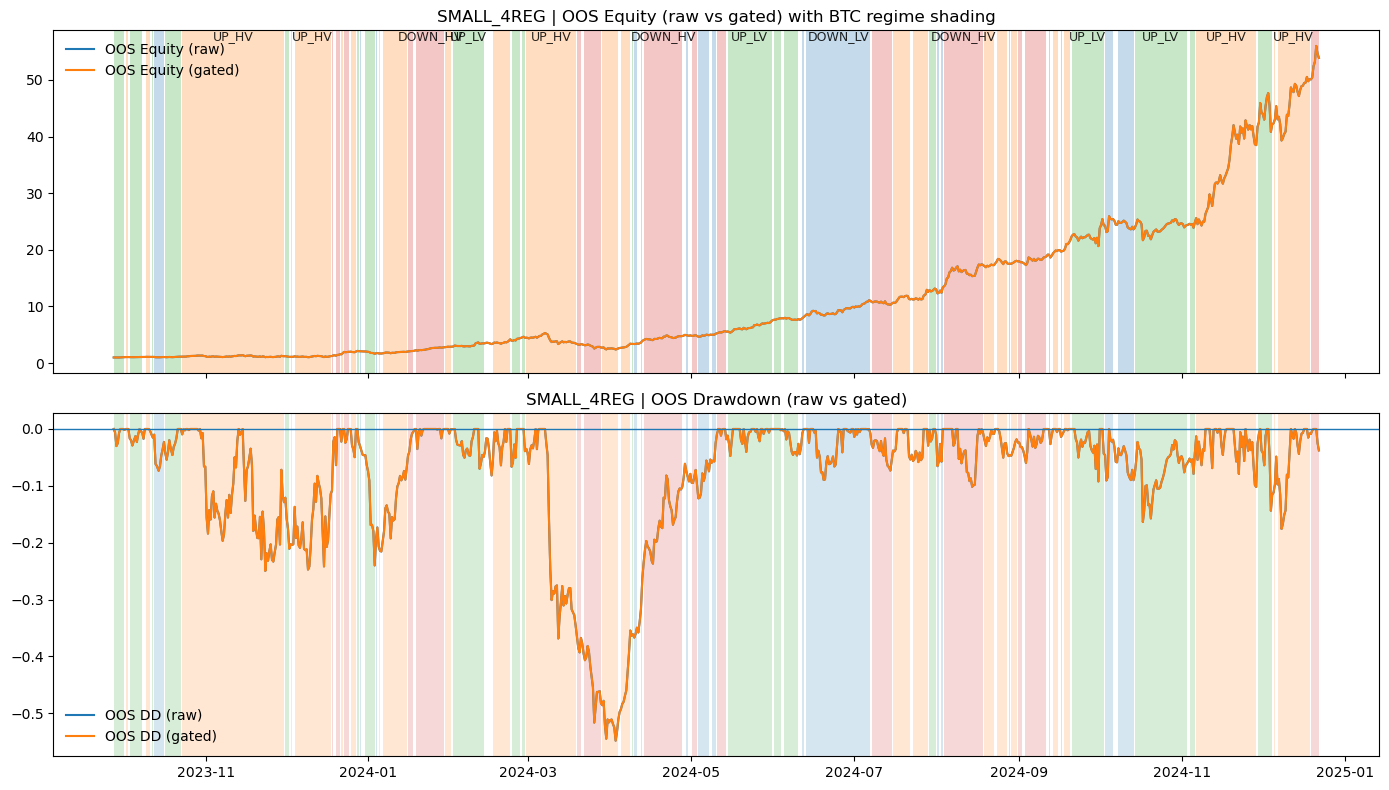

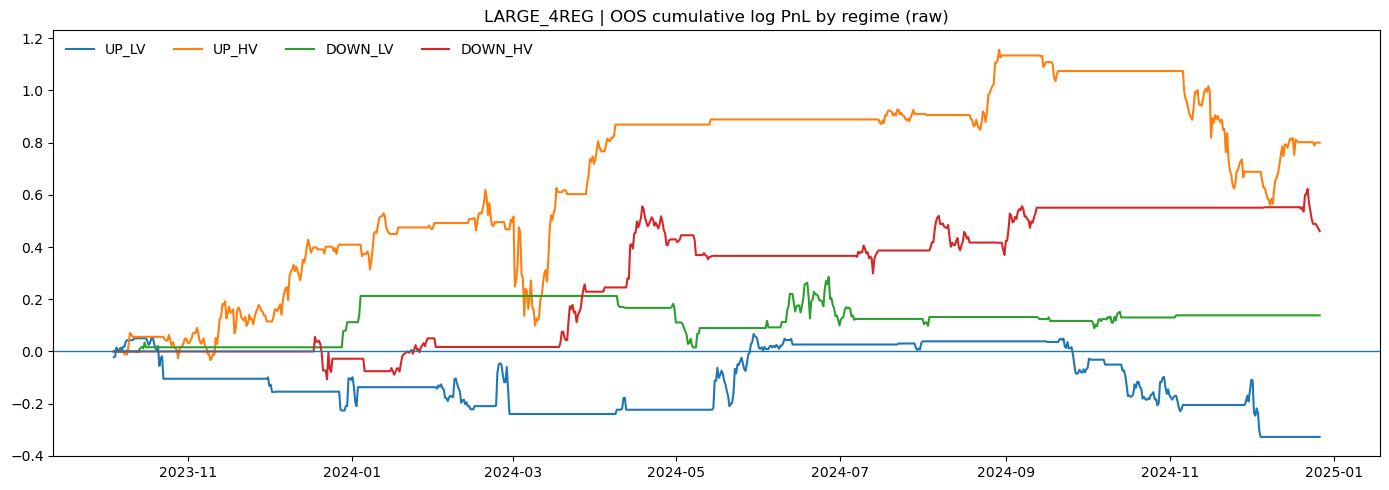

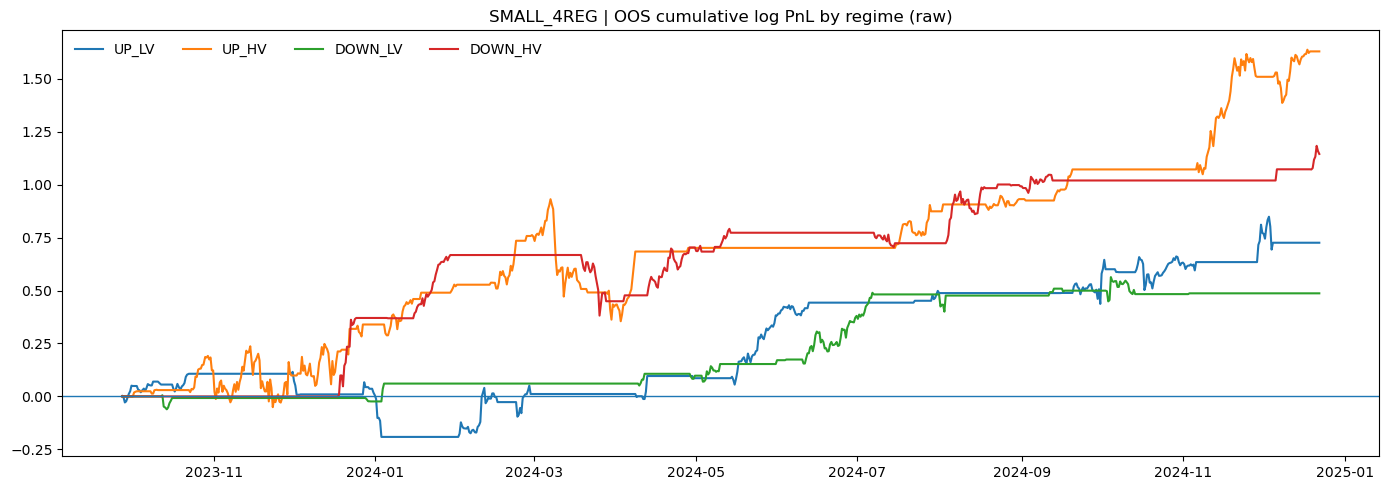

In [422]:
regime_s = prep_regime_series(btc_reg, date_col="date", regime_col="btc_regime")

lr_large = prep_return_series(spread_large, col="spread_d0_d9")
lr_small = prep_return_series(spread_small, col="spread_d0_d9")

wf_large = walk_forward_regime_gating(
    bucket_name="LARGE_4REG",
    lr=lr_large,
    regime_s=regime_s,
    train_days=180,
    test_days=30,
    rule="exclude_regime",
    exclude_regime="UP_LV",
    use_daily_stats=True,   # << IMPORTANT
)

wf_small = walk_forward_regime_gating(
    bucket_name="SMALL_4REG",
    lr=lr_small,
    regime_s=regime_s,
    train_days=180,
    test_days=30,
    rule="all",
    use_daily_stats=True,   # << IMPORTANT
)

print(wf_large["oos_summary_raw"])
print(wf_large["oos_summary_gated"])
print(wf_large["fold_table"].head())

print(wf_small["oos_summary_raw"])
print(wf_small["oos_summary_gated"])
print(wf_small["fold_table"].head())

plot_oos_diagnostics(wf_large, "LARGE_4REG", log_equity=False)
plot_oos_diagnostics(wf_small, "SMALL_4REG", log_equity=False)

plot_oos_regime_cumulative(wf_large, "LARGE_4REG")
plot_oos_regime_cumulative(wf_small, "SMALL_4REG")


In [334]:
df_bucket[df_bucket['cap_bucket'] == 'SMALL'].head(20)

ticker                date    low   high   open  close     volume  \
223149  1INCH-USD 2022-04-01 08:00:00  1.738  1.772  1.757  1.747   43729.16   
223150  1INCH-USD 2022-04-01 12:00:00  1.710  1.831  1.744  1.816  149897.91   
223151  1INCH-USD 2022-04-01 16:00:00  1.809  1.885  1.819  1.880  167483.50   
223152  1INCH-USD 2022-04-01 20:00:00  1.856  1.890  1.881  1.882  219778.94   
223153  1INCH-USD 2022-04-02 00:00:00  1.869  1.953  1.879  1.928  228449.80   
223154  1INCH-USD 2022-04-02 04:00:00  1.899  1.934  1.928  1.921   77715.50   
223155  1INCH-USD 2022-04-02 08:00:00  1.907  2.098  1.918  2.019  631140.71   
223156  1INCH-USD 2022-04-02 12:00:00  1.919  2.031  2.017  1.975  296032.72   
223157  1INCH-USD 2022-04-02 16:00:00  1.922  2.018  1.973  1.977  408396.88   
223158  1INCH-USD 2022-04-02 20:00:00  1.901  1.995  1.979  1.922  154943.69   
223159  1INCH-USD 2022-04-03 00:00:00  1.874  1.991  1.924  1.948  242361.58   
223160  1INCH-USD 2022-04-03 04:00:00  1.948  2.006  1.948  1.988   62708.29   
223161  1INCH-USD 2022-04-03 08:00:00  1.945  2.028  1.986  1.975  119176.69   
223162  1INCH-USD 2022-04-03 12:00:00  1.951  1.987  1.977  1.978   61986.96   
223163  1INCH-USD 2022-04-03 16:00:00  1.944  1.987  1.976  1.948  111124.68   
223164  1INCH-USD 2022-04-03 20:00:00  1.942  1.993  1.946  1.982   63402.58   
223165  1INCH-USD 2022-04-04 00:00:00  1.917  1.990  1.983  1.961   87508.56   
223166  1INCH-USD 2022-04-04 04:00:00  1.954  2.004  1.965  1.983   65961.54   
223167  1INCH-USD 2022-04-04 08:00:00  1.895  1.985  1.980  1.944  102677.51   
223168  1INCH-USD 2022-04-04 12:00:00  1.845  1.954  1.942  1.845  177866.40   

        imputed  close_log_return_prev_4h  close_log_return_z_score_prev_4h  \
223149    False                  0.027146                          0.152888   
223150    False                 -0.004569                          0.127891   
223151    False                  0.038736                         -0.044778   
223152    False                  0.034635                          0.904957   
223153    False                  0.001063                          0.306189   
223154    False                  0.024148                          1.017239   
223155    False                 -0.003637                         -0.736465   
223156    False                  0.049756                          2.584977   
223157    False                 -0.022034                         -0.232044   
223158    False                  0.001012                          0.131457   
223159    False                 -0.028214                         -1.228952   
223160    False                  0.013437                          0.479846   
223161    False                  0.020326                          0.550382   
223162    False                 -0.006561                         -0.547467   
223163    False                  0.001518                         -0.123938   
223164    False                 -0.015283                         -0.696638   
223165    False                  0.017303                          0.085488   
223166    False                 -0.010652                          0.241130   
223167    False                  0.011156                          0.032284   
223168    False                 -0.019863                         -0.388005   

        fwd_open_log_return_12h  quantile_bucket  bottom_quintile_signal  \
223149                 0.068196                7                   False   
223150                 0.074558                6                   False   
223151                 0.058196                5                   False   
223152                 0.019479                8                   False   
223153                 0.070872                6                   False   
223154                 0.023072                9                   False   
223155                 0.031309                1                    True   
223156                -0.047205                9              

In [338]:
spread_small.head()

ret_long_d0  ret_short_d9  spread_d0_d9
date                                                        
2022-04-01 08:00:00     0.055042      0.031295      0.023747
2022-04-01 20:00:00     0.025620     -0.026813      0.052433
2022-04-02 08:00:00    -0.027265     -0.041997      0.014732
2022-04-02 20:00:00     0.020057      0.004300      0.015758
2022-04-03 08:00:00    -0.001778     -0.010822      0.009044

In [336]:
lr_small.head()

date
2022-04-01 08:00:00    0.023747
2022-04-01 20:00:00    0.052433
2022-04-02 08:00:00    0.014732
2022-04-02 20:00:00    0.015758
2022-04-03 08:00:00    0.009044
Name: spread_d0_d9, dtype: float64

In [358]:
train_days = 180
test_days = 30
rule = "all"
k = None
exclude_regime = None
exclude_bottom_k = None
annual_bars = ANNUAL_BARS
min_regime_days = 30

In [360]:
lr = _to_datetime_indexed(lr_small).dropna()
regime_s = _to_datetime_indexed(regime_s).dropna()

# Align and drop bars without a regime label
reg = regime_s.reindex(lr.index)
mask = reg.notna()
lr = lr[mask]
reg = reg[mask]

train_bars = train_days * BARS_PER_DAY
test_bars  = test_days  * BARS_PER_DAY
min_regime_bars = min_regime_days * BARS_PER_DAY

idx = lr.index
start_bar = train_bars
folds = []
oos_raw_parts = []
oos_gate_parts = []

In [362]:
fold_id = 0
# while start_bar + test_bars <= len(idx):
fold_id += 1
train_slice = slice(0, start_bar)
test_slice  = slice(start_bar, start_bar + test_bars)

lr_is = lr.iloc[train_slice]
reg_is = reg.iloc[train_slice]

lr_oos = lr.iloc[test_slice]
reg_oos = reg.iloc[test_slice]

# Training regime table
reg_tbl_is = regime_summary_table(lr_is, reg_is, annual_bars=annual_bars)

# Optional: drop regimes with too few training bars (stability)
if min_regime_bars is not None and min_regime_bars > 0:
    reg_tbl_is = reg_tbl_is[reg_tbl_is["n"] >= min_regime_bars]
    if reg_tbl_is.empty:
        # If nothing survives, fall back to "all" regimes observed in training
        reg_tbl_is = regime_summary_table(lr_is, reg_is, annual_bars=annual_bars)

allowed = pick_allowed_regimes(
    reg_tbl_is, rule=rule, k=k, exclude_regime=exclude_regime, exclude_bottom_k=exclude_bottom_k
)

lr_gate_oos, active_frac = gate_logret_by_regime(lr_oos, reg_oos, allowed)

# fold metrics
m_raw = performance_from_logret(lr_oos, annual_bars=annual_bars, name=f"{bucket_name}_fold{fold_id}_raw")
m_gate = performance_from_logret(lr_gate_oos, annual_bars=annual_bars, name=f"{bucket_name}_fold{fold_id}_gated")

In [364]:
allowed

['UP_LV', 'DOWN_LV', 'UP_HV']

In [368]:
reg_is.unique()

array(['DOWN_LV', 'UP_LV', 'UP_HV', 'DOWN_HV'], dtype=object)

In [370]:
k

In [374]:
rule

'all'

In [376]:
exclude_regime

In [378]:
m_raw

{'annualized_return': 5803.816920192653,
 'annualized_std_dev': 1.8931250018313346,
 'annualized_sharpe_ratio': 4.577850562934426,
 'calmar_ratio': 23241.487815532146,
 'max_drawdown': -0.2497179598078053,
 'max_drawdown_duration': Timedelta('35 days 00:00:00'),
 'hit_rate': 0.5611111111111111,
 't_statistic': 1.3124289656412524,
 'p_value': 0.19105579827185704,
 'name': 'SMALL_fold1_raw'}

In [404]:
lr_oos.mean()

0.003957280070930964

In [406]:
total_log = lr_oos.sum()
total_simple = np.expm1(total_log)

In [408]:
total_log

0.7123104127675736

In [410]:
total_simple

1.0386960509330936

In [412]:
mu_day = lr_oos.mean() * 6
mu_day

0.023743680425585785

In [414]:
daily_simple = np.expm1(mu_day)
daily_simple

0.024027805877184238

In [416]:
lr_oos.quantile([0.01, 0.05, 0.5, 0.95, 0.99])

0.01   -0.094312
0.05   -0.065301
0.50    0.004587
0.95    0.060778
0.99    0.122321
Name: spread_d0_d9, dtype: float64

In [418]:
lr_oos.abs().gt(0.05).mean()

0.18888888888888888

<Axes: xlabel='date'>

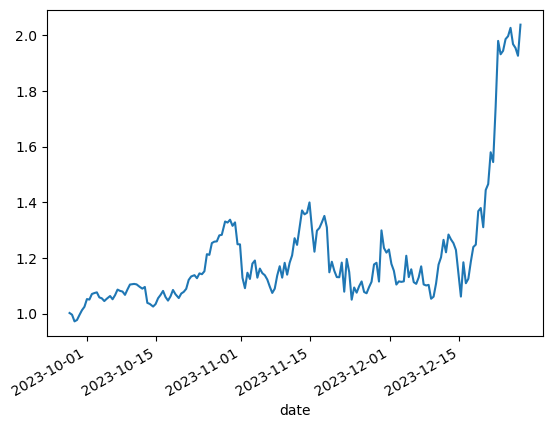

In [402]:
np.exp(lr_oos.cumsum()).plot()

<Axes: xlabel='date'>

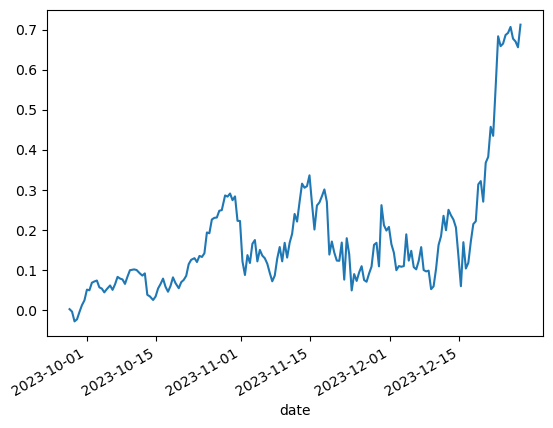

In [398]:
lr_oos.cumsum().plot()

<Axes: title={'center': 'Log Return Series'}, xlabel='date'>

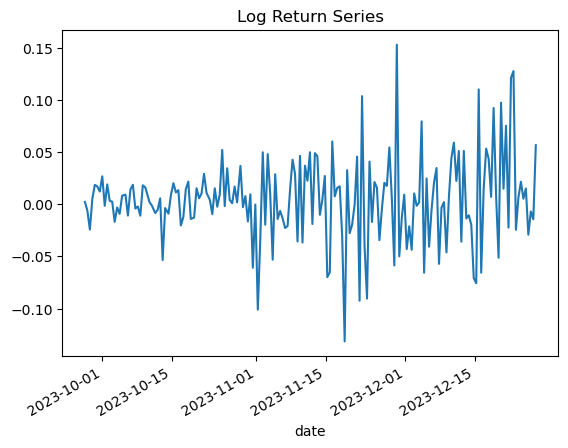

In [392]:
lr_oos.plot(title='Log Return Series')

In [384]:
# equity metrics
cum_log, eq, dd = equity_and_drawdown_from_logret(lr_oos)

# annualized return from log growth rate
# (mean logret * annual_bars) then convert back to simple
mu_lr = float(lr_oos.mean())
ann_log = mu_lr * annual_bars
ann_ret = float(np.expm1(ann_log))

# annualized vol (simple approach on log returns)
sd_lr = float(lr_oos.std(ddof=1))
ann_vol = float(sd_lr * np.sqrt(annual_bars))

sharpe = float((mu_lr / sd_lr) * np.sqrt(annual_bars)) if sd_lr > 0 else np.nan

mdd = float(dd.min())
dd_dur = max_drawdown_duration(dd)

calmar = float(ann_ret / abs(mdd)) if (mdd < 0) else np.nan

hit_rate = float((lr_oos > 0).mean())

In [386]:
ann_ret

5803.816920192653

In [388]:
mu_lr

0.003957280070930964

In [356]:
reg_tbl_is

mean       std    n  hit_rate  frac_time    sharpe
regime                                                         
UP_LV    0.004560  0.025850  299  0.558528   0.276852  8.255809
DOWN_LV  0.002781  0.033957  437  0.537757   0.404630  3.833285
UP_HV    0.001001  0.034149  192  0.541667   0.177778  1.372219

{'annualized_return': 12.571811333746124, 'annualized_std_dev': 1.5027129105186752, 'annualized_sharpe_ratio': 1.7355244154963239, 'calmar_ratio': 20.689559351660023, 'max_drawdown': -0.6076403619846755, 'max_drawdown_duration': Timedelta('110 days 12:00:00'), 'hit_rate': 0.5144444444444445, 't_statistic': 1.1125766090508393, 'p_value': 0.26618772280117087, 'name': 'LARGE_4REG_OOS_RAW'}
{'annualized_return': 16.24784888079142, 'annualized_std_dev': 1.2819055910689232, 'annualized_sharpe_ratio': 2.2214486409751784, 'calmar_ratio': 37.428247190557386, 'max_drawdown': -0.43410659329220525, 'max_drawdown_duration': Timedelta('110 days 12:00:00'), 'hit_rate': 0.35333333333333333, 't_statistic': 1.4240835646497965, 'p_value': 0.15476927878768976, 'name': 'LARGE_4REG_OOS_GATED'}
       bucket  fold         train_start           train_end  \
0  LARGE_4REG     1 2022-04-11 08:00:00 2023-10-03 20:00:00   
1  LARGE_4REG     2 2022-04-11 08:00:00 2024-01-01 20:00:00   
2  LARGE_4REG     3 2022-04-

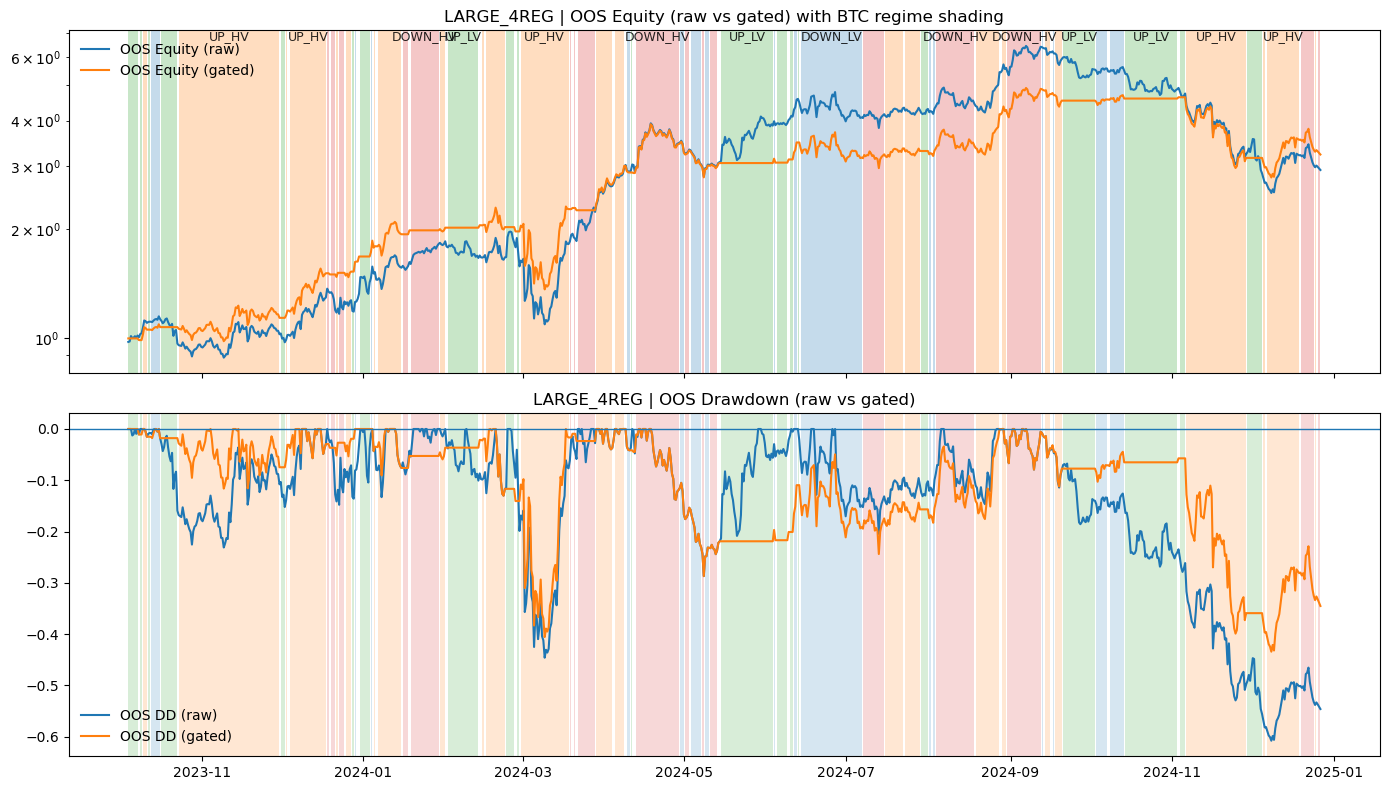

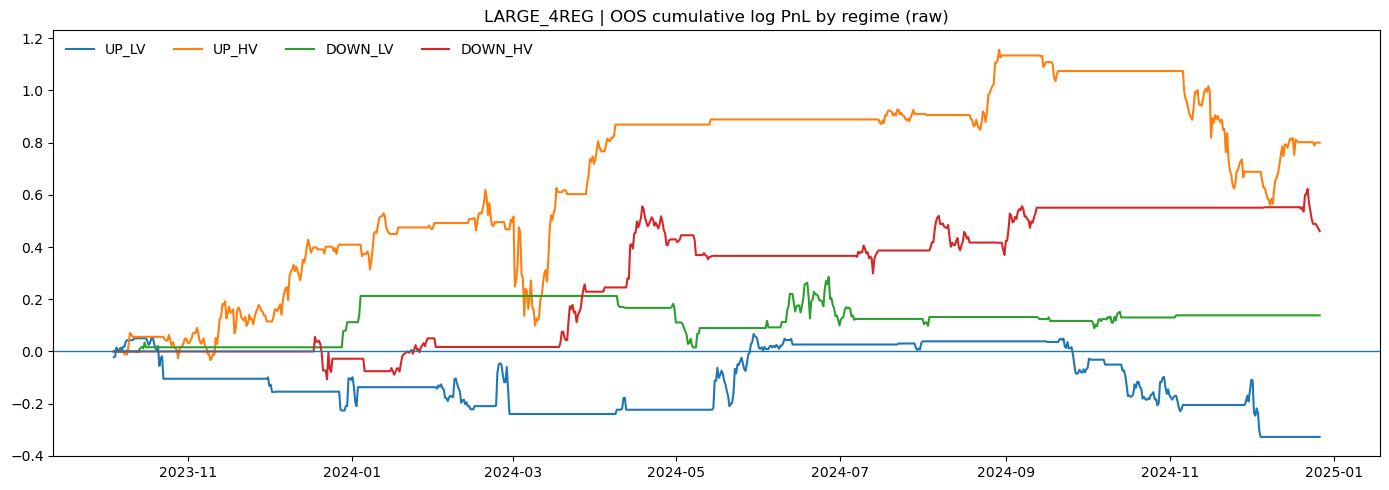

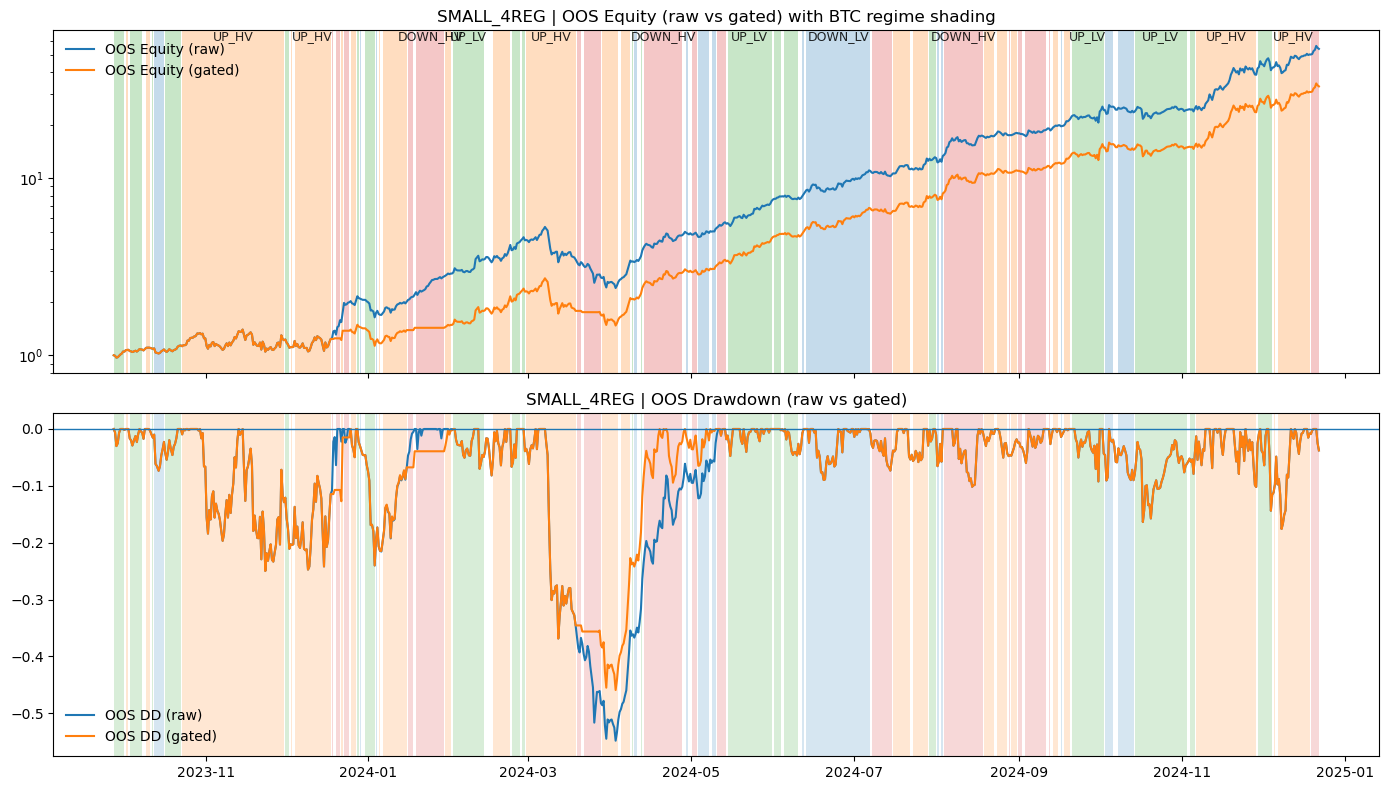

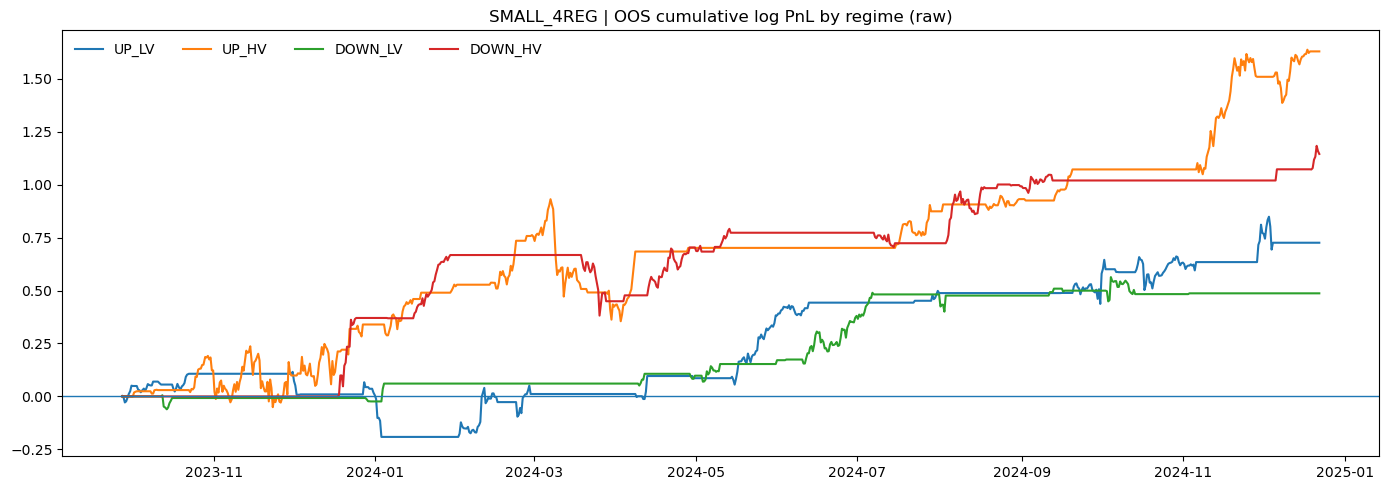

In [304]:

# =============================
# Example usage (LARGE / SMALL)
# =============================
# 1) Prepare your inputs
regime_s = prep_regime_series(btc_reg, date_col="date", regime_col="btc_regime")
lr_large = prep_return_series(spread_large, col="spread_d0_d9", kind="log")
lr_small = prep_return_series(spread_small, col="spread_d0_d9", kind="log")

# 2) Run walk-forward (example rules)
# LARGE: exclude UP_LV (your earlier finding)
wf_large = walk_forward_regime_gating(
    bucket_name="LARGE_4REG",
    lr=lr_large,
    regime_s=regime_s,
    train_days=180,
    test_days=30,
    rule="exclude_regime",
    exclude_regime="UP_LV",
    annual_bars=ANNUAL_BARS,
    min_regime_days=30,
)

# SMALL: for now, allow all (since earlier it looked broadly OK); or try exclude_bottom_k=1
wf_small = walk_forward_regime_gating(
    bucket_name="SMALL_4REG",
    lr=lr_small,
    regime_s=regime_s,
    train_days=180,
    test_days=30,
    rule="all",
    annual_bars=ANNUAL_BARS,
    min_regime_days=30,
)

# 3) Inspect results
print(wf_large["oos_summary_raw"])
print(wf_large["oos_summary_gated"])
print(wf_large["fold_table"].head())

print(wf_small["oos_summary_raw"])
print(wf_small["oos_summary_gated"])
print(wf_small["fold_table"].head())

print("\nOOS regime table (raw) - LARGE")
print(wf_large["oos_regime_table_raw"])
print("\nOOS regime table (gated) - LARGE")
print(wf_large["oos_regime_table_gated"])

# 4) Plot
plot_oos_diagnostics(wf_large, bucket_name="LARGE_4REG")
plot_oos_regime_cumulative(wf_large, "LARGE_4REG")
plot_oos_diagnostics(wf_small, bucket_name="SMALL_4REG")
plot_oos_regime_cumulative(wf_small, "SMALL_4REG")


In [308]:
wf_small.keys()

dict_keys(['fold_table', 'oos_logret_raw', 'oos_logret_gated', 'oos_regime', 'oos_summary_raw', 'oos_summary_gated', 'oos_regime_table_raw', 'oos_regime_table_gated'])

In [312]:
wf_small['oos_summary_raw']

{'annualized_return': 16346.049454230919,
 'annualized_std_dev': 1.4833328823928449,
 'annualized_sharpe_ratio': 6.540543133429921,
 'calmar_ratio': 29815.46315241835,
 'max_drawdown': -0.5482406686312059,
 'max_drawdown_duration': Timedelta('64 days 12:00:00'),
 'hit_rate': 0.5822222222222222,
 't_statistic': 4.192885583036401,
 'p_value': 3.0267649107518224e-05,
 'name': 'SMALL_4REG_OOS_RAW'}

In [282]:
regime_s.head()

date
2022-04-01 08:00:00    DOWN_LV
2022-04-01 12:00:00    DOWN_LV
2022-04-01 16:00:00    DOWN_LV
2022-04-01 20:00:00    DOWN_LV
2022-04-02 00:00:00    DOWN_LV
Name: btc_regime, dtype: object

In [284]:
lr_large.head()

date
2022-04-11 08:00:00   -0.003903
2022-04-11 20:00:00    0.020741
2022-04-12 08:00:00    0.021427
2022-04-12 20:00:00    0.026364
2022-04-13 08:00:00    0.014375
Name: spread_d0_d9, dtype: float64

In [286]:
lr_small.head()

date
2022-04-01 08:00:00    0.023747
2022-04-01 20:00:00    0.052433
2022-04-02 08:00:00    0.014732
2022-04-02 20:00:00    0.015758
2022-04-03 08:00:00    0.009044
Name: spread_d0_d9, dtype: float64

In [240]:
wf_large_4.keys()

dict_keys(['folds_df', 'oos_raw_logret', 'oos_gated_logret', 'oos_summary_raw', 'oos_summary_gated'])

In [260]:
wf_large_4['oos_summary_raw']

{'annualized_return': 12.57181133374617,
 'annualized_sharpe_ratio': 2.5024630922090534,
 'calmar_ratio': 20.689559351660115,
 'annualized_std_dev': 1.4907410278201991,
 'max_drawdown': -0.607640361984675,
 'max_drawdown_duration': Timedelta('111 days 00:00:00'),
 'hit_rate': 0.5144444444444445,
 't_statistic': 1.604230903665281,
 'p_value': 0.1090143894320631,
 'trade_count': 900.0,
 'name': 'LARGE_4REG_OOS_RAW'}

In [262]:
wf_large_4['oos_raw_logret']

date
2023-10-04 08:00:00   -0.022253
2023-10-04 20:00:00    0.002591
2023-10-05 08:00:00    0.034545
2023-10-05 20:00:00   -0.012714
2023-10-06 08:00:00    0.002483
2023-10-06 20:00:00    0.009459
2023-10-07 08:00:00   -0.008735
2023-10-07 20:00:00    0.012809
2023-10-08 08:00:00   -0.010798
2023-10-08 20:00:00    0.020479
2023-10-09 08:00:00    0.004435
2023-10-09 20:00:00    0.034309
2023-10-10 08:00:00    0.047635
2023-10-10 20:00:00   -0.004724
2023-10-11 08:00:00   -0.010512
2023-10-11 20:00:00    0.005410
2023-10-12 08:00:00    0.002090
2023-10-12 20:00:00   -0.000274
2023-10-13 08:00:00   -0.002353
2023-10-13 20:00:00    0.009442
2023-10-14 08:00:00    0.007249
2023-10-14 20:00:00    0.003045
2023-10-15 08:00:00   -0.005233
2023-10-15 20:00:00    0.022119
2023-10-16 08:00:00   -0.018010
2023-10-16 20:00:00   -0.011230
2023-10-17 08:00:00   -0.014798
2023-10-17 20:00:00    0.008283
2023-10-18 08:00:00    0.017266
2023-10-18 20:00:00    0.005178
2023-10-19 08:00:00   -0.023180
202

In [244]:
wf_large_4['folds_df']

bucket  fold         train_start           train_end  \
0  LARGE_4REG     1 2022-04-11 08:00:00 2023-10-03 20:00:00   
1  LARGE_4REG     2 2022-04-11 08:00:00 2024-01-01 20:00:00   
2  LARGE_4REG     3 2022-04-11 08:00:00 2024-03-31 20:00:00   
3  LARGE_4REG     4 2022-04-11 08:00:00 2024-06-29 20:00:00   
4  LARGE_4REG     5 2022-04-11 08:00:00 2024-09-27 20:00:00   

           test_start            test_end            rule     k  \
0 2023-10-04 08:00:00 2024-01-01 20:00:00  exclude_regime  None   
1 2024-01-02 08:00:00 2024-03-31 20:00:00  exclude_regime  None   
2 2024-04-01 08:00:00 2024-06-29 20:00:00  exclude_regime  None   
3 2024-06-30 08:00:00 2024-09-27 20:00:00  exclude_regime  None   
4 2024-09-28 08:00:00 2024-12-26 20:00:00  exclude_regime  None   

  exclude_regime  n_allowed            allowed_regimes  active_frac  \
0          UP_LV          2           [UP_HV, DOWN_LV]     0.727778   
1          UP_LV          2           [UP_HV, DOWN_LV]     0.522222   
2          UP_LV          3  [DOWN_HV, DOWN_LV, UP_HV]     0.677778   
3          UP_LV          3  [DOWN_HV, UP_HV, DOWN_LV]     0.872222   
4          UP_LV          3  [DOWN_HV, UP_HV, DOWN_LV]     0.622222   

   oos_raw_sharpe  oos_raw_ann_ret  oos_raw_ann_vol  oos_raw_mdd  \
0        3.856223        77.755811         1.375697    -0.231034   
1        4.479715      1145.093528         2.057431    -0.445842   
2        5.019925       349.178658         1.344578    -0.286820   
3        3.429462        17.861892         1.001103    -0.185550   
4       -4.115569        -0.999228         1.470515    -0.551134   

   oos_raw_calmar  oos_gate_sharpe  oos_gate_ann_ret  oos_gate_ann_vol  \
0      336.556016         6.652910        566.781867          1.033908   
1     2568.386665         3.841723        179.752160          1.780880   
2     1217.412283         2.877413         12.739148          1.128291   
3       96.264556         4.913651         69.145614          0.957811   
4       -1.813039        -2.677990         -0.984567          1.255141   

   oos_gate_mdd  oos_gate_calmar  
0     -0.116236      4876.113760  
1     -0.405581       443.197202  
2     -0.286820        44.415072  
3     -0.146500       471.984346  
4     -0.407785        -2.414426

In [220]:
train_days=180
test_days=30
rule="exclude_regime"
exclude_regime="UP_LV"
min_regime_days=30

In [218]:
regime_s

date
2022-04-01 08:00:00    DOWN_LV
2022-04-01 12:00:00    DOWN_LV
2022-04-01 16:00:00    DOWN_LV
2022-04-01 20:00:00    DOWN_LV
2022-04-02 00:00:00    DOWN_LV
2022-04-02 04:00:00    DOWN_LV
2022-04-02 08:00:00    DOWN_LV
2022-04-02 12:00:00    DOWN_LV
2022-04-02 16:00:00    DOWN_LV
2022-04-02 20:00:00    DOWN_LV
2022-04-03 00:00:00    DOWN_LV
2022-04-03 04:00:00    DOWN_LV
2022-04-03 08:00:00    DOWN_LV
2022-04-03 12:00:00    DOWN_LV
2022-04-03 16:00:00    DOWN_LV
2022-04-03 20:00:00    DOWN_LV
2022-04-04 00:00:00    DOWN_LV
2022-04-04 04:00:00    DOWN_LV
2022-04-04 08:00:00    DOWN_LV
2022-04-04 12:00:00    DOWN_LV
2022-04-04 16:00:00    DOWN_LV
2022-04-04 20:00:00    DOWN_LV
2022-04-05 00:00:00    DOWN_LV
2022-04-05 04:00:00    DOWN_LV
2022-04-05 08:00:00    DOWN_LV
2022-04-05 12:00:00    DOWN_LV
2022-04-05 16:00:00    DOWN_LV
2022-04-05 20:00:00    DOWN_LV
2022-04-06 00:00:00    DOWN_LV
2022-04-06 04:00:00    DOWN_LV
2022-04-06 08:00:00    DOWN_LV
2022-04-06 12:00:00    DOWN_LV
202

In [222]:
lr, reg = _align_spread_and_regime(spread_large, regime_s, spread_col="spread_d0_d9")
lr = lr.dropna()
reg = reg.reindex(lr.index)  # keep aligned

train_bars = train_days * BARS_PER_DAY
test_bars  = test_days  * BARS_PER_DAY
min_regime_bars = min_regime_days * BARS_PER_DAY

splits = _walk_forward_splits(lr.index, train_bars=train_bars, test_bars=test_bars, step_bars=test_bars)

rows = []
oos_raw_parts = []
oos_gated_parts = []

In [224]:
splits

[(DatetimeIndex(['2022-04-11 08:00:00', '2022-04-11 20:00:00',
                 '2022-04-12 08:00:00', '2022-04-12 20:00:00',
                 '2022-04-13 08:00:00', '2022-04-13 20:00:00',
                 '2022-04-14 08:00:00', '2022-04-14 20:00:00',
                 '2022-04-15 08:00:00', '2022-04-15 20:00:00',
                 ...
                 '2023-09-29 08:00:00', '2023-09-29 20:00:00',
                 '2023-09-30 08:00:00', '2023-09-30 20:00:00',
                 '2023-10-01 08:00:00', '2023-10-01 20:00:00',
                 '2023-10-02 08:00:00', '2023-10-02 20:00:00',
                 '2023-10-03 08:00:00', '2023-10-03 20:00:00'],
                dtype='datetime64[ns]', name='date', length=1080, freq=None),
  DatetimeIndex(['2023-10-04 08:00:00', '2023-10-04 20:00:00',
                 '2023-10-05 08:00:00', '2023-10-05 20:00:00',
                 '2023-10-06 08:00:00', '2023-10-06 20:00:00',
                 '2023-10-07 08:00:00', '2023-10-07 20:00:00',
                 '

In [186]:
spread_large.head()

ret_long_d0  ret_short_d9  spread_d0_d9
date                                                        
2022-04-11 08:00:00    -0.060734     -0.056831     -0.003903
2022-04-11 20:00:00     0.024274      0.003533      0.020741
2022-04-12 08:00:00    -0.020042     -0.041469      0.021427
2022-04-12 20:00:00     0.051292      0.024928      0.026364
2022-04-13 08:00:00     0.010704     -0.003671      0.014375

In [192]:
lr = _as_series_logret(spread_large, col="spread_d0_d9")
reg = pd.Series(regime_s).copy()
reg.index = pd.to_datetime(reg.index)
reg = reg[~reg.index.duplicated(keep="last")].sort_index()

# align to common index (we'll always reindex reg onto lr)
common_idx = lr.index.intersection(reg.index)
lr = lr.reindex(common_idx).dropna()
reg = reg.reindex(lr.index)

if lr.empty:
    raise ValueError("No overlapping data between spread_df and regime_s")

start = lr.index.min()
end   = lr.index.max()

train_len = pd.Timedelta(days=train_days)
test_len  = pd.Timedelta(days=test_days)
step_len  = pd.Timedelta(days=step_days)

In [206]:
train_len

Timedelta('180 days 00:00:00')

In [208]:
test_len

Timedelta('30 days 00:00:00')

In [210]:
step_len

Timedelta('30 days 00:00:00')

In [204]:
lr.head()

date
2022-04-11 08:00:00   -0.003903
2022-04-11 20:00:00    0.020741
2022-04-12 08:00:00    0.021427
2022-04-12 20:00:00    0.026364
2022-04-13 08:00:00    0.014375
Name: spread_d0_d9, dtype: float64

In [196]:
reg.head()

date
2022-04-11 08:00:00    DOWN_LV
2022-04-11 20:00:00    DOWN_LV
2022-04-12 08:00:00    DOWN_LV
2022-04-12 20:00:00    DOWN_LV
2022-04-13 08:00:00    DOWN_LV
Name: btc_regime, dtype: object

In [202]:
common_idx

DatetimeIndex(['2022-04-11 08:00:00', '2022-04-11 20:00:00',
               '2022-04-12 08:00:00', '2022-04-12 20:00:00',
               '2022-04-13 08:00:00', '2022-04-13 20:00:00',
               '2022-04-14 08:00:00', '2022-04-14 20:00:00',
               '2022-04-15 08:00:00', '2022-04-15 20:00:00',
               ...
               '2024-12-25 20:00:00', '2024-12-26 08:00:00',
               '2024-12-26 20:00:00', '2024-12-27 08:00:00',
               '2024-12-27 20:00:00', '2024-12-28 08:00:00',
               '2024-12-28 20:00:00', '2024-12-29 08:00:00',
               '2024-12-29 20:00:00', '2024-12-30 08:00:00'],
              dtype='datetime64[ns]', name='date', length=1987, freq=None)

In [180]:
regime_s_4 = _prep_regime_series(btc_reg, date_col="date", regime_col="btc_regime")

In [182]:
regime_s_4

date
2022-04-01 08:00:00    DOWN_LV
2022-04-01 12:00:00    DOWN_LV
2022-04-01 16:00:00    DOWN_LV
2022-04-01 20:00:00    DOWN_LV
2022-04-02 00:00:00    DOWN_LV
2022-04-02 04:00:00    DOWN_LV
2022-04-02 08:00:00    DOWN_LV
2022-04-02 12:00:00    DOWN_LV
2022-04-02 16:00:00    DOWN_LV
2022-04-02 20:00:00    DOWN_LV
2022-04-03 00:00:00    DOWN_LV
2022-04-03 04:00:00    DOWN_LV
2022-04-03 08:00:00    DOWN_LV
2022-04-03 12:00:00    DOWN_LV
2022-04-03 16:00:00    DOWN_LV
2022-04-03 20:00:00    DOWN_LV
2022-04-04 00:00:00    DOWN_LV
2022-04-04 04:00:00    DOWN_LV
2022-04-04 08:00:00    DOWN_LV
2022-04-04 12:00:00    DOWN_LV
2022-04-04 16:00:00    DOWN_LV
2022-04-04 20:00:00    DOWN_LV
2022-04-05 00:00:00    DOWN_LV
2022-04-05 04:00:00    DOWN_LV
2022-04-05 08:00:00    DOWN_LV
2022-04-05 12:00:00    DOWN_LV
2022-04-05 16:00:00    DOWN_LV
2022-04-05 20:00:00    DOWN_LV
2022-04-06 00:00:00    DOWN_LV
2022-04-06 04:00:00    DOWN_LV
2022-04-06 08:00:00    DOWN_LV
2022-04-06 12:00:00    DOWN_LV
202